# Reading, Merging, Normalizing

## Accopmlished in this notebook:

- taking the Surface-Reflectance-derived indices, now at annual and best-effort resolution and merging with classification -derived annual areal values [done]
- every catchment in the merged data is tested for trend and trend significance for each variable using mann-kendall and sen's slope estimator
    - This allows for identification of significant trends in variables in catchments
- the area values are converted from catchment km2 to upstream percentage area change (years with high proportion of masked pixels are determined to be nan)

## Merged with hydroclimatic indices
- upstream catchment areas for the meuse are computed


In [14]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import pymannkendall as mann_kendall
import itertools
from scipy.stats import kendalltau, pearsonr, spearmanr
import os
# import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr, linregress

## Reading Files

### Defining functions that import and merge surface reflectance and classification data

- one additional step is made for the Meuse data that determines the upstream area


In [58]:
# Define a function to import a table with band areas or statistics
def import_table(dataset: str, table: str, ind: str, table_type: str, year: str) -> pd.DataFrame:
    """
    Imports a table with band areas or statistics for a given catchment and year.

    Args:
        dataset (str): The name of the dataset.
        table (str): The name of the table to import.
        ind (str): The system index of the catchment.
        table_type (str): The type of table to import, either 'band_areas' or 'band_statistics'.
        year (str): The year of the table to import.

    Returns:
        pd.DataFrame: The imported table as a pandas dataframe.
    """
    # Construct the path to the table
    path = f'../Outputs/{dataset}/{table}'
    # Read the table as a pandas dataframe
    refl = pd.read_excel(f'{path}/{ind}_{table_type}_{year}.xlsx', index_col=0)
    return refl


# Define a function to import the catchment table
def import_catchment_table(dataset: str) -> pd.DataFrame:
    """
    Imports the catchment table for a given dataset.

    Args:
        dataset (str): The name of the dataset.

    Returns:
        pd.DataFrame: The imported catchment table as a pandas dataframe.
    """
    # Construct the path to the catchment table
    catch_table = pd.read_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index_col=0)
    return catch_table


# Define a function to merge band areas and statistics into a single dataframe
def merge_area_stat(dataset: str, table: str, ind: str, year: str, catchment_table: pd.DataFrame, nd_bandlist: list, catch_name_col: str) -> pd.DataFrame:
    """
    Merges the band areas and statistics tables for a given catchment and year into a single dataframe.

    Args:
        dataset (str): The name of the dataset.
        table (str): The name of the table to merge.
        ind (str): The system index of the catchment.
        year (str): The year of the tables to merge.
        catchment_table (pd.DataFrame): The catchment table for the dataset.
        nd_bandlist (list): A list of strings containing the band names to merge.
        catch_name_col (str): The name of the catchment name column in the catchment table.

    Returns:
        pd.DataFrame: The merged table as a pandas dataframe.
    """
    # Import the band areas table
    area = import_table(dataset, table, ind, 'band_areas', year)

    # Find columns that end with the strings in the match_list
    match_cols = [col for col in area.columns if col.endswith(tuple(nd_bandlist))]

    # Rename the matching columns by appending the '_area' suffix
    new_names = {col: col + '_area' for col in match_cols}
    area = area.rename(columns=new_names)

    # Import the band statistics table
    stat = import_table(dataset, table, ind, 'band_statistics', year)

    # Merge the two tables
    merged = pd.merge(area, stat, on='image_date')

    # Add columns for the system index and catchment name
    merged['system_index'] = ind
    merged['catchment'] = catchment_table.loc[ind, catch_name_col]
    
    return merged

def merge_all(sys_ind: list, index_broken, year_broken:int, years: list, dataset: str, table: str, catchment_table: pd.DataFrame, nd_bandlist: list, catch_name_col: str) -> pd.DataFrame:
    """
    Merges area and statistics tables for each system index and year, and adds catchment name and system index as columns.

    Args:
    - sys_ind (list): List of system indices to process.
    - years (list): List of years to process.
    - dataset (str): Name of the dataset being processed.
    - table (str): Name of the table being processed.
    - catchment_table (pd.DataFrame): Dataframe containing the catchment information.
    - nd_bandlist (list): List of strings that identify the ND bands.
    - catch_name_col (str): Name of the column in catchment_table that contains the catchment name.

    Returns:
    - merged (pd.DataFrame): Merged table with area and statistics information for each system index and year, as well as catchment name and system index.
    """
    
    merge = pd.DataFrame()
    
    index = sys_ind.index(index_broken)
    
    slice_broken = index + sys_ind.count(index_broken) - 1

    for ind in sys_ind:
        print(ind)
        for year in years:
            df = merge_area_stat(dataset, table, ind, year, catchment_table, nd_bandlist, catch_name_col)
            merge = pd.concat([merge, df], ignore_index=True)
            if ind == index_broken and year == year_broken:
                break
        if ind == index_broken and year == year_broken:
            print('broken', ind, year, index_broken == ind, year == year_broken)
            break
    return merge    
    

def import_class_table(dataset: str, table: str, name: str, year: str, zone: str) -> pd.DataFrame:
    """
    Imports the classification table and returns it with added columns and modified column names.

    Args:
    - dataset (str): Name of the dataset being processed.
    - table (str): Name of the table being processed.
    - name (str): Name of the catchment being processed.
    - year (str): Year of the table being processed.
    - zone (str): Zone of the catchment being processed.

    Returns:
    - classes (pd.DataFrame): Imported classification table with added columns and modified column names.
    """
    
    path = f'../Outputs/{dataset}/{table}'
    classes = pd.read_excel(f'{path}/class_areas_from_asset/{name}_{year}.xlsx', header=[0,1], index_col=0)
    multi = pd.MultiIndex.from_tuples(tuple(classes.keys()))
    
    classes.index.name= 'image_date'
    classes.index += pd.DateOffset(hours=22)
    classes.columns = classes.columns.map(map_index_values)
    classes = classes.reset_index()
    r_cols = [col for col in classes.columns if col.startswith('r_') and col != 'r_6']
    
    if year >= 1984 and year < 1999 and dataset == 'Meuse':
        acc_year = 1990
    
    elif year >= 1984 and year < 1999 and dataset == 'CAMELS_GB':
        acc_year = 2000

    elif year >= 1999 and year < 2004:
        acc_year = 2000

    elif year >= 2004 and year < 2010:
        acc_year = 2006

    elif year >= 2010 and year < 2015:
        acc_year = 2012

    elif year >= 2015:
        acc_year = 2018
    
    # print('accuracy_year',acc_year)
    # print(type(name))
    
    if dataset == 'Meuse':
        accuracy = pd.read_excel(f'../Outputs/{dataset}/Trees/{dataset}_HC_tuned_tuned_validation_metrics_{acc_year}.xlsx', index_col=0)
        
    if dataset == 'CAMELS_GB':
        table = pd.read_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index_col=0)
        zone = table[table.ID == name].zone.values
        zone_long = ''
        if zone == 'N':
            zone_long = 'North'
        elif zone == 'S':
            zone_long = 'South'
        elif zone == 'M':
            zone_long = 'Middle'
        
        accuracy = pd.read_excel(f'../Outputs/{dataset}/Trees/GB_{zone_long}_HC_tuned_validation_metrics_{acc_year}.xlsx', index_col=0)
        
    accuracy.rename(columns={'year':'year_trained'}, inplace=True)
    classes = classes.join(accuracy.set_index('year_trained'), on='year_trained')
    classes['r_6'] = classes.loc[:, 'catchment_area'] - classes[r_cols].sum(axis=1) 
    
    return classes


def map_index_values(index_tuple):
    """Maps the index values in the classification table to new values for consistency.

    Args:
        index_tuple (tuple): The index tuple to map.

    Returns:
        tuple: The mapped index tuple.
    """
    if index_tuple[0] == 'area_CORINE':
        return 'c_' + index_tuple[1]
    elif index_tuple[0] == 'area_RF':
        return 'r_' + index_tuple[1]
    elif index_tuple == ('training', 'year_trained'):
        return index_tuple[1]
    elif index_tuple == ('catchment', 'area'):
        return 'catchment_' + index_tuple[1]
    elif index_tuple[0] == 'ind':
        return 'ind'
    elif index_tuple == ('catchment', 'name '):
        return 'catchment'
    elif index_tuple == ('testing', 'accuracy'):
        return 'overall_accuracy'
    else:
        return index_tuple

def map_index_values_HILDA(index_tuple):
    """Maps the index values in the classification table to new values for consistency.

    Args:
        index_tuple (tuple): The index tuple to map.

    Returns:
        tuple: The mapped index tuple.
    """
    if index_tuple[0] == 'area_H':
        return 'h_' + index_tuple[1][:-1]
    elif index_tuple == ('training', 'year_trained'):
        return index_tuple[1]
    elif index_tuple == ('catchment', 'area'):
        return 'catchment_' + index_tuple[1]
    elif index_tuple == ('catchment', 'name '):
        return 'catchment'
    elif index_tuple == ('testing', 'accuracy'):
        return 'overall_accuracy'
    else:
        return index_tuple



def import_class_table_HILDA(dataset: str, folder: str, ind: str, year: str) -> pd.DataFrame:
    """
    Imports the classification table and returns it with added columns and modified column names.

    Args:
    - dataset (str): Name of the dataset being processed.
    - folder (str): Name of the folder being processed.
    - ind (str): Name of the catchment being processed.
    - year (str): Year of the table being processed.

    Returns:
    - classes (pd.DataFrame): Imported classification table with added columns and modified column names.
    """
    
    path = f'../Outputs/{dataset}/{folder}'
    classes = pd.read_excel(f'{path}/{ind}_{year}_HILDA.xlsx', header=[0,1], index_col=0)

    # display(classes)
    tup = tuple(classes.keys())
    # print(type(tup))
    multi = pd.MultiIndex.from_tuples(tup)
    # print(multi)
    
    classes.index.name= 'image_date'
    # classes.index += pd.DateOffset(hours=22)
    classes.columns = classes.columns.map(map_index_values_HILDA)
    classes = classes.reset_index()
    h_cols = [col for col in classes.columns if col.startswith('h_') and col != 'h_6']
    classes['h_6'] = classes.loc[:, 'catchment_area'] - classes[h_cols].sum(axis=1)
    return classes




def merge_classes(names, years, dataset, catchment_table):
    """
    Merge classification results from multiple catchments and years.

    Args:
        names (list of str): List of catchment IDs.
        years (list of str): List of years.
        dataset (str): Dataset name, either 'Meuse', 'CAMELS_GB', or 'CAMELS_US'.
        catchment_table (pd.DataFrame): Catchment table DataFrame.

    Returns:
        pd.DataFrame: Merged classification results.

    """

    merge = pd.DataFrame()
    if dataset == 'Meuse':
        years = [1899, 1930, 1950, 1960, 1970, 1980] + list(np.arange(1984, 2020))
        CORINE_years = [1990, 2000, 2006, 2012, 2018]
    
    elif dataset == 'CAMELS_GB':
        years = [1899, 1930, 1950, 1960, 1970, 1979, 1980] + list(np.arange(1984, 2020))
        CORINE_years = [1990, 2000, 2006, 2012, 2018]
    
    elif dataset == 'CAMELS_US':
        years = [1899, 1930, 1950, 1960, 1970, 1979, 1980] + list(np.arange(1981, 2020))
        CORINE_years = []
    
    else:
        print('dataset not processed')
    
    
    df_backup = []
    if dataset == 'CAMELS_GB' or dataset == 'Meuse':
        
        

        for i, name in enumerate(names):
            backup_catchment = []
            backup_area =[]
            for year in years:
                try:
                    df = import_class_table(dataset, 'RF_classification', name, year, '')
                    df_backup.append(df)
                    df2 = import_class_table_HILDA(dataset, 'class_areas_from_asset_HILDA', name, year)
                    merge_hilda = df.combine_first(df2)

                    # print('a')

                    if year not in CORINE_years:
                        # Set columns starting with 'c_' followed by a number to NaN
                        columns_to_set_nan = [col for col in merge_hilda.columns if col.startswith(tuple(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6']))]
                        merge_hilda.loc[:, columns_to_set_nan] = np.nan

                    # print(df.catchment.values, '-', df.image_date.dt.year)
                    
                    backup_catchment.append(df.catchment.values[0])
                    backup_area.append(df.catchment_area.values[0])
                    merge_hilda['catchment'] = df.catchment.values
                    merge_hilda['tot_area'] = merge_hilda.catchment_area
                    # print('BOTH', merge_hilda.image_date.values,merge_hilda.catchment.values)
                    merge = pd.concat([merge, merge_hilda], ignore_index=True)

                except FileNotFoundError as e:
                    # print(e)
                    df2 = import_class_table_HILDA(dataset, 'class_areas_from_asset_HILDA', name, year)
                    df = pd.DataFrame({'image_date': df2.image_date.values, 'catchment': df2.catchment.values, 'tot_area': df2.catchment_area})
                    merge_hilda = pd.merge(df, df2, on=['image_date', 'catchment'], how='outer')
                    backup_catchment.append(df2.catchment.values[0])
                    backup_area.append(df2.catchment_area.values[0])
                    # print('b')
                    if year not in CORINE_years:
                        # Set columns starting with 'c_' followed by a number to NaN
                        columns_to_set_nan = [col for col in merge_hilda.columns if col.startswith(tuple(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6']))]
                        merge_hilda.loc[:, columns_to_set_nan] = np.nan
                    # print('NO_RF', merge_hilda.image_date.values,merge_hilda.catchment.values)
                    merge = pd.concat([merge, merge_hilda], ignore_index=True)

                except AttributeError as e:
                    # print(str(e))
                    df = df_backup[-2]
                    y = str(year)
                    input_str = '31/08/'+y[-2:]+' 22:00:00'

                    dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')

                    df.image_date = dt_object
                    df2 = import_class_table_HILDA(dataset, 'class_areas_from_asset_HILDA', name, year)
                    merge_hilda = df.combine_first(df2)

                    # print('a')

                    if year not in CORINE_years:
                        # Set columns starting with 'c_' followed by a number to NaN
                        columns_to_set_nan = [col for col in merge_hilda.columns if col.startswith(tuple(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6']))]
                        merge_hilda.loc[:, columns_to_set_nan] = np.nan
                    
                    # print(df.catchment.values, '-', df.image_date)
                    merge_hilda['catchment'] = df.catchment.values
                    merge_hilda['tot_area'] = merge_hilda.catchment_area
                    # print('AttErr', merge_hilda.image_date.values,merge_hilda.catchment.values)
                    merge = pd.concat([merge, merge_hilda], ignore_index=True)
                    
                except IndexError as e:
                    
                    df = df_backup[-2]
                    y = str(year)
                    input_str = '31/08/'+y[-2:]+' 22:00:00'

                    dt_object = datetime.strptime(input_str, '%d/%m/%y %H:%M:%S')

                    df.image_date = dt_object
                    df2 = import_class_table_HILDA(dataset, 'class_areas_from_asset_HILDA', name, year)
                    merge_hilda = df.combine_first(df2)

                    # print('a')

                    if year not in CORINE_years:
                        # Set columns starting with 'c_' followed by a number to NaN
                        columns_to_set_nan = [col for col in merge_hilda.columns if col.startswith(tuple(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6']))]
                        merge_hilda.loc[:, columns_to_set_nan] = np.nan
                    
                    # print(df.catchment.values, '-', df.image_date)
                    merge_hilda['catchment'] = df.catchment.values
                    merge_hilda['tot_area'] = merge_hilda.catchment_area
                    
                    # print('empty?', merge_hilda.image_date.values,merge_hilda.catchment.values)
                    
                    merge = pd.concat([merge, merge_hilda], ignore_index=True)

            # if i ==1:
            #     break
    if dataset == 'CAMELS_US':
        df = pd.DataFrame()
        merge_hilda=pd.DataFrame()
        for i, name in enumerate(names):
            df_backup = []
            for year in years:
                try:
                    
                    df2 = import_class_table_HILDA(dataset, 'class_areas_from_asset_HILDA', name, year)
                    df2['system_index'] = df2.catchment.values
                    df2['catchment'] = catchment_table[catchment_table.index == name].hru_id.values[0]
                    # df = pd.DataFrame({'image_date': df2.image_date.values, 'catchment': catchment_table[catchment_table.index == name].hru_id.values[0]})
                    # merge_hilda = pd.merge(df, df2, on=['image_date', 'catchment'], how='outer')
                    merge = pd.concat([merge, df2], ignore_index=True)
                    

                except FileNotFoundError as e:
                    print(e, i, year)
            # if name == 1:
            #     break
                    
    
    merge['dataset'] = dataset
    
    merge.to_excel('../Outputs/CAMELS_US/class_areas_from_asset_HILDA/CAMELS_US_HILDA_merged.xlsx')
    print('done')
    return df, df2, merge_hilda, merge



## Data generated are on a per catchement basis
# The catchments for Meuse (FR + BE) are imported

### Merging Classified areas and the surface reflectance

In [3]:
table = 'SR_timeseries'

nd_bandlist = ['NBR','NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',]

ls = ['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho',
      'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]',
      'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville',
      'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville',
      'La Sormonne Belval', 'Le Loison Han-lés-Juvigny', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Sainte-Marie']

catch_name_col = 'station_re'

catchment_table = import_catchment_table('Meuse').set_index('system_index')

sys_ind = catchment_table[catchment_table['station_re'].isin(ls)].sort_values('area_km2', ascending=False).index.to_list()

years = np.arange(1984, 2020)


counter = 0

# def merge_all(sys_ind: list, index_broken:str, year_broken:int, years: list, dataset: str, table: str, catchment_table: pd.DataFrame, nd_bandlist: list, catch_name_col: str) -> pd.DataFrame:
meuse_merge = merge_all(sys_ind, sys_ind[-1], years[-1], years, 'Meuse', table, catchment_table, nd_bandlist, catch_name_col)
df, df2, merge_hilda, meuse_classes = merge_classes(ls, years, 'Meuse', catchment_table)

00000000000000000004
00000000000000000001
00000000000000000000
0000000000000000000d
00000000000000000022
0000000000000000000e
00000000000000000002
00000000000000000003
00000000000000000021
0000000000000000001b
0000000000000000000a
00000000000000000020
0000000000000000001d
0000000000000000001f
0000000000000000000c
00000000000000000012
00000000000000000011
00000000000000000008
0000000000000000001a
00000000000000000010
00000000000000000013
00000000000000000015
0000000000000000000f
00000000000000000014
0000000000000000001c
0000000000000000000b
00000000000000000017
broken 00000000000000000017 2019 True True


In [4]:
meuse_full_surface = meuse_classes.merge(meuse_merge, on=['image_date', 'catchment'], how='outer')
meuse_full_surface[meuse_full_surface.catchment=='Salzinnes'][['catchment', 'image_date', 'B1_mean', 'h_5', 'c_2', 'r_3', 'catchment_area']]

catchment          image_date      B1_mean         h_5          c_2  \
420  Salzinnes 1899-08-31 22:00:00          NaN   59.609482          NaN   
421  Salzinnes 1930-08-31 22:00:00          NaN  121.772139          NaN   
422  Salzinnes 1950-08-31 22:00:00          NaN  319.086786          NaN   
423  Salzinnes 1960-08-31 22:00:00          NaN  129.250000          NaN   
424  Salzinnes 1970-08-31 22:00:00          NaN  200.249087          NaN   
425  Salzinnes 1980-08-31 22:00:00          NaN  170.885418          NaN   
426  Salzinnes 1984-08-31 22:00:00  1110.734137  175.563215          NaN   
427  Salzinnes 1985-08-31 22:00:00   621.226912  157.159001          NaN   
428  Salzinnes 1986-08-31 22:00:00   588.905081  162.263932          NaN   
429  Salzinnes 1987-08-31 22:00:00   447.016078  147.000578          NaN   
430  Salzinnes 1988-08-31 22:00:00   619.750323  194.408928          NaN   
431  Salzinnes 1989-08-31 22:00:00   714.996206  119.094960          NaN   
432  Salzinnes 1990-08-31 22:00:00   498.794077  185.523297  1738.958869   
433  Salzinnes 1991-08-31 22:00:00   523.766134  107.848008          NaN   
434  Salzinnes 1992-08-31 22:00:00   866.124000  129.962175          NaN   
435  Salzinnes 1993-08-31 22:00:00   478.345590  121.093410          NaN   
436  Salzinnes 1994-08-31 22:00:00   524.179535   96.636169          NaN   
437  Salzinnes 1995-08-31 22:00:00   469.598846   86.083299          NaN   
438  Salzinnes 1996-08-31 22:00:00   384.912180   89.255781          NaN   
439  Salzinnes 1997-08-31 22:00:00   458.079215  129.847684          NaN   
440  Salzinnes 1998-08-31 22:00:00   477.301433   85.718753          NaN   
441  Salzinnes 1999-08-31 22:00:00   447.200188  130.713110          NaN   
442  Salzinnes 2000-08-31 22:00:00   360.889904   51.635855  1732.660355   
443  Salzinnes 2001-08-31 22:00:00   428.483056   77.693112          NaN   
444  Salzinnes 2002-08-31 22:00:00   548.479937  130.178255          NaN   
445  Salzinnes 2003-08-31 22:00:00   476.336046   39.421970          NaN   
446  Salzinnes 2004-08-31 22:00:00   554.844408   30.830003          NaN   
447  Salzinnes 2005-08-31 22:00:00   426.372728   33.890074          NaN   
448  Salzinnes 2006-08-31 22:00:00   448.126937   54.777302  1721.990067   
449  Salzinnes 2007-08-31 22:00:00   464.284759   96.554210          NaN   
450  Salzinnes 2008-08-31 22:00:00   486.172452   55.719701          NaN   
451  Salzinnes 2009-08-31 22:00:00   480.786215   50.430076          NaN   
452  Salzinnes 2010-08-31 22:00:00   472.096368   28.294416          NaN   
453  Salzinnes 2011-08-31 22:00:00   626.135248   36.310312          NaN   
454  Salzinnes 2012-08-31 22:00:00   355.596947   48.535729  1715.953986   
455  Salzinnes 2013-08-31 22:00:00   408.113234  113.649063          NaN   
456  Salzinnes 2014-08-31 22:00:00   381.244646   91.422728          NaN   
457  Salzinnes 2015-08-31 22:00:00   392.533290   91.422728          NaN   
458  Salzinnes 2016-08-31 22:00:00   388.642343   61.990793          NaN   
459  Salzinnes 2017-08-31 22:00:00   445.366999   72.197651          NaN   
460  Salzinnes 2018-08-31 22:00:00   493.546909   70.297203  1714.329218   
461  Salzinnes 2019-08-31 22:00:00   416.008555   11.243276          NaN   

            r_3  catchment_area  
420         NaN     2681.514071  
421         NaN     2681.514071  
422         NaN     2681.514071  
423         NaN     2681.514071  
424         NaN     2681.514071  
425         NaN     2681.514071  
426  348.184695     2681.514071  
427  116.427169     2681.514071  
428  383.666244     2681.514071  
429  547.663922     2681.514071  
430  458.338428     2681.514071  
431  276.961240     2681.514071  
432  457.483956     2681.514071  
433  399.460225     2681.514071  
434  173.434893     2681.514071  
435  472.973144     2681.514071  
436  417.793213     2681.514071  
437  620.590044     2681.514071  
438  411.017858     2681.514071  
439  560.028344     2681.514071  
440  544.748295     26

In [5]:
keys = ['EVI_area', 'GNDVI_area', 'NBR_area', 'NDFI_area', 'NDMI_area', 'NDSI_area', 'NDVI_area', 'TCA_area', 'TCB_area', 'TCG_area', 'TCW_area', 
        'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5',  'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
        'B1_mean', 'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean', 'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B7_mean', 'B7_stdDev', 
        'EVI_mean', 'EVI_stdDev', 'GNDVI_mean', 'GNDVI_stdDev', 'NBR_mean', 'NBR_stdDev', 'NDFI_mean', 'NDFI_stdDev', 'NDMI_mean', 'NDMI_stdDev', 'NDSI_mean', 
        'NDSI_stdDev', 'NDVI_mean', 'NDVI_stdDev', 'TCA_mean', 'TCA_stdDev', 'TCB_mean', 'TCB_stdDev', 'TCG_mean', 'TCG_stdDev', 'TCW_mean', 'TCW_stdDev']

SR_keys = [
        'B1_mean', 'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean', 'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B7_mean', 'B7_stdDev', 
        'EVI_mean', 'EVI_stdDev', 'GNDVI_mean', 'GNDVI_stdDev', 'NBR_mean', 'NBR_stdDev', 'NDFI_mean', 'NDFI_stdDev', 'NDMI_mean', 'NDMI_stdDev', 'NDSI_mean', 
        'NDSI_stdDev', 'NDVI_mean', 'NDVI_stdDev', 'TCA_mean', 'TCA_stdDev', 'TCB_mean', 'TCB_stdDev', 'TCG_mean', 'TCG_stdDev', 'TCW_mean', 'TCW_stdDev']

area_keys = ['EVI_area', 'GNDVI_area', 'NBR_area', 'NDFI_area', 'NDMI_area', 'NDSI_area', 'NDVI_area', 'TCA_area', 'TCB_area', 'TCG_area', 'TCW_area', # each area key relates to a km2 
             'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 
             'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
             'c_1', 'c_2', 'c_3', 'c_4', 'c_5',
            'catchment_area']



area_norm_keys = [key+'_normalized' for key in area_keys]

ups_area_keys = ['ups_'+key for key in area_keys]

ups_area_norm_keys = ['ups_'+key+'_normalized' for key in area_keys]


# normalize each area column by its respective total area
tot_area = meuse_full_surface['catchment_area']
meuse_full_surface_norm = meuse_full_surface[area_keys].div(tot_area, axis=0)
meuse_full_surface_norm.columns = [col + '_normalized' for col in area_keys]
meuse_full_surface = pd.concat([meuse_full_surface, meuse_full_surface_norm], axis=1)
meuse_full_surface = meuse_full_surface.copy()
print(list(meuse_full_surface.keys()))
meuse_full_surface[meuse_full_surface.catchment=='Salzinnes'][['catchment', 'image_date', 'B1_mean', 'h_5', 'c_1', 'c_2','c_4','c_3', 'c_3_normalized', 'r_3', 'catchment_area']]

['image_date', 'catchment', 'tot_area_x', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'year_trained', 'catchment_area', 'h_6', 'c_1', 'c_2', 'c_3', 'c_5', 'c_6', 'c_accuracy1', 'c_accuracy2', 'c_accuracy3', 'c_accuracy4', 'c_accuracy5', 'fscore1', 'fscore2', 'fscore3', 'fscore4', 'fscore5', 'ind', 'kappa', 'o_accuracy', 'overall_accuracy', 'p_accuracy1', 'p_accuracy2', 'p_accuracy3', 'p_accuracy4', 'p_accuracy5', 'r_1', 'r_2', 'r_3', 'r_5', 'r_6', 'train_valid', 'tree_name', 'c_4', 'r_4', 'h_', 'h_7', 'dataset', 'name_x', 'scale_m_x', 'tot_area_y', 'EVI_area', 'GNDVI_area', 'NBR_area', 'NDFI_area', 'NDMI_area', 'NDSI_area', 'NDVI_area', 'TCA_area', 'TCB_area', 'TCG_area', 'TCW_area', 'name_y', 'scale_m_y', 'B1_mean', 'B1_p10', 'B1_p90', 'B1_stdDev', 'B2_mean', 'B2_p10', 'B2_p90', 'B2_stdDev', 'B3_mean', 'B3_p10', 'B3_p90', 'B3_stdDev', 'B4_mean', 'B4_p10', 'B4_p90', 'B4_stdDev', 'B5_mean', 'B5_p10', 'B5_p90', 'B5_stdDev', 'B7_mean', 'B7_p10', 'B7_p90', 'B7_stdDev', 'EVI_mean', 'EVI_p10', 'EVI_p

catchment          image_date      B1_mean         h_5         c_1  \
420  Salzinnes 1899-08-31 22:00:00          NaN   59.609482         NaN   
421  Salzinnes 1930-08-31 22:00:00          NaN  121.772139         NaN   
422  Salzinnes 1950-08-31 22:00:00          NaN  319.086786         NaN   
423  Salzinnes 1960-08-31 22:00:00          NaN  129.250000         NaN   
424  Salzinnes 1970-08-31 22:00:00          NaN  200.249087         NaN   
425  Salzinnes 1980-08-31 22:00:00          NaN  170.885418         NaN   
426  Salzinnes 1984-08-31 22:00:00  1110.734137  175.563215         NaN   
427  Salzinnes 1985-08-31 22:00:00   621.226912  157.159001         NaN   
428  Salzinnes 1986-08-31 22:00:00   588.905081  162.263932         NaN   
429  Salzinnes 1987-08-31 22:00:00   447.016078  147.000578         NaN   
430  Salzinnes 1988-08-31 22:00:00   619.750323  194.408928         NaN   
431  Salzinnes 1989-08-31 22:00:00   714.996206  119.094960         NaN   
432  Salzinnes 1990-08-31 22:00:00   498.794077  185.523297  453.508575   
433  Salzinnes 1991-08-31 22:00:00   523.766134  107.848008         NaN   
434  Salzinnes 1992-08-31 22:00:00   866.124000  129.962175         NaN   
435  Salzinnes 1993-08-31 22:00:00   478.345590  121.093410         NaN   
436  Salzinnes 1994-08-31 22:00:00   524.179535   96.636169         NaN   
437  Salzinnes 1995-08-31 22:00:00   469.598846   86.083299         NaN   
438  Salzinnes 1996-08-31 22:00:00   384.912180   89.255781         NaN   
439  Salzinnes 1997-08-31 22:00:00   458.079215  129.847684         NaN   
440  Salzinnes 1998-08-31 22:00:00   477.301433   85.718753         NaN   
441  Salzinnes 1999-08-31 22:00:00   447.200188  130.713110         NaN   
442  Salzinnes 2000-08-31 22:00:00   360.889904   51.635855  461.091847   
443  Salzinnes 2001-08-31 22:00:00   428.483056   77.693112         NaN   
444  Salzinnes 2002-08-31 22:00:00   548.479937  130.178255         NaN   
445  Salzinnes 2003-08-31 22:00:00   476.336046   39.421970         NaN   
446  Salzinnes 2004-08-31 22:00:00   554.844408   30.830003         NaN   
447  Salzinnes 2005-08-31 22:00:00   426.372728   33.890074         NaN   
448  Salzinnes 2006-08-31 22:00:00   448.126937   54.777302  470.649541   
449  Salzinnes 2007-08-31 22:00:00   464.284759   96.554210         NaN   
450  Salzinnes 2008-08-31 22:00:00   486.172452   55.719701         NaN   
451  Salzinnes 2009-08-31 22:00:00   480.786215   50.430076         NaN   
452  Salzinnes 2010-08-31 22:00:00   472.096368   28.294416         NaN   
453  Salzinnes 2011-08-31 22:00:00   626.135248   36.310312         NaN   
454  Salzinnes 2012-08-31 22:00:00   355.596947   48.535729  476.842932   
455  Salzinnes 2013-08-31 22:00:00   408.113234  113.649063         NaN   
456  Salzinnes 2014-08-31 22:00:00   381.244646   91.422728         NaN   
457  Salzinnes 2015-08-31 22:00:00   392.533290   91.422728         NaN   
458  Salzinnes 2016-08-31 22:00:00   388.642343   61.990793         NaN   
459  Salzinnes 2017-08-31 22:00:00   445.366999   72.197651         NaN   
460  Salzinnes 2018-08-31 22:00:00   493.546909   70.297203  478.020651   
461  Salzinnes 2019-08-31 22:00:00   416.008555   11.243276         NaN   

             c_2       c_4         c_3  c_3_normalized         r_3  \
420          NaN       NaN         NaN             NaN         NaN   
421          NaN       NaN         NaN             NaN         NaN   
422          NaN       NaN         NaN             NaN         NaN   
423          NaN       NaN         NaN             NaN         NaN   
424          NaN       NaN         NaN             NaN         NaN   
425          NaN       NaN         NaN             NaN         NaN   
426          NaN       NaN         NaN             NaN  348.184695   
427          NaN       NaN         NaN             NaN  116.427169   
428          NaN       NaN         NaN             NaN  383.666244   
429          NaN       NaN         NaN             NaN  547.663922   
430      

## From annual data

we want to see if there is a change in upstream area, which is why we preserve area per index/class. By idetifying the upstream catchments we then sum them to create the ups_ or upstream columns (inclusive of the catchment itself)

- The upstream areas are identified in 'upstream' from the Meuse_upstream_catchments excel
- The catchment names and WFLOW ids are attached to the Meuse catchment_table excel

The outflow will be affected by the cumulative effect of changes within the catchment itself and any upstream surface so we gateher a list of names of upstream areas from the catchment outflow, that means including the catchment itself and others flowing in. 

In [6]:
upstream = pd.read_excel(f'../Inputs/Version_3_20230303/Meuse_upstream_catchments.xlsx', index_col=0)
catchment_table = pd.read_excel(f'../Outputs/Meuse/Meuse_catchment_table.xlsx', index_col='wflowID')
merge_ups = pd.merge(upstream, catchment_table, left_index=True, right_index=True)
merge_ups['wflowID'] = merge_ups.index.astype(int)#.set_index('station_re')

merge_ups = merge_ups.set_index('station_re')

names_ups = {}

for i, name in enumerate(ls):
    upstream_val= merge_ups.Upstream[name]
    

    if type(upstream_val) == int:
        arr = np.array([upstream_val])
        if arr[0] >0:
            names = merge_ups[merge_ups['wflowID'].isin(arr)].index.to_list()
            names_ups[name] = names + [name]
        else:
            names_ups[name] = [name]
        
    elif type(upstream_val) == str:
        '''
        The format of the upstream wflow IDs means that as they are read we have to split the string to integers, then we pass the 
        name of the catchment to the list as the station_re name
        '''
        arr = np.array([int(n) for n in upstream_val.split(',')])
        names = merge_ups[merge_ups['wflowID'].isin(arr)].index.to_list()
        names_ups[name] = names + [name]

#names_ups

In [7]:
mfs = meuse_full_surface
upstream_keys = []

for col in area_keys:
    '''
    add all columns to the table whereby the upstream area is computed
    '''
    upstream_key = f'ups_{col}'
    upstream_keys.append(upstream_key)
    mfs[upstream_key] = np.nan


for item in names_ups.items():
    
    catch = item[0]
    ups = item[1]
    
    for i, (ucol, acol) in enumerate(zip(upstream_keys, area_keys)):
        
        isol = [mfs.loc[mfs.catchment == c, acol].reset_index().drop(columns='index') for c in ups]
        
        cat = pd.concat(isol, axis=1)
        
        calc = cat.sum(axis=1)
        
        mfs.loc[mfs.catchment == catch, ucol] = calc.values
        


# normalize each area column by its respective total area
tot_area = mfs['ups_catchment_area']

tot_area
mfs_norm = mfs[upstream_keys].div(tot_area, axis=0)
mfs_norm.columns = [col + '_normalized' for col in upstream_keys]
mfs = pd.concat([mfs, mfs_norm], axis=1)
mfs = mfs.copy()

mfs.loc[:, area_keys] = mfs.loc[:, area_keys].replace(0, np.nan)
mfs.loc[:, ups_area_norm_keys] = mfs.loc[:, ups_area_norm_keys].replace(0, np.nan)
mfs.loc[:, ups_area_keys] = mfs.loc[:, ups_area_keys].replace(0, np.nan)


mfs.to_excel('../Outputs/all/Meuse_SR_Class_merge.xlsx')

In [8]:
mfs

image_date     catchment  tot_area_x        h_1        h_2  \
0    1899-08-31 22:00:00   Membre Pont  913.747728   1.607188   3.069693   
1    1930-08-31 22:00:00   Membre Pont  913.747728   1.607188   6.273333   
2    1950-08-31 22:00:00   Membre Pont  913.747728   1.002170  11.871818   
3    1960-08-31 22:00:00   Membre Pont  913.747728   1.002170   7.912746   
4    1970-08-31 22:00:00   Membre Pont  913.747728   1.002170   8.713757   
...                  ...           ...         ...        ...        ...   
1129 2015-08-31 22:00:00  Sainte-Marie  143.255711  26.510749   1.294133   
1130 2016-08-31 22:00:00  Sainte-Marie  143.255711  28.900983   5.304577   
1131 2017-08-31 22:00:00  Sainte-Marie  143.255711  28.034508   2.898768   
1132 2018-08-31 22:00:00  Sainte-Marie  143.255711  28.034508   2.980020   
1133 2019-08-31 22:00:00  Sainte-Marie  143.255711  28.034508   3.782989   

             h_3         h_4        h_5  year_trained  catchment_area  ...  \
0     246.718300  652.796718   9.990547          1899      913.747728  ...   
1     246.948100  613.614902  45.738923          1930      913.747728  ...   
2     248.121958  634.539908  18.646592          1950      913.747728  ...   
3     248.723196  653.534323   3.010012          1960      913.747728  ...   
4     235.563353  657.875529  11.027637          1970      913.747728  ...   
...          ...         ...        ...           ...             ...  ...   
1129   53.310768   53.922018   8.365356          2018      143.255711  ...   
1130   47.466752   53.624982   8.105730          2018      143.255711  ...   
1131   45.862117   54.491457  12.116175          2018      143.255711  ...   
1132   51.477196   56.095113   4.816188          2018      143.255711  ...   
1133   51.477196   58.503370   1.604961          2018      143.255711  ...   

      ups_h_3_normalized  ups_h_4_normalized  ups_h_5_normalized  \
0               0.342473            0.620430            0.020106   
1               0.340358            0.575068            0.059933   
2               0.346212            0.594847            0.027179   
3               0.350935            0.618639            0.006482   
4               0.328572            0.627486            0.019356   
...                  ...                 ...                 ...   
1129            0.372137            0.376404            0.058395   
1130            0.331343            0.374331            0.056582   
1131            0.320142            0.380379            0.084577   
1132            0.359338            0.391573            0.033620   
1133            0.359338            0.408384            0.011203   

      ups_h_6_normalized  ups_c_1_normalized  ups_c_2_normalized  \
0              -0.000192                 NaN                 NaN   
1              -0.000192                 NaN                 NaN   
2              -0.000192                 NaN                 NaN   
3              -0.000192                 NaN                 NaN   
4              -0.000192                 NaN                 NaN   
...                  ...                 ...                 ...   
1129           -0.001028                 NaN                 NaN   
1130           -0.001028                 NaN                 NaN   
1131           -0.001028                 NaN                 NaN   
1132           -0.001028            0.112625            0.504287   
1133           -0.001028                 NaN                 NaN   

      ups_c_3_normalized  ups_c_4_normalized  ups_c_5_normalized  \
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN                 NaN   
2                    NaN                 NaN                 NaN   
3                    NaN                 NaN                 NaN   
4                    NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1129                 NaN                 NaN          

## CAMELS_GB import and merge

### Merging Classified areas and the surface reflectance

In [9]:
# set the path and version of the input data
p = '..'
version = 'Version_3_20230303'

In [10]:
# read in the list of catchment IDs from the input csv file
l = pd.read_csv(f"{p}/Inputs/{version}/GB.csv")

# display the list of catchment IDs and convert it to a Python list
names = l.ID.tolist()

catch_name_col = 'ID'

catchment_table = import_catchment_table('CAMELS_GB')#.set_index('system_index')

sys_ind = catchment_table[catchment_table['ID'].isin(names)].sort_values('area_km2', ascending=False).index.to_list()

count = 0 
for i in names:
    try:
        pd.read_excel(f'../Outputs/CAMELS_GB/class_areas_from_asset_HILDA/{i}_1985_HILDA.xlsx')
    except FileNotFoundError as e:
        count+=1
        print(count, str(e))

In [12]:
GB_merge = merge_all(sys_ind, sys_ind[-1], years[-1], years, 'CAMELS_GB', table, catchment_table, nd_bandlist, catch_name_col)

00000000000000000088
00000000000000000235
000000000000000001c0
00000000000000000207
0000000000000000025a
00000000000000000059
0000000000000000019f
00000000000000000054
0000000000000000020a
00000000000000000299
00000000000000000125
000000000000000001e2
000000000000000001e8
0000000000000000014b
00000000000000000236
000000000000000000d2
000000000000000001b2
000000000000000001fd
0000000000000000007d
00000000000000000145
00000000000000000268
0000000000000000018b
000000000000000000f8
0000000000000000011c
0000000000000000023c
000000000000000001fe
00000000000000000241
00000000000000000188
000000000000000001e1
00000000000000000223
0000000000000000002e
000000000000000001c6
000000000000000001e7
000000000000000000ec
00000000000000000031
000000000000000001b0
0000000000000000025c
00000000000000000121
00000000000000000051
00000000000000000298
000000000000000001ab
000000000000000000d1
00000000000000000050
0000000000000000011d
000000000000000001ef
0000000000000000024d
0000000000000000016c
0000000000000

In [43]:
df, df2, merge_hilda, GB_classes = merge_classes(names, years, 'CAMELS_GB', catchment_table)

In [45]:
GB_classes[GB_classes.catchment==17005][['catchment', 'image_date','c_2',]]

catchment          image_date         c_2
0       17005 1899-08-31 22:00:00         NaN
1       17005 1930-08-31 22:00:00         NaN
2       17005 1950-08-31 22:00:00         NaN
3       17005 1960-08-31 22:00:00         NaN
4       17005 1970-08-31 22:00:00         NaN
5       17005 1979-08-31 22:00:00         NaN
6       17005 1980-08-31 22:00:00         NaN
7       17005 1984-08-31 22:00:00         NaN
8       17005 1985-08-31 22:00:00         NaN
9       17005 1986-08-31 22:00:00         NaN
10      17005 1987-08-31 22:00:00         NaN
11      17005 1988-08-31 22:00:00         NaN
12      17005 1989-08-31 22:00:00         NaN
13      17005 1990-08-31 22:00:00  143.790363
14      17005 1991-08-31 22:00:00         NaN
15      17005 1992-08-31 22:00:00         NaN
16      17005 1993-08-31 22:00:00         NaN
17      17005 1994-08-31 22:00:00         NaN
18      17005 1995-08-31 22:00:00         NaN
19      17005 1996-08-31 22:00:00         NaN
20      17005 1997-08-31 22:00:00         NaN
21      17005 1998-08-31 22:00:00         NaN
22      17005 1999-08-31 22:00:00         NaN
23      17005 2000-08-31 22:00:00  143.790363
24      17005 2001-08-31 22:00:00         NaN
25      17005 2002-08-31 22:00:00         NaN
26      17005 2003-08-31 22:00:00         NaN
27      17005 2004-08-31 22:00:00         NaN
28      17005 2005-08-31 22:00:00         NaN
29      17005 2006-08-31 22:00:00  113.808739
30      17005 2007-08-31 22:00:00         NaN
31      17005 2008-08-31 22:00:00         NaN
32      17005 2009-08-31 22:00:00         NaN
33      17005 2010-08-31 22:00:00         NaN
34      17005 2011-08-31 22:00:00         NaN
35      17005 2012-08-31 22:00:00  112.418502
36      17005 2013-08-31 22:00:00         NaN
37      17005 2014-08-31 22:00:00         NaN
38      17005 2015-08-31 22:00:00         NaN
39      17005 2016-08-31 22:00:00         NaN
40      17005 2017-08-31 22:00:00         NaN
41      17005 2018-08-31 22:00:00  112.058840
42      17005 2019-08-31 22:00:00         NaN

### concatenate rows for GB to Meuse

In [47]:
GB_full_surface = GB_classes.merge(GB_merge, on=['image_date', 'catchment'], how='outer')

gfs = GB_full_surface

In [48]:
gfs[gfs.catchment==17005][['catchment', 'image_date', 'B1_mean','c_2',]]

catchment          image_date      B1_mean         c_2
0       17005 1899-08-31 22:00:00          NaN         NaN
1       17005 1930-08-31 22:00:00          NaN         NaN
2       17005 1950-08-31 22:00:00          NaN         NaN
3       17005 1960-08-31 22:00:00          NaN         NaN
4       17005 1970-08-31 22:00:00          NaN         NaN
5       17005 1979-08-31 22:00:00          NaN         NaN
6       17005 1980-08-31 22:00:00          NaN         NaN
7       17005 1984-08-31 22:00:00  2854.778336         NaN
8       17005 1985-08-31 22:00:00   661.327431         NaN
9       17005 1986-08-31 22:00:00   577.963934         NaN
10      17005 1987-08-31 22:00:00   620.745755         NaN
11      17005 1988-08-31 22:00:00   754.912929         NaN
12      17005 1989-08-31 22:00:00   448.447563         NaN
13      17005 1990-08-31 22:00:00   659.928619  143.790363
14      17005 1991-08-31 22:00:00   887.052037         NaN
15      17005 1992-08-31 22:00:00  1016.600136         NaN
16      17005 1993-08-31 22:00:00   823.310935         NaN
17      17005 1994-08-31 22:00:00   581.600504         NaN
18      17005 1995-08-31 22:00:00   390.625710         NaN
19      17005 1996-08-31 22:00:00   554.060004         NaN
20      17005 1997-08-31 22:00:00   721.387943         NaN
21      17005 1998-08-31 22:00:00   505.764236         NaN
22      17005 1999-08-31 22:00:00   498.429814         NaN
23      17005 2000-08-31 22:00:00   325.611580  143.790363
24      17005 2001-08-31 22:00:00   513.659246         NaN
25      17005 2002-08-31 22:00:00   525.858155         NaN
26      17005 2003-08-31 22:00:00  1184.465789         NaN
27      17005 2004-08-31 22:00:00   340.286140         NaN
28      17005 2005-08-31 22:00:00   581.637888         NaN
29      17005 2006-08-31 22:00:00   464.258504  113.808739
30      17005 2007-08-31 22:00:00   514.678045         NaN
31      17005 2008-08-31 22:00:00   384.957732         NaN
32      17005 2009-08-31 22:00:00   387.617912         NaN
33      17005 2010-08-31 22:00:00   440.695084         NaN
34      17005 2011-08-31 22:00:00   360.721360         NaN
35      17005 2012-08-31 22:00:00   429.849142  112.418502
36      17005 2013-08-31 22:00:00   351.670258         NaN
37      17005 2014-08-31 22:00:00   336.631905         NaN
38      17005 2015-08-31 22:00:00   373.185301         NaN
39      17005 2016-08-31 22:00:00   431.218154         NaN
40      17005 2017-08-31 22:00:00   367.200485         NaN
41      17005 2018-08-31 22:00:00   332.253250  112.058840
42      17005 2019-08-31 22:00:00   324.252247         NaN

In [49]:


# normalize each area column by its respective total area
tot_area = gfs['catchment_area']
gfs_upstream_norm = gfs[area_keys].div(tot_area, axis=0)
gfs_upstream = gfs[area_keys]

gfs_local = gfs_upstream
gfs_local_norm = gfs_upstream_norm

upstream_cols_norm = {col: 'ups_'+col+'_normalized'  for col in area_keys}
upstream_cols = {col: 'ups_'+col  for col in area_keys}
local_cols_norm = {col: col+'_normalized'  for col in area_keys}

gfs_upstream_norm = gfs_upstream_norm.rename(columns=upstream_cols_norm)
gfs_local_norm = gfs_local_norm.rename(columns=local_cols_norm)
gfs_upstream = gfs_upstream.rename(columns=upstream_cols)

gfs = pd.concat([gfs, gfs_local_norm], axis=1)
gfs = pd.concat([gfs, gfs_upstream], axis=1)
gfs = pd.concat([gfs, gfs_upstream_norm], axis=1)
gfs = gfs.copy()
                
mfs_l = len(mfs) + 1
gfs = gfs.set_index(np.arange(mfs_l, mfs_l + len(gfs)))


if mfs.index.isin(gfs.index).any():
    print("mfs and gfs have overlapping index values")
    overlap = mfs.index[mfs.index.isin(gfs.index)]
    print("Overlapping values:", overlap)
else:
    print("mfs and gfs have non-overlapping index values")
    
print(len(gfs.catchment.drop_duplicates().values))

print(gfs.keys())

gfs.loc[:, area_keys] = gfs.loc[:, area_keys].replace(0, np.nan)
gfs.loc[:, ups_area_norm_keys] = gfs.loc[:, ups_area_norm_keys].replace(0, np.nan)
gfs.loc[:, ups_area_keys] = gfs.loc[:, ups_area_keys].replace(0, np.nan)

mfs and gfs have non-overlapping index values
95
Index(['image_date', 'catchment', 'tot_area_x', 'h_1', 'h_2', 'h_3', 'h_4',
       'h_5', 'year_trained', 'catchment_area',
       ...
       'ups_h_3_normalized', 'ups_h_4_normalized', 'ups_h_5_normalized',
       'ups_h_6_normalized', 'ups_c_1_normalized', 'ups_c_2_normalized',
       'ups_c_3_normalized', 'ups_c_4_normalized', 'ups_c_5_normalized',
       'ups_catchment_area_normalized'],
      dtype='object', length=218)


In [50]:
gfs[gfs.catchment==17005][['catchment', 'image_date', 'B1_mean','c_2','GNDVI_area_normalized', 'ups_GNDVI_area_normalized', 'ups_h_1']]

catchment          image_date      B1_mean         c_2  \
1135      17005 1899-08-31 22:00:00          NaN         NaN   
1136      17005 1930-08-31 22:00:00          NaN         NaN   
1137      17005 1950-08-31 22:00:00          NaN         NaN   
1138      17005 1960-08-31 22:00:00          NaN         NaN   
1139      17005 1970-08-31 22:00:00          NaN         NaN   
1140      17005 1979-08-31 22:00:00          NaN         NaN   
1141      17005 1980-08-31 22:00:00          NaN         NaN   
1142      17005 1984-08-31 22:00:00  2854.778336         NaN   
1143      17005 1985-08-31 22:00:00   661.327431         NaN   
1144      17005 1986-08-31 22:00:00   577.963934         NaN   
1145      17005 1987-08-31 22:00:00   620.745755         NaN   
1146      17005 1988-08-31 22:00:00   754.912929         NaN   
1147      17005 1989-08-31 22:00:00   448.447563         NaN   
1148      17005 1990-08-31 22:00:00   659.928619  143.790363   
1149      17005 1991-08-31 22:00:00   887.052037         NaN   
1150      17005 1992-08-31 22:00:00  1016.600136         NaN   
1151      17005 1993-08-31 22:00:00   823.310935         NaN   
1152      17005 1994-08-31 22:00:00   581.600504         NaN   
1153      17005 1995-08-31 22:00:00   390.625710         NaN   
1154      17005 1996-08-31 22:00:00   554.060004         NaN   
1155      17005 1997-08-31 22:00:00   721.387943         NaN   
1156      17005 1998-08-31 22:00:00   505.764236         NaN   
1157      17005 1999-08-31 22:00:00   498.429814         NaN   
1158      17005 2000-08-31 22:00:00   325.611580  143.790363   
1159      17005 2001-08-31 22:00:00   513.659246         NaN   
1160      17005 2002-08-31 22:00:00   525.858155         NaN   
1161      17005 2003-08-31 22:00:00  1184.465789         NaN   
1162      17005 2004-08-31 22:00:00   340.286140         NaN   
1163      17005 2005-08-31 22:00:00   581.637888         NaN   
1164      17005 2006-08-31 22:00:00   464.258504  113.808739   
1165      17005 2007-08-31 22:00:00   514.678045         NaN   
1166      17005 2008-08-31 22:00:00   384.957732         NaN   
1167      17005 2009-08-31 22:00:00   387.617912         NaN   
1168      17005 2010-08-31 22:00:00   440.695084         NaN   
1169      17005 2011-08-31 22:00:00   360.721360         NaN   
1170      17005 2012-08-31 22:00:00   429.849142  112.418502   
1171      17005 2013-08-31 22:00:00   351.670258         NaN   
1172      17005 2014-08-31 22:00:00   336.631905         NaN   
1173      17005 2015-08-31 22:00:00   373.185301         NaN   
1174      17005 2016-08-31 22:00:00   431.218154         NaN   
1175      17005 2017-08-31 22:00:00   367.200485         NaN   
1176      17005 2018-08-31 22:00:00   332.253250  112.058840   
1177      17005 2019-08-31 22:00:00   324.252247         NaN   

      GNDVI_area_normalized  ups_GNDVI_area_normalized    ups_h_1  
1135                    NaN                        NaN   0.696315  
1136                    NaN                        NaN   0.694713  
1137                    NaN                        NaN   1.389604  
1138                    NaN                        NaN   4.859323  
1139                    NaN                        NaN   5.555460  
1140                    NaN                        NaN   4.859323  
1141                    NaN                        NaN   6.251775  
1142               0.718234                   0.718234   6.946666  
1143               0.478760                   0.478760   5.554214  
1144               0.845025                   0.845025   9.032586  
1145               0.417674                   0.417674   8.336271  
1146               0.613705                   0.613705   9.727299  
1147               0.980002                   0.980002   9.725875  
1148               0.865866                   0.865866  11.750397  
1149               0.206042                   0.206042  12.446712  
1150               0.896512                   0.896512  12.446712  
1151               0.447832      

In [51]:
gfs.to_excel('../Outputs/all/GB_SR_Class_merge.xlsx')

In [52]:
gfs.index.max()

5219

## CAMELS_USA import and merge

### CAMELS_USA is processed only for surface reflectance

In [60]:
# import the catchment table for the specified basin
catchment_table = import_catchment_table('CAMELS_US')

# specify the name of the column in the catchment table containing the catchment IDs
catch_name_col = 'hru_id'

# select only the rows in the catchment table that match the catchment IDs in the input csv file
sys_ind = catchment_table[catchment_table[catch_name_col].isin(names)].sort_values('area_km2', ascending=True).index.to_list()

index_broken = '0000000000000000010e'
year_broken = 2011
print(sys_ind.index(index_broken))

76


In [61]:
# read in the list of catchment IDs from the input csv file
l = pd.read_csv(f"{p}/Inputs/{version}/USA.csv", index_col=0)

# add a new column with the catchment IDs
l['ID'] = l.index

# display the list of catchment IDs and convert it to a Python list
names = l.ID.tolist()

year_broken = 2010

# merge all the data sources for the selected catchments
US_merge = merge_all(sys_ind, index_broken, year_broken, years, 'CAMELS_US', table, catchment_table, nd_bandlist, catch_name_col)
US_merge

0000000000000000010a
0000000000000000025d
0000000000000000010c
00000000000000000156
00000000000000000132
00000000000000000143
000000000000000001c8
000000000000000001cb
00000000000000000192
000000000000000001bb
00000000000000000149
0000000000000000027e
00000000000000000191
00000000000000000125
00000000000000000162
000000000000000001ae
000000000000000001c3
000000000000000001cf
00000000000000000136
000000000000000000fe
0000000000000000018c
00000000000000000221
0000000000000000028e
0000000000000000027f
000000000000000001cc
0000000000000000010b
000000000000000001b3
00000000000000000256
00000000000000000182
00000000000000000151
000000000000000001d1
00000000000000000158
000000000000000001da
000000000000000001d0
00000000000000000145
0000000000000000015d
00000000000000000225
00000000000000000166
00000000000000000164
00000000000000000123
000000000000000001be
000000000000000001cd
0000000000000000010d
0000000000000000016b
000000000000000001d3
00000000000000000163
0000000000000000015b
0000000000000

image_date                name_x  scale_m_x    tot_area  \
0    1984-08-31 22:00:00  0000000000000000010a         30    9.656491   
1    1985-08-31 22:00:00  0000000000000000010a         30    9.656491   
2    1986-08-31 22:00:00  0000000000000000010a         30    9.656491   
3    1987-08-31 22:00:00  0000000000000000010a         30    9.656491   
4    1988-08-31 22:00:00  0000000000000000010a         30    9.656491   
...                  ...                   ...        ...         ...   
2758 2006-08-31 22:00:00  0000000000000000010e         30  291.801983   
2759 2007-08-31 22:00:00  0000000000000000010e         30  291.801983   
2760 2008-08-31 22:00:00  0000000000000000010e         30  291.801983   
2761 2009-08-31 22:00:00  0000000000000000010e         30  291.801983   
2762 2010-08-31 22:00:00  0000000000000000010e         30  291.801983   

        EVI_area  GNDVI_area    NBR_area   NDFI_area   NDMI_area  NDSI_area  \
0       9.656488    9.656488    9.627544    9.402675    6.833646   0.000000   
1       9.656488    9.656488    9.608422    9.594608    8.794932   0.000000   
2       8.568522    8.568404    8.447715    8.303002    7.102377   0.000000   
3       9.656488    9.655569    8.828123    8.074069    4.353653   0.000000   
4       9.656488    9.656488    8.799182    8.289318    4.689206   0.000000   
...          ...         ...         ...         ...         ...        ...   
2758  291.697274  291.543053  290.222735  288.311583  230.940419   0.113772   
2759  291.668689  291.582871  285.284111  280.381245  210.897371   0.110982   
2760  291.711235  291.688939  289.060353  284.199792  213.944202   0.122145   
2761  291.698683  291.573729  281.964560  274.123403  206.340413   0.097715   
2762  291.744039  291.638682  290.172380  288.354087  241.607080   0.067707   

      ...     TCA_mean   TCA_stdDev     TCB_mean   TCB_stdDev     TCG_mean  \
0     ...  3018.881430   872.506393  3881.628389   525.479384  2274.091167   
1     ...  3451.863760   589.592393  4025.578015   716.518474  2765.535272   
2     ...  2904.140176   893.160963  5191.676311  1265.817818  2803.761396   
3     ...  2410.990176   927.488796  4500.428656   930.409425  1933.165949   
4     ...  2634.958893  1054.830387  4057.773933   735.443048  1976.472652   
...   ...          ...          ...          ...          ...          ...   
2758  ...  3434.735373   726.644352  3526.226742   520.128049  2408.696464   
2759  ...  3287.312443   880.175304  3695.133027   594.993262  2380.868883   
2760  ...  3328.441753   800.607486  3594.596968   569.716462  2341.161342   
2761  ...  3239.258022   936.374269  3600.314528   647.851725  2258.473091   
2762  ...  3453.338943   687.226881  3431.336312   557.670364  2358.106457   

      TCG_stdDev     TCW_mean  TCW_stdDev          system_index  catchment  
0     699.675084 -1132.141883  597.265673  0000000000000000010a    1484100  
1     632.218299  -991.547713  448.863009  0000000000000000010a    1484100  
2     855.421742 -1228.643169  721.580192  0000000000000000010a    1484100  
3     625.241950 -1675.981613  929.002040  0000000000000000010a    1484100  
4     761.827377 -1518.023523  765.814731  0000000000000000010a    1484100  
...          ...          ...         ...                   ...        ...  
2758  537.293683 -1036.511398  517.757173  0000000000000000010e    1491000  
2759  645.317232 -1147.714593  676.558500  0000000000000000010e    1491000  
2760  535.505902 -1145.129914  622.521944  0000000000000000010e    1491000  
2761  624.710143 -1172.182080  691.653674  0000000000000000010e    1491000  
2762  547.147552 -1000.013050  467.917727  0000000000000000010e    1491000  

[2763 rows x 53 columns]

In [62]:
df, df2, merge_hilda, US_classes = merge_classes(sys_ind, years, 'CAMELS_US', catchment_table)

done


In [63]:
US_classes[['system_index', 'catchment', 'image_date']]

system_index  catchment          image_date
0     0000000000000000010a    1484100 1899-08-31 22:00:00
1     0000000000000000010a    1484100 1930-08-31 22:00:00
2     0000000000000000010a    1484100 1950-08-31 22:00:00
3     0000000000000000010a    1484100 1960-08-31 22:00:00
4     0000000000000000010a    1484100 1970-08-31 22:00:00
...                    ...        ...                 ...
7769  0000000000000000028b    7301500 2015-08-31 22:00:00
7770  0000000000000000028b    7301500 2016-08-31 22:00:00
7771  0000000000000000028b    7301500 2017-08-31 22:00:00
7772  0000000000000000028b    7301500 2018-08-31 22:00:00
7773  0000000000000000028b    7301500 2019-08-31 22:00:00

[7774 rows x 3 columns]

In [64]:
US_full_surface = pd.DataFrame()
US_full_surface = US_classes.merge(US_merge, on=['image_date', 'catchment'], how='outer')
ufs = US_full_surface
US_full_surface[US_full_surface.catchment==1484100][['catchment', 'image_date', 'B1_mean', 'h_4', 'catchment_area']]

catchment          image_date     B1_mean       h_4  catchment_area
0     1484100 1899-08-31 22:00:00         NaN       NaN        9.656491
1     1484100 1930-08-31 22:00:00         NaN       NaN        9.656491
2     1484100 1950-08-31 22:00:00         NaN       NaN        9.656491
3     1484100 1960-08-31 22:00:00         NaN       NaN        9.656491
4     1484100 1970-08-31 22:00:00         NaN       NaN        9.656491
5     1484100 1979-08-31 22:00:00         NaN       NaN        9.656491
6     1484100 1980-08-31 22:00:00         NaN       NaN        9.656491
7     1484100 1981-08-31 22:00:00         NaN       NaN        9.656491
8     1484100 1982-08-31 22:00:00         NaN       NaN        9.656491
9     1484100 1983-08-31 22:00:00         NaN       NaN        9.656491
10    1484100 1984-08-31 22:00:00  455.626852       NaN        9.656491
11    1484100 1985-08-31 22:00:00  396.365460       NaN        9.656491
12    1484100 1986-08-31 22:00:00  895.928081       NaN        9.656491
13    1484100 1987-08-31 22:00:00  692.709099       NaN        9.656491
14    1484100 1988-08-31 22:00:00  514.629698       NaN        9.656491
15    1484100 1989-08-31 22:00:00  563.124552       NaN        9.656491
16    1484100 1990-08-31 22:00:00  807.840189  0.049100        9.656491
17    1484100 1991-08-31 22:00:00  540.510811  0.049100        9.656491
18    1484100 1992-08-31 22:00:00  729.321675  0.049100        9.656491
19    1484100 1993-08-31 22:00:00  528.790570  0.049100        9.656491
20    1484100 1994-08-31 22:00:00  902.583668  0.049100        9.656491
21    1484100 1995-08-31 22:00:00  329.218670  0.049100        9.656491
22    1484100 1996-08-31 22:00:00  351.388506  0.049100        9.656491
23    1484100 1997-08-31 22:00:00  596.387558  0.105722        9.656491
24    1484100 1998-08-31 22:00:00  574.549844  0.105722        9.656491
25    1484100 1999-08-31 22:00:00  384.193832  0.105722        9.656491
26    1484100 2000-08-31 22:00:00  427.412244  0.105722        9.656491
27    1484100 2001-08-31 22:00:00  335.496385  0.105722        9.656491
28    1484100 2002-08-31 22:00:00  446.379620  0.105722        9.656491
29    1484100 2003-08-31 22:00:00  644.206634  0.385096        9.656491
30    1484100 2004-08-31 22:00:00  450.327259  0.385096        9.656491
31    1484100 2005-08-31 22:00:00  351.278154  0.385096        9.656491
32    1484100 2006-08-31 22:00:00  322.506395  0.385096        9.656491
33    1484100 2007-08-31 22:00:00  543.118402  0.385096        9.656491
34    1484100 2008-08-31 22:00:00  375.069195  0.385096        9.656491
35    1484100 2009-08-31 22:00:00  392.279133  0.385096        9.656491
36    1484100 2010-08-31 22:00:00  319.773968  0.570062        9.656491
37    1484100 2011-08-31 22:00:00  307.407939  0.570062        9.656491
38    1484100 2012-08-31 22:00:00  442.944869  0.570062        9.656491
39    1484100 2013-08-31 22:00:00  360.928988  0.570062        9.656491
40    1484100 2014-08-31 22:00:00  346.031375  0.570062        9.656491
41    1484100 2015-08-31 22:00:00  315.113209  0.570062        9.656491
42    1484100 2016-08-31 22:00:00  346.717332  0.570062        9.656491
43    1484100 2017-08-31 22:00:00  383.383369  0.570062        9.656491
44    1484100 2018-08-31 22:00:00  327.136538  1.532905        9.656491
45    1484100 2019-08-31 22:00:00  331.910628  1.532905        9.656491

In [65]:
area_keys_US = ['EVI_area', 'GNDVI_area', 'NBR_area', 'NDFI_area', 'NDMI_area', 'NDSI_area', 'NDVI_area', 'TCA_area', 'TCB_area', 'TCG_area', 'TCW_area', # each area key relates to a km2 
             # 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 
             'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
             # 'c_1', 'c_2', 'c_3', 'c_4', 'c_5',
            'catchment_area']

area_norm_keys_US = [key+'_normalized' for key in area_keys_US]

ups_area_keys_US = ['ups_'+key for key in area_keys_US]

ups_area_norm_keys_US = ['ups_'+key+'_normalized' for key in area_keys_US]

ufs= US_full_surface

# normalize each area column by its respective total area
tot_area = ufs['catchment_area']
ufs_upstream_norm = ufs[area_keys_US].div(tot_area, axis=0)
ufs_upstream = ufs[area_keys_US]

ufs_local = ufs_upstream
ufs_local_norm = ufs_upstream_norm

upstream_cols_norm = {col: 'ups_'+col+'_normalized'  for col in area_keys_US}
upstream_cols = {col: 'ups_'+col  for col in area_keys_US}
local_cols_norm = {col: col+'_normalized'  for col in area_keys_US}

ufs_upstream_norm = ufs_upstream_norm.rename(columns=upstream_cols_norm)
ufs_local_norm = ufs_local_norm.rename(columns=local_cols_norm)
ufs_upstream = ufs_upstream.rename(columns=upstream_cols)

ufs = pd.concat([ufs, ufs_local_norm], axis=1)
ufs = pd.concat([ufs, ufs_upstream], axis=1)
ufs = pd.concat([ufs, ufs_upstream_norm], axis=1)
ufs = ufs.copy()
                
gfs_l =gfs.index.max() +1
ufs = ufs.set_index(np.arange(gfs_l, gfs_l + len(ufs)))


if gfs.index.isin(ufs.index).any():
    print("gfs and ufs have overlapping index values")
    overlap = gfs.index[gfs.index.isin(ufs.index)]
    print("Overlapping values:", overlap)
else:
    print("gfs and ufs have non-overlapping index values")
    
print(len(ufs.catchment.drop_duplicates().values))

print(ufs.keys())

ufs.loc[:, area_keys_US] = ufs.loc[:, area_keys_US].replace(0, np.nan)
ufs.loc[:, ups_area_norm_keys_US] = ufs.loc[:, ups_area_norm_keys_US].replace(0, np.nan)
ufs.loc[:, ups_area_keys_US] = ufs.loc[:, ups_area_keys_US].replace(0, np.nan)

ufs

gfs and ufs have non-overlapping index values
169
Index(['image_date', 'h_2', 'year_trained', 'catchment_area', 'catchment',
       'h_6', 'system_index_x', 'h_4', 'h_3', 'h_5',
       ...
       'ups_TCB_area_normalized', 'ups_TCG_area_normalized',
       'ups_TCW_area_normalized', 'ups_h_1_normalized', 'ups_h_2_normalized',
       'ups_h_3_normalized', 'ups_h_4_normalized', 'ups_h_5_normalized',
       'ups_h_6_normalized', 'ups_catchment_area_normalized'],
      dtype='object', length=118)


image_date          h_2  year_trained  catchment_area  \
5220  1899-08-31 22:00:00     9.661854          1899        9.656491   
5221  1930-08-31 22:00:00     9.661854          1930        9.656491   
5222  1950-08-31 22:00:00     9.661854          1950        9.656491   
5223  1960-08-31 22:00:00     9.661854          1960        9.656491   
5224  1970-08-31 22:00:00     9.661854          1970        9.656491   
...                   ...          ...           ...             ...   
12989 2015-08-31 22:00:00  1734.087927          2015     6885.117414   
12990 2016-08-31 22:00:00  1783.110771          2016     6885.117414   
12991 2017-08-31 22:00:00  1844.217159          2017     6885.117414   
12992 2018-08-31 22:00:00  1844.217159          2018     6885.117414   
12993 2019-08-31 22:00:00  1844.217159          2019     6885.117414   

       catchment       h_6        system_index_x  h_4          h_3        h_5  \
5220     1484100 -0.005363  0000000000000000010a  NaN          NaN        NaN   
5221     1484100 -0.005363  0000000000000000010a  NaN          NaN        NaN   
5222     1484100 -0.005363  0000000000000000010a  NaN          NaN        NaN   
5223     1484100 -0.005363  0000000000000000010a  NaN          NaN        NaN   
5224     1484100 -0.005363  0000000000000000010a  NaN          NaN        NaN   
...          ...       ...                   ...  ...          ...        ...   
12989    7301500  1.046878  0000000000000000028b  NaN  5056.902116  67.886337   
12990    7301500  1.046878  0000000000000000028b  NaN  5009.893109  64.862887   
12991    7301500  1.046878  0000000000000000028b  NaN  4951.307243  61.332507   
12992    7301500  1.046878  0000000000000000028b  NaN  4951.307243  61.332507   
12993    7301500  1.046878  0000000000000000028b  NaN  4951.307243  61.332507   

       ...  ups_TCB_area_normalized  ups_TCG_area_normalized  \
5220   ...                      NaN                      NaN   
5221   ...                      NaN                      NaN   
5222   ...                      NaN                      NaN   
5223   ...                      NaN                      NaN   
5224   ...                      NaN                      NaN   
...    ...                      ...                      ...   
12989  ...                      NaN                      NaN   
12990  ...                      NaN                      NaN   
12991  ...                      NaN                      NaN   
12992  ...                      NaN                      NaN   
12993  ...                      NaN                      NaN   

      ups_TCW_area_normalized ups_h_1_normalized  ups_h_2_normalized  \
5220                      NaN                NaN            1.000555   
5221                      NaN                NaN            1.000555   
5222                      NaN                NaN            1.000555   
5223                      NaN                NaN            1.000555   
5224                      NaN                NaN            1.000555   
...                       ...                ...                 ...   
12989                     NaN           0.003659            0.251860   
12990                     NaN           0.003806            0.258980   
12991                     NaN           0.003953            0.267856   
12992                     NaN           0.003953            0.267856   
12993                     NaN           0.003953            0.267856   

       ups_h_3_normalized  ups_h_4_normalized  ups_h_5_normalized  \
5220                  NaN                 NaN                 NaN   
5221                  NaN                 NaN                 NaN   
5222                  NaN                 NaN                 NaN   
5223                  NaN                 NaN                 NaN   
5224                  NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
12989            0.734469                 NaN            0.0

In [66]:
# Check for overlapping index values
if mfs.index.isin(gfs.index).any():
    print("mfs and gfs have overlapping index values")
    overlap = mfs.index[mfs.index.isin(gfs.index)]
    print("Overlapping values:", overlap)
else:
    print("mfs and gfs have non-overlapping index values")
    

if mfs.index.isin(ufs.index).any():
    print("mfs and ufs have overlapping index values")
    overlap = ufs.index[ufs.index.isin(mfs.index)]
    print("Overlapping values:", overlap)
else:
    print("mfs and ufs have non-overlapping index values")

if gfs.index.isin(ufs.index).any():
    print("gfs and ufs have overlapping index values")
    overlap = ufs.index[ufs.index.isin(gfs.index)]
    print("Overlapping values:", overlap)
else:
    print("gfs and ufs have non-overlapping index values")

# Print the number of unique catchment values in the ufs dataframe and the last 30 columns of the ufs dataframe
print(len(ufs.catchment.drop_duplicates().values))
# ufs.iloc[:, -30:]

mfs and gfs have non-overlapping index values
mfs and ufs have non-overlapping index values
gfs and ufs have non-overlapping index values
169


## Keys from the merged tables

 - suffix '_area'  -- denotes an area above a critical values:
 
 -{'NBR': 0.1, 'NDMI': 0.2, 'NDVI': 0.2, 'NDSI': 0.4, 'EVI': 0.2, 'GNDVI': 0.2, 'TCB': 0.15, 'TCG': 0.1, 'TCW': 0.15, 'TCA': 0.2, 'NDFI': -0.2}
 
- suffix '_mean' -- is the mean area to the smallest allowable scale ('BestEffort') 
- suffix '_stDev' -- is the bestEffort standard Deviation
- c_n - area in square kilometer per class n as provided by corine data, extended through the timeseries unchanged from the training data (no sixth class, no masked pixels)
- r_n - similarly an area per class n but derived from the random forest classification technique (r_6 are masked pixels)
- p_accuracyn - producers accuracy per class n
- c_accuracyn - consumers accuracy per class n

In [67]:
mfs = mfs.copy()
gfs = gfs.copy()
ufs = ufs.copy()

gm_df =pd.concat([mfs, gfs], ignore_index=True)

gm_df = pd.concat([gm_df, ufs], ignore_index=True)

gm_df.to_excel('../Outputs/all/SR_Class_Areatable_annual.xlsx', index=0)

In [68]:
# list(gm_df.keys())
gm_df = gm_df.reset_index(drop=True)
gm_df[gm_df.dataset == 'CAMELS_GB'][['image_date', 'B1_mean']].iloc[:20]
# gm_df.dataset

image_date      B1_mean
1134 1899-08-31 22:00:00          NaN
1135 1930-08-31 22:00:00          NaN
1136 1950-08-31 22:00:00          NaN
1137 1960-08-31 22:00:00          NaN
1138 1970-08-31 22:00:00          NaN
1139 1979-08-31 22:00:00          NaN
1140 1980-08-31 22:00:00          NaN
1141 1984-08-31 22:00:00  2854.778336
1142 1985-08-31 22:00:00   661.327431
1143 1986-08-31 22:00:00   577.963934
1144 1987-08-31 22:00:00   620.745755
1145 1988-08-31 22:00:00   754.912929
1146 1989-08-31 22:00:00   448.447563
1147 1990-08-31 22:00:00   659.928619
1148 1991-08-31 22:00:00   887.052037
1149 1992-08-31 22:00:00  1016.600136
1150 1993-08-31 22:00:00   823.310935
1151 1994-08-31 22:00:00   581.600504
1152 1995-08-31 22:00:00   390.625710
1153 1996-08-31 22:00:00   554.060004

In [69]:
# Select the numeric columns
numeric_cols = gm_df.select_dtypes(include=['float', 'int']).columns.tolist()
non_numeric = gm_df.select_dtypes(include=['object', 'datetime']).columns.tolist()

group_mean = gm_df.groupby('catchment')

dummy_df = pd.DataFrame()

for i, (group, data) in enumerate(group_mean):
    g_mean = data[numeric_cols].rolling(window=10, min_periods=2).mean()
    # print(len(g_mean))
    g_mean = pd.concat([g_mean, data[non_numeric]], axis=1)
    # print(len(g_mean))
    dummy_df = pd.concat([dummy_df, g_mean])
    
# Compute the rolling mean only for the numeric columns
g_mean = dummy_df

# Merge the rolling mean with the non-numeric columns


In [70]:
table = g_mean.reset_index()
table[table.dataset == 'CAMELS_GB'][['image_date', 'catchment', 'B1_mean', 'h_1', 'h_2', 'h_3', 'h_4']].iloc[25:55]

image_date catchment      B1_mean       h_1        h_2  \
25 2002-08-31 22:00:00      8009   444.224992       NaN        NaN   
26 2003-08-31 22:00:00      8009   485.032429       NaN        NaN   
27 2004-08-31 22:00:00      8009   481.289050       NaN        NaN   
28 2005-08-31 22:00:00      8009   494.932379       NaN        NaN   
29 2006-08-31 22:00:00      8009   507.991255       NaN        NaN   
30 2007-08-31 22:00:00      8009   512.884503       NaN        NaN   
31 2008-08-31 22:00:00      8009   499.862191       NaN        NaN   
32 2009-08-31 22:00:00      8009   502.820420       NaN        NaN   
33 2010-08-31 22:00:00      8009   533.477536       NaN        NaN   
34 2011-08-31 22:00:00      8009   546.978308       NaN        NaN   
35 2012-08-31 22:00:00      8009   549.237613       NaN        NaN   
36 2013-08-31 22:00:00      8009   503.047339       NaN        NaN   
37 2014-08-31 22:00:00      8009   482.840464       NaN        NaN   
38 2015-08-31 22:00:00      8009   477.007352       NaN        NaN   
39 2016-08-31 22:00:00      8009   443.229079       NaN        NaN   
40 2017-08-31 22:00:00      8009   431.058472       NaN        NaN   
41 2018-08-31 22:00:00      8009   422.649668  1.342745        NaN   
42 2019-08-31 22:00:00      8009   411.290400  1.342745        NaN   
43 1899-08-31 22:00:00     17005          NaN       NaN        NaN   
44 1930-08-31 22:00:00     17005          NaN  0.695514  12.944080   
45 1950-08-31 22:00:00     17005          NaN  0.926877  12.053810   
46 1960-08-31 22:00:00     17005          NaN  1.909989  11.123684   
47 1970-08-31 22:00:00     17005          NaN  2.639083  10.843423   
48 1979-08-31 22:00:00     17005          NaN  3.009123  10.031842   
49 1980-08-31 22:00:00     17005          NaN  3.472359   9.888363   
50 1984-08-31 22:00:00     17005          NaN  3.906648   9.780753   
51 1985-08-31 22:00:00     17005  1758.052883  4.089710   9.280564   
52 1986-08-31 22:00:00     17005  1364.689900  4.583998   9.240280   
53 1987-08-31 22:00:00     17005  1178.703864  5.347994   8.647428   
54 1988-08-31 22:00:00     17005  1093.945677  6.251252   8.012645   

           h_3        h_4  
25  161.596119  58.391931  
26  158.060956  58.009043  
27  157.371551  57.502349  
28  157.076175  56.928554  
29  159.814418  58.078017  
30  163.014158  58.497307  
31  166.157720  59.308281  
32  170.327407  60.119788  
33  176.291475  60.609678  
34  183.179712  61.026162  
35  189.305017  61.581397  
36  194.683351  62.788142  
37  198.666191  64.095114  
38  202.388877  65.603497  
39  202.625107  66.042909  
40  202.995702  66.391768  
41  203.299069  66.562685  
42  202.664481  65.975679  
43         NaN        NaN  
44  151.105894  19.284524  
45  156.975485  16.343004  
46  162.417695  12.270886  
47  165.025388   9.953577  
48  167.154292   8.408705  
49  168.039744   7.404673  
50  166.873681   6.771587  
51  167.713704   6.349166  
52  168.025770   6.016682  
53  171.149180   3.629809  
54  172.430525   2.790538

In [71]:
def remove_spaces(strings):
    return [s.strip() for s in strings]

FR_catchments = remove_spaces(['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville'])
BE_catchments = remove_spaces(['Membre Pont ', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Hastiere', 'Warnant ', 'Ortho ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay '])

def country_col(df):
    # create a dictionary to map dataset values to country codes
    country_dict = {'CAMELS_US': 'US', 'CAMELS_GB': 'GB'}

    # create a new column 'country' and assign values based on conditions
    df['country'] = np.where(df['catchment'].isin(BE_catchments), 'BE', 
                              np.where(df['catchment'].isin(FR_catchments), 'FR',
                                       df['dataset'].map(country_dict)))
    return df


table = country_col(table)
table.to_excel('../Outputs/all/mean_SR_tables.xlsx')

In [72]:
table[table.country == 'GB'][['image_date', 'catchment', 'B1_mean', 'country']]

image_date catchment     B1_mean country
0    1899-08-31 22:00:00      8009         NaN      GB
1    1930-08-31 22:00:00      8009         NaN      GB
2    1950-08-31 22:00:00      8009         NaN      GB
3    1960-08-31 22:00:00      8009         NaN      GB
4    1970-08-31 22:00:00      8009         NaN      GB
...                  ...       ...         ...     ...
4080 2015-08-31 22:00:00     94001  549.379352      GB
4081 2016-08-31 22:00:00     94001  505.042055      GB
4082 2017-08-31 22:00:00     94001  493.646757      GB
4083 2018-08-31 22:00:00     94001  491.969870      GB
4084 2019-08-31 22:00:00     94001  482.546864      GB

[4085 rows x 4 columns]

# Hydroclimatic Merge

In [73]:
FR_decades = ('1989 - 1998', '1999 - 2008', '2009 - 2018')
BE_decades = ('1999 - 2008', '2009 - 2018')
GB_decades = ('1970 - 1979', '1980 - 1989', '1990 - 1999', '2000 - 2009')
US_decades = ('1981 - 1989', '1990 - 1999', '2000 - 2009')

FR_dec_end = [1899, 1930, 1950, 1960, 1970, 1998, 2008, 2018]
BE_dec_end = [1899, 1930, 1950, 1960, 1970, 2008, 2018]
GB_dec_end = [1899, 1930, 1950, 1960, 1970, 1979, 1989, 1999, 2009]
USA_dec_end = [1899, 1930, 1950, 1960, 1970, 1989, 1999, 2009]

In [74]:
ude, gde, fde, bde = USA_dec_end, GB_dec_end, FR_dec_end, BE_dec_end

dummy_df = pd.DataFrame()
# dummy_delta_df = pd.DataFrame()

grouped = table.groupby('catchment')

def add_suffix(df, suffix):
    # create a dictionary to store the new column names
    new_names = {'catchment':'catchment'}
    
    # loop through each column in the dataframe
    for i, col in enumerate(df.columns):
        # skip the first column (assumed to be the catchment column)
        if i == 0:
            continue
        # check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # generate a new column name with the prefix
            new_col = col+suffix
            # add the new column name to the dictionary
            new_names[col] = new_col
    
    # rename the columns using the dictionary
    df = df.rename(columns=new_names)
    
    return df

for i, (group, data) in enumerate(grouped):
    df = pd.DataFrame(data)


    country = df.country.iloc[0]

    if country == 'FR':
        filtered_df = df[df['image_date'].dt.year.isin(fde)]
    elif country == 'BE':
        filtered_df = df[df['image_date'].dt.year.isin(bde)]
    elif country == 'US':
        filtered_df = df[df['image_date'].dt.year.isin(ude)]
    elif country == 'GB':
        filtered_df = df[df['image_date'].dt.year.isin(gde)]
        # print('GB', len(filtered_df))
        # display(filtered_df[['image_date', 'catchment', 'B1_mean']])
    else:
        print('not all rows have country code that matches conditions')

    # Select only the numeric columns
    numeric_cols = filtered_df.select_dtypes(include=['float', 'int']).columns.tolist()
    
    non_numeric = filtered_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
    
    filtered_delta_df = filtered_df[numeric_cols].diff()
    
    filtered_delta_df = pd.concat([filtered_df, add_suffix(filtered_delta_df[numeric_cols], '_change')], axis=1)
    
    dummy_df = pd.concat([dummy_df, filtered_delta_df], ignore_index=True)
    # display(dummy_df)
    
#     if i == 2:
#         break

merged_df = dummy_df

RS_merge = merged_df.loc[:, ~merged_df.columns.duplicated()].copy()

RS_merge#loc[RS_merge['dataset']=='CAMELS_US']

not all rows have country code that matches conditions
not all rows have country code that matches conditions
not all rows have country code that matches conditions
not all rows have country code that matches conditions
not all rows have country code that matches conditions


index  tot_area_x        h_1        h_2         h_3        h_4  \
0      5090         NaN        NaN        NaN         NaN        NaN   
1      5091  272.369829        NaN        NaN  182.571374  50.080894   
2      5092  272.369829        NaN        NaN  191.293649  46.814964   
3      5093  272.369829        NaN        NaN  196.013608  47.038578   
4      5094  272.369829        NaN        NaN  197.321966  47.648369   
...     ...         ...        ...        ...         ...        ...   
2404    380  142.240404   5.998371  28.393611   76.487648  17.290428   
2405    381  142.240404   5.998371  31.261240   75.706360  17.989901   
2406    382  142.240404   6.315364  32.980084   74.693144  18.489523   
2407    408  142.240404   8.763107  30.036974   71.873364  25.923469   
2408    418  142.240404  12.012854  33.901235   64.635731  26.117941   

            h_5  year_trained  catchment_area       h_6  ...  \
0           NaN           NaN             NaN       NaN  ...   
1     34.741231   1914.500000      272.369829  4.976330  ...   
2     30.446496   1926.333333      272.369829  3.814718  ...   
3     26.441782   1934.750000      272.369829  2.875861  ...   
4     25.046788   1941.800000      272.369829  2.352706  ...   
...         ...           ...             ...       ...  ...   
2404  13.829030   1926.333333      142.240404  0.241316  ...   
2405  11.043216   1934.750000      142.240404  0.241316  ...   
2406   9.520972   1941.800000      142.240404  0.241316  ...   
2407   5.402174   2003.000000      142.240404  0.241316  ...   
2408   5.331328   2013.800000      142.240404  0.241316  ...   

      ups_h_4_normalized_change  ups_h_5_normalized_change  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                     -0.011991                  -0.015768   
3                      0.000821                  -0.014703   
4                      0.002239                  -0.005122   
...                         ...                        ...   
2404                   0.000473                   0.006972   
2405                   0.004918                  -0.019585   
2406                   0.003513                  -0.010702   
2407                   0.052263                  -0.028957   
2408                   0.001367                  -0.000498   

      ups_h_6_normalized_change  ups_c_1_normalized_change  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                 -4.264834e-03                        NaN   
3                 -3.446995e-03                        NaN   
4                 -1.920753e-03                        NaN   
...                         ...                        ...   
2404               1.333569e-16                        NaN   
2405               1.647987e-17                        NaN   
2406               9.974660e-18                        NaN   
2407              -7.979728e-17                        NaN   
2408               7.979728e-17                   0.000229   

      ups_c_2_normalized_change  ups_c_3_normalized_change  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
2404                        NaN                        NaN   
2405                        NaN                        NaN   
2406                        NaN                        NaN   
2407                        NaN                        NaN   
2408                  -0.000296                   0.000068   

      ups_c_4_normalized_change  ups_c_5_normalized_change  \
0                           NaN                        NaN   
1            

In [75]:
RS_merge.to_excel('../Outputs/all/SR_mean_with_change.xlsx', index='index')

In [76]:
RS_merge[['image_date', 'catchment', 'h_1_change', 'B1_mean_change']].iloc[:30]

image_date catchment  h_1_change  B1_mean_change
0  1899-08-31 22:00:00      8009         NaN             NaN
1  1930-08-31 22:00:00      8009         NaN             NaN
2  1950-08-31 22:00:00      8009         NaN             NaN
3  1960-08-31 22:00:00      8009         NaN             NaN
4  1970-08-31 22:00:00      8009         NaN             NaN
5  1979-08-31 22:00:00      8009         NaN             NaN
6  1989-08-31 22:00:00      8009         NaN             NaN
7  1999-08-31 22:00:00      8009         NaN     -137.560844
8  2009-08-31 22:00:00      8009         NaN     -232.738316
9  1899-08-31 22:00:00     17005         NaN             NaN
10 1930-08-31 22:00:00     17005         NaN             NaN
11 1950-08-31 22:00:00     17005    0.231363             NaN
12 1960-08-31 22:00:00     17005    0.983111             NaN
13 1970-08-31 22:00:00     17005    0.729094             NaN
14 1979-08-31 22:00:00     17005    0.370040             NaN
15 1989-08-31 22:00:00     17005    4.075756             NaN
16 1999-08-31 22:00:00     17005    6.981325     -322.486664
17 2009-08-31 22:00:00     17005    6.017202     -141.572895
18 1899-08-31 22:00:00     18001         NaN             NaN
19 1930-08-31 22:00:00     18001         NaN             NaN
20 1950-08-31 22:00:00     18001         NaN             NaN
21 1960-08-31 22:00:00     18001         NaN             NaN
22 1970-08-31 22:00:00     18001         NaN             NaN
23 1979-08-31 22:00:00     18001         NaN             NaN
24 1989-08-31 22:00:00     18001         NaN             NaN
25 1999-08-31 22:00:00     18001         NaN     -364.487226
26 2009-08-31 22:00:00     18001         NaN      -62.900607
27 1899-08-31 22:00:00     20007         NaN             NaN
28 1930-08-31 22:00:00     20007         NaN             NaN
29 1950-08-31 22:00:00     20007         NaN             NaN

# Import hydroclimatic data
- Tasks must be accomplished before merging the inherited data: 
1. Homogenize the headers (deviation to _change)
2. 'melt' and reindex the dataframe to useable datetime index matching the decadal datetimes used in the remote sensing portion
    - Merge the resulting decadal and change values on the same datetime index with common names
3. merge with the remote sensing dataframes 


In [83]:
FR = pd.read_excel(f"{p}/Inputs/{version}/FR.xlsx")
FR.rename({'EI deviation 1999 - 2008': 'EI_change 1999 - 2008', 
           'EI deviation 2009 - 2018':'EI_change 2009 - 2018',
           'Sr actual 1989 - 1998':'Sr 1989 - 1998',
         'Sr actual 1999 - 2008':'Sr 1999 - 2008',
         'Sr actual 2009 - 2018':'Sr 2009 - 2018',
          'Sr deviation 1999 - 2008':'Sr_change 1999 - 2008',
         'Sr deviation 2009 - 2018':'Sr_change 2009 - 2018',
           'Epa':'Ep',
          'Epa 1989 - 1998':'Ep 1989 - 1998',
         'Epa 1999 - 2008':'Ep 1999 - 2008',
         'Epa 2009 - 2018':'Ep 2009 - 2018',
         'Epa_change 1999 - 2008':'Ep_change 1999 - 2008',
         'Epa_change 2009 - 2018':'Ep_change 2009 - 2018',}, inplace=True, axis=1)

BE = pd.read_excel(f"{p}/Inputs/{version}/BE.xlsx")
BE.rename({'EI deviation 2009 - 2018': 'EI_change 2009 - 2018', 
           'Epa':'Ep',
           'Epa 1999 - 2008':'Ep 1999 - 2008',
             'Epa 2009 - 2018':'Ep 2009 - 2018',
             'Epa_change 2009 - 2018':'Ep_change 2009 - 2018',
           'Sr actual 1999 - 2008':'Sr 1999 - 2008',
         'Sr actual 2009 - 2018':'Sr 2009 - 2018',
           'Sr deviation 2009 - 2018':'Sr_change 2009 - 2018'}, inplace=True, axis=1)

GB = pd.read_csv(f"{p}/Inputs/{version}/GB.csv")
GB.rename({"ID":"catchment",
          'EI deviation 1980 - 1989':'EI_change 1980 - 1989',
         'EI deviation 1990 - 1999':'EI_change 1990 - 1999',
         'EI deviation 2000 - 2009':'EI_change 2000 - 2009',
          'P 1970 - 1979':'Pa 1970 - 1979',
         'P 1980 - 1989':'Pa 1980 - 1989',
         'P 1990 - 1999':'Pa 1990 - 1999',
         'P 2000 - 2009':'Pa 2000 - 2009',
         'P_change 1980 - 1989':'Pa_change 1980 - 1989',
         'P_change 1990 - 1999':'Pa_change 1990 - 1999',
         'P_change 2000 - 2009':'Pa_change 2000 - 2009',
         'Sr actual 1970 - 1979':'Sr 1970 - 1979',
         'Sr actual 1980 - 1989':'Sr 1980 - 1989',
         'Sr actual 1990 - 1999':'Sr 1990 - 1999',
         'Sr actual 2000 - 2009':'Sr 2000 - 2009',
         'Sr deviation 1980 - 1989':'Sr_change 1980 - 1989',
         'Sr deviation 1990 - 1999':'Sr_change 1990 - 1999',
         'Sr deviation 2000 - 2009':'Sr_change 2000 - 2009',}, inplace=True, axis=1)

US = pd.read_csv(f"{p}/Inputs/{version}/USA.csv")
US.rename({"Unnamed: 0":"catchment",
          'EI deviation 1990 - 1999':'EI_change 1990 - 1999',
         'EI deviation 2000 - 2009':'EI_change 2000 - 2009',
          'Epa':'Ep',
         'Epa 1981 - 1989':'Ep 1981 - 1989',
         'Epa 1990 - 1999':'Ep 1990 - 1999',
         'Epa 2000 - 2009':'Ep 2000 - 2009',
         'Epa_change 1990 - 1999':'Ep_change 1990 - 1999',
         'Epa_change 2000 - 2009':'Ep_change 2000 - 2009',
          'Sr actual 1981 - 1989':'Sr 1981 - 1989',
         'Sr actual 1990 - 1999':'Sr 1990 - 1999',
         'Sr actual 2000 - 2009':'Sr 2000 - 2009',
          'Sr deviation 1990 - 1999':'Sr_change 1990 - 1999',
         'Sr deviation 2000 - 2009':'Sr_change 2000 - 2009',}, inplace=True, axis=1)


FR_key_set = set(FR.keys())
BE_key_set = set(BE.keys())
GB_key_set = set(GB.keys())
US_key_set = set(US.keys())


key_intersection = FR_key_set.intersection(BE_key_set).intersection(GB_key_set).intersection(US_key_set)


In [84]:
from dateutil.relativedelta import relativedelta

def remove_trailing_space(catchment):
    if isinstance(catchment, str):
        return catchment.rstrip()
    else:
        return catchment

def format_year(year):
        """
        Format a string representation of a year into the end of decade date.

        Args:
            year (str): A string representing the year in the format 'YYYY'.

        Returns:
            datetime: The end of decade date as a datetime object.
        """
        # Remove any leading or trailing spaces from the year string
        year = year.strip()

        # Parse the year string and return the end of the decade date
        year_dt = datetime.strptime(year, '%Y')
        end_of_decade = datetime(year_dt.year + 10, 8, 31, 22, 0, 0)
        return end_of_decade

def create_dec_end(start_year):
        """
        Create the dec_end column by subtracting one year from the start_year column while accounting for leap years.

        Args:
            start_year (str): A string representing the start year of the decade in the format 'YYYY'.

        Returns:
            datetime: The end of decade date as a datetime object.
        """
        
        start_year = start_year.strip()
        # Parse the start_year string
        start_year_dt = datetime.strptime(start_year, '%Y')

        # Subtract one year from the start_year while accounting for leap years
        dec_end = start_year_dt# - relativedelta(years=1)
        dec_end = dec_end.replace(month=8, day=31, hour=22, minute=0, second=0)

        return dec_end

def day_replace(year):
        
        rep = year.replace(month=8, day=31, hour=22, minute=0, second=0)

        return dec_end    

def melt_df(df):
    """
    This function takes a pandas DataFrame and performs the following operations:
    - Melt the DataFrame
    - Split the 'index_year' column into separate 'index' and 'year' columns
    - Pivot the DataFrame
    - Format the 'year' and 'dec_end' columns
    - Drop unnecessary columns
    
    Args:
    - df (pandas DataFrame): the DataFrame to be melted
    
    Returns:
    - df_pivot (pandas DataFrame): the pivoted DataFrame with properly formatted columns
    
    Raises:
    - None
    
    """
    
    # Melt the DataFrame
    df_melt = df.melt(id_vars='catchment', var_name='index_year', value_name='value')

    # Split the 'index_year' column into two separate columns
    df_melt[['index', 'year']] = df_melt['index_year'].str.split(' ', n=1, expand=True)

    # Drop the 'index_year' column
    df_melt.drop('index_year', axis=1, inplace=True)

    # Pivot the DataFrame
    df_pivot = df_melt.pivot(index=['catchment', 'year'], columns='index', values='value').reset_index()

    # Split the 'year' column into 'start_year' and 'end_year' columns
    df_pivot[['start_year', 'end_year']] = df_pivot['year'].str.split('-', expand=True)
    
    # Format the 'start_year' and 'end_year' columns
    df_pivot['start_year'] = df_pivot['start_year']
    
    # Apply the create_dec_end function to the 'start_year' column to create the 'dec_end' column
    df_pivot['dec_end'] = df_pivot['end_year'].apply(create_dec_end)

    # Convert the 'dec_end' column to a formatted string
    df_pivot['dec_end'] = df_pivot['dec_end'].dt.strftime('%Y-%m-%d %H:%M:%S')

    return df_pivot




def create_HC_dataframe(df:pd.DataFrame, country:str):
    """
    Creates a dataframe containing the hydraulic condition (HC) variables for a given country.

    Args:
    - df (pd.DataFrame): input dataframe containing HC variables for a given country
    - country (str): two-letter country code for the country to be processed

    Returns:
    - merged (pd.DataFrame): dataframe containing the HC variables, with one row per catchment and decade
    """

    
    HC_const_indices = ['AI', 'EI', 'Ep', 'Pa', 'ST', 'SI', 'Sr', 'T', 'is_dur', 'omega']
    
    key_intersection = set(HC_const_indices + ['catchment']).intersection(set(list(df.keys())))
    
    if country == 'FR':
        decades = FR_decades
        dec_mean_keys = [f'{ind} {decade}' for ind in HC_const_indices for decade in decades]
        dec_end_years = [int(i[-4:]) for i in FR_decades]
        delta_end_years = dec_end_years[1:]
        print(country, dec_end_years)
        delta_keys = [f'{ind}_change {decade}' for ind in HC_const_indices[:-1] for decade in decades[1:]]
        constant = ['AI', 'EI', 'Ep', 'Pa', ]
        
     
    
    if country == 'BE':
        decades = BE_decades
        dec_mean_keys = [f'{ind} {decade}' for ind in HC_const_indices for decade in decades]
        dec_end_years = [int(i[-4:]) for i in BE_decades]
        print(country, dec_end_years)
        delta_end_years = dec_end_years[1:]
        delta_keys = [f'{ind}_change {decade}' for ind in HC_const_indices[:-1] for decade in decades[1:]]
     
    
    if country == 'GB':
        decades = GB_decades
        dec_mean_keys = [f'{ind} {decade}' for ind in HC_const_indices for decade in decades]
        dec_end_years = [int(i[-4:]) for i in GB_decades]
        print(country, dec_end_years)
        delta_end_years = dec_end_years[1:]
        delta_keys = [f'{ind}_change {decade}' for ind in HC_const_indices[:-1] for decade in decades[1:]]
        
       
    
    if country == 'US':
        decades = US_decades
        
        dec_mean_keys = [f'{ind} {decade}' for ind in HC_const_indices for decade in decades]
        dec_end_years = [int(i[-4:]) for i in US_decades]
        
        delta_end_years = dec_end_years[1:]
        
        delta_keys = [f'{ind}_change {decade}' for ind in HC_const_indices[:-1] for decade in decades[1:]]
        
      
    

    dec = melt_df(df.loc[:, ['catchment']+dec_mean_keys])
    
    decadal =dec.rename({i:f'{i}_mean' for i in HC_const_indices}, axis=1)
    
    decadal['country'] = country
    
    constant = df.loc[:, list(key_intersection)].add_prefix('LT_')
    
    constant = constant.rename(columns={'LT_catchment': 'catchment'})
    
    change = melt_df(df.loc[:, ['catchment']+delta_keys])
    
    merge = pd.merge(decadal, change, on=['catchment', 'dec_end'], how='left')
    
    dummy = pd.DataFrame()

    for _, data in merge.groupby('catchment'):
        numeric_cols = data.select_dtypes(include=['float', 'int']).columns[data.select_dtypes(include=['float', 'int']).columns.str.endswith('_mean')]
        non_numeric = data.select_dtypes(include=['object', 'datetime']).columns.tolist()
        numeric_mean_diff = data[numeric_cols].diff().add_suffix('_diff')
        numeric_mean_diff_pct = data[numeric_cols].pct_change(periods=1).add_suffix('_diff_pct')
        
        data = pd.concat([data, numeric_mean_diff, numeric_mean_diff_pct], axis=1)
        dummy = pd.concat([dummy, data], axis=0)
        
    # Drop duplicate columns
    for col in dummy.columns:
        if col in merge.columns and col != 'catchment' and col != 'dec_end':
            merge = merge.drop(col, axis=1)
    
    merge = pd.merge(merge, dummy, on=['catchment', 'dec_end'])
    
    merge = pd.merge(merge, constant, on=['catchment'])
    
    merge = merge.loc[:, ~merge.columns.duplicated()]
    
    merge['catchment'] = merge['catchment'].apply(remove_trailing_space)
        
    display(merge)
    
    print(merge.shape)
    
    
    return merge

FR_combo = create_HC_dataframe(FR, 'FR')
BE_combo = create_HC_dataframe(BE, 'BE')
GB_combo = create_HC_dataframe(GB, 'GB')
US_combo = create_HC_dataframe(US, 'US')

result = pd.concat([FR_combo,BE_combo,GB_combo,US_combo], ignore_index=True)

result.to_excel('../Outputs/all/catchments_HC_combined.xlsx', index=None)

FR [1998, 2008, 2018]


catchment              dec_end       year_x  \
0                          La Bar Cheveuges  1998-08-31 22:00:00  1989 - 1998   
1                          La Bar Cheveuges  2008-08-31 22:00:00  1999 - 2008   
2                          La Bar Cheveuges  2018-08-31 22:00:00  2009 - 2018   
3                        La Chiers Carignan  1998-08-31 22:00:00  1989 - 1998   
4                        La Chiers Carignan  2008-08-31 22:00:00  1999 - 2008   
5                        La Chiers Carignan  2018-08-31 22:00:00  2009 - 2018   
6                     La Chiers Longlaville  1998-08-31 22:00:00  1989 - 1998   
7                     La Chiers Longlaville  2008-08-31 22:00:00  1999 - 2008   
8                     La Chiers Longlaville  2018-08-31 22:00:00  2009 - 2018   
9                         La Meuse Goncourt  1998-08-31 22:00:00  1989 - 1998   
10                        La Meuse Goncourt  2008-08-31 22:00:00  1999 - 2008   
11                        La Meuse Goncourt  2018-08-31 22:00:00  2009 - 2018   
12                    La Meuse Saint-Mihiel  1998-08-31 22:00:00  1989 - 1998   
13                    La Meuse Saint-Mihiel  2008-08-31 22:00:00  1999 - 2008   
14                    La Meuse Saint-Mihiel  2018-08-31 22:00:00  2009 - 2018   
15                          La Meuse Stenay  1998-08-31 22:00:00  1989 - 1998   
16                          La Meuse Stenay  2008-08-31 22:00:00  1999 - 2008   
17                          La Meuse Stenay  2018-08-31 22:00:00  2009 - 2018   
18                 La Vence la Francheville  1998-08-31 22:00:00  1989 - 1998   
19                 La Vence la Francheville  2008-08-31 22:00:00  1999 - 2008   
20                 La Vence la Francheville  2018-08-31 22:00:00  2009 - 2018   
21  Le Mouzon Circourt-sur-Mouzon [Villars]  1998-08-31 22:00:00  1989 - 1998   
22  Le Mouzon Circourt-sur-Mouzon [Villars]  2008-08-31 22:00:00  1999 - 2008   
23  Le Mouzon Circourt-sur-Mouzon [Villars]  2018-08-31 22:00:00  2009 - 2018   
24       Le Vair Soulosse-sous-Saint-Élophe  1998-08-31 22:00:00  1989 - 1998   
25       Le Vair Soulosse-sous-Saint-Élophe  2008-08-31 22:00:00  1999 - 2008   
26       Le Vair Soulosse-sous-Saint-Élophe  2018-08-31 22:00:00  2009 - 2018   

     AI_mean   EI_mean     Ep_mean      Pa_mean   SI_mean   ST_mean  \
0   0.640179  0.629046  597.512792   933.352591  0.182647  0.115816   
1   0.595952  0.583998  624.075546  1047.190398  0.169380  0.070344   
2   0.712920  0.592735  625.230644   876.999450  0.208518  0.095511   
3   0.627441  0.612039  603.671065   962.115608  0.218485  0.097110   
4   0.605398  0.584844  630.200377  1040.968305  0.163856  0.044324   
5   0.769345  0.531178  631.079193   820.281586  0.183424  0.091853   
6   0.596101  0.507075  600.570213  1007.497267  0.289757  0.106231   
7   0.589975  0.552497  626.405349  1061.749519  0.178930  0.052864   
8   0.729113  0.481227  625.892203   858.429928  0.187993  0.069792   
9   0.792681  0.619508  660.372680   833.087636  0.141971  0.077911   
10  0.768196  0.588668  673.297172   876.465559  0.126299  0.050751   
11  0.810951  0.629747  690.636998   851.638439  0.156992  0.027717   
12  0.804039  0.549132  649.215365   807.442700  0.141525  0.096318   
13  0.754642  0.551324  664.177076   880.121673  0.119393  0.052243   
14  0.844654  0.579880  678.820965   803.667867  0.160617  0.043828   
15  0.779729  0.557156  638.572927   818.968057  0.140370  0.079007   
16  0.734029  0.538987  656.347630   894.170981  0.108994  0.045519   
17  0.844258  0.551960  667.647986   790.810160  0.162058  0.045339   
18  0.564975  0.474870  587.548206  1039.953511  0.218697  0.115134   
19  0.531159  0.447453  613.474185  1154.973576  0.198067  0.060167   
20  0.627393  0.477637  615.449796   980.963010  0.234389  0.128934   
21  0.784608  0.630485  654.399466   834.046643  0.148891  0.093686   
22  0.743103  0.605410  668.771589   899.971225  0.121144  0.044424   
23  0.814458  0.592135  685.205596   841.302390  0.164227  0.

(27, 57)
BE [2008, 2018]


catchment              dec_end       year_x   AI_mean   EI_mean  \
0          Amay  2008-08-31 22:00:00  1999 - 2008  0.601459  0.571944   
1          Amay  2018-08-31 22:00:00  2009 - 2018  0.721302  0.552602   
2         Chooz  2008-08-31 22:00:00  1999 - 2008  0.604676  0.537924   
3         Chooz  2018-08-31 22:00:00  2009 - 2018  0.723158  0.515247   
4    Daverdisse  2008-08-31 22:00:00  1999 - 2008  0.495321  0.492952   
5    Daverdisse  2018-08-31 22:00:00  2009 - 2018  0.607368  0.474783   
6      Hastiere  2008-08-31 22:00:00  1999 - 2008  0.715191  0.609709   
7      Hastiere  2018-08-31 22:00:00  2009 - 2018  0.786589  0.616150   
8     Huccorgne  2008-08-31 22:00:00  1999 - 2008  0.732473  0.698507   
9     Huccorgne  2018-08-31 22:00:00  2009 - 2018  0.849057  0.727061   
10      Jemelle  2008-08-31 22:00:00  1999 - 2008  0.541819  0.521522   
11      Jemelle  2018-08-31 22:00:00  2009 - 2018  0.676402  0.457841   
12  Membre Pont  2008-08-31 22:00:00  1999 - 2008  0.459068  0.457375   
13  Membre Pont  2018-08-31 22:00:00  2009 - 2018  0.578288  0.421974   
14        Ortho  2008-08-31 22:00:00  1999 - 2008  0.524161  0.523309   
15        Ortho  2018-08-31 22:00:00  2009 - 2018  0.651531  0.507107   
16    Salzinnes  2008-08-31 22:00:00  1999 - 2008  0.686587  0.626809   
17    Salzinnes  2018-08-31 22:00:00  2009 - 2018  0.789578  0.645732   
18    Straimont  2008-08-31 22:00:00  1999 - 2008  0.459019  0.452976   
19    Straimont  2018-08-31 22:00:00  2009 - 2018  0.581580  0.416384   
20     Treignes  2008-08-31 22:00:00  1999 - 2008  0.606154  0.551506   
21     Treignes  2018-08-31 22:00:00  2009 - 2018  0.669998  0.551213   
22      Warnant  2008-08-31 22:00:00  1999 - 2008  0.697196  0.589646   
23      Warnant  2018-08-31 22:00:00  2009 - 2018  0.802773  0.612263   
24     Wiheries  2008-08-31 22:00:00  1999 - 2008  0.674940  0.551138   
25     Wiheries  2018-08-31 22:00:00  2009 - 2018  0.765537  0.590991   

       Ep_mean      Pa_mean   SI_mean   ST_mean     Sr_mean  ...  \
0   607.398468  1009.875236  0.161482  0.047028  192.983740  ...   
1   608.992735   844.296353  0.186293  0.096873  171.888248  ...   
2   631.044503  1043.607243  0.150024  0.081549  175.322962  ...   
3   635.767206   879.153401  0.175837  0.066194  163.117401  ...   
4   597.977921  1207.254318  0.193114  0.026718  184.356898  ...   
5   595.479382   980.425661  0.213731  0.097747  167.138666  ...   
6   597.371906   835.261519  0.131777  0.042097  166.438578  ...   
7   595.679886   757.295173  0.187355  0.098434  183.081008  ...   
8   591.562519   807.623519  0.148615  0.040596  236.603186  ...   
9   585.574837   689.676597  0.193971  0.112046  236.568352  ...   
10  595.632072  1099.319372  0.163341  0.000154  180.852501  ...   
11  592.192957   875.504819  0.176810  0.133541  136.253987  ...   
12  607.702541  1323.775460  0.208486  0.062592  175.123006  ...   
13  606.362589  1048.548215  0.223754  0.107297  150.923850  ...   
14  594.893517  1134.943199  0.159636  0.013639  190.467262  ...   
15  591.204293   907.408418  0.177207  0.133508  176.095256  ...   
16  588.814477   857.596869  0.144126  0.062004  183.113652  ...   
17  597.723824   757.016885  0.186956  0.095581  213.120168  ...   
18  601.939657  1311.361094  0.202587  0.047406  172.451871  ...   
19  600.133000  1031.901405  0.217324  0.107989  146.420934  ...   
20  595.133733   981.820160  0.158576  0.062790  174.837387  ...   
21  597.798915   892.240201  0.186046  0.099964  193.271077  ...   
22  592.759953   850.205719  0.139860  0.031041  156.830125  ...   
23  589.661652   734.530987  0.192952  0.098937  181.834654  ...   
24  587.277156   870.117455  0.149101  0.053370  141.251165  ...   
25  596.174137   778.765620  0.178799  0.079296  179.815130  ...   

    omega_mean_diff_pct     LT_ST     LT_EI        LT_Pa     LT_AI  \
0                   NaN  0.055622  0.563137   927.085795  0.656029   
1             -0.409406  0.055622  0.563137   927.085795 

(26, 57)
GB [1979, 1989, 1999, 2009]


catchment              dec_end       year_x   AI_mean   EI_mean  \
0         8009  1979-08-31 22:00:00  1970 - 1979  0.446784  0.330654   
1         8009  1989-08-31 22:00:00  1980 - 1989  0.402179  0.292794   
2         8009  1999-08-31 22:00:00  1990 - 1999  0.393159  0.332329   
3         8009  2009-08-31 22:00:00  2000 - 2009  0.388700  0.315495   
4        17005  1979-08-31 22:00:00  1970 - 1979  0.510905  0.427966   
..         ...                  ...          ...       ...       ...   
375      93001  2009-08-31 22:00:00  2000 - 2009  0.152086  0.139544   
376      94001  1979-08-31 22:00:00  1970 - 1979  0.179727  0.125018   
377      94001  1989-08-31 22:00:00  1980 - 1989  0.166912  0.079023   
378      94001  1999-08-31 22:00:00  1990 - 1999  0.160943  0.098247   
379      94001  2009-08-31 22:00:00  2000 - 2009  0.172460  0.112590   

      Ep_mean   Pa_mean   SI_mean   ST_mean     Sr_mean  ...  \
0    1.129545  2.528168  0.180497  0.104391   76.874450  ...   
1    1.138762  2.831484  0.207901  0.211600   98.076490  ...   
2    1.156682  2.942021  0.199386  0.078904  130.774736  ...   
3    1.170172  3.010479  0.212336  0.122853   83.465089  ...   
4    1.261180  2.468520  0.221090  0.185670  154.055417  ...   
..        ...       ...       ...       ...         ...  ...   
375  1.140825  7.501196  0.307330  0.169855   55.911969  ...   
376  1.088429  6.056008  0.344354  0.246288   55.636257  ...   
377  1.083139  6.489266  0.366255  0.281871   29.642548  ...   
378  1.111267  6.904721  0.321506  0.113042   41.630554  ...   
379  1.141267  6.617569  0.303284  0.164628   36.862894  ...   

     Pa_mean_diff_pct  SI_mean_diff_pct  ST_mean_diff_pct Sr_mean_diff_pct  \
0                 NaN               NaN               NaN              NaN   
1            0.119974          0.151824          1.026988         0.275801   
2            0.039039         -0.040961         -0.627108         0.333395   
3            0.023269          0.064953          0.556986        -0.361764   
4                 NaN               NaN               NaN              NaN   
..                ...               ...               ...              ...   
375         -0.063388         -0.002087          0.548828        -0.247532   
376               NaN               NaN               NaN              NaN   
377          0.071542          0.063599          0.144479        -0.467208   
378          0.064022         -0.122179         -0.598957         0.404419   
379         -0.041588         -0.056677          0.456338        -0.114523   

    T_mean_diff_pct is_dur_mean_diff_pct omega_mean_diff_pct       LT_Sr  \
0               NaN                  NaN                 NaN   96.561642   
1         -0.004913            -0.061159           -0.047003   96.561642   
2          0.063322             0.051824            0.216813   96.561642   
3          0.049269            -0.094017           -0.068937   96.561642   
4               NaN                  NaN                 NaN  118.551469   
..              ...                  ...                 ...         ...   
375        0.039938            -0.075431           -0.066970   58.059170   
376             NaN                  NaN                 NaN   43.522735   
377       -0.007818            -0.038266           -0.156393   43.522735   
378        0.057287            -0.010155            0.090948   43.522735   
379        0.037359            -0.039747            0.041243   43.522735   

        LT_EI     LT_AI  
0    0.317355  0.405524  
1    0.317355  0.405524  
2    0.317355  0.405524  
3    0.317355  0.405524  
4    0.348859  0.452201  
..        ...       ...  
375  0.113586  0.146104  
376  0.102831  0.169540  
377  0.102831  0.169540  
378  0.102831  0.169540  
379  0.102831  0.169540  

[380 rows x 51 columns]

(380, 51)


catchment              dec_end       year_x   AI_mean   EI_mean  \
0      1411300  1989-08-31 22:00:00  1981 - 1989  0.819113  0.580946   
1      1411300  1999-08-31 22:00:00  1990 - 1999  0.786265  0.594592   
2      1411300  2009-08-31 22:00:00  2000 - 2009  0.778942  0.663183   
3      1484100  1989-08-31 22:00:00  1981 - 1989  0.835441  0.687383   
4      1484100  1999-08-31 22:00:00  1990 - 1999  0.767383  0.643483   
..         ...                  ...          ...       ...       ...   
502    8086212  1999-08-31 22:00:00  1990 - 1999  1.637549  0.937624   
503    8086212  2009-08-31 22:00:00  2000 - 2009  1.635407  0.966839   
504    8086290  1989-08-31 22:00:00  1981 - 1989  1.744501  0.950470   
505    8086290  1999-08-31 22:00:00  1990 - 1999  1.529400  0.938728   
506    8086290  2009-08-31 22:00:00  2000 - 2009  1.549649  0.956205   

         Ep_mean      Pa_mean   SI_mean   ST_mean     Sr_mean  ...  \
0     898.033138  1096.347778  0.175957 -0.080853  192.442676  ...   
1     912.386944  1160.407000  0.239483 -0.022261  205.159079  ...   
2     897.739742  1152.512222  0.214033  0.066282  304.316173  ...   
3     930.936709  1114.305556  0.161583  0.074160  271.124701  ...   
4     909.671971  1185.421000  0.196360 -0.030973  214.840097  ...   
..           ...          ...       ...       ...         ...  ...   
502  1163.755211   710.669000  0.224184  0.278115  327.601907  ...   
503  1151.610302   704.173333  0.366109  0.497918  374.864241  ...   
504  1170.137666   670.757778  0.475441  0.253737  410.783436  ...   
505  1161.784227   759.634000  0.201453  0.153549  349.662686  ...   
506  1138.904043   734.943333  0.356316  0.504586  346.726506  ...   

     omega_mean_diff_pct     LT_ST     LT_EI        LT_Pa     LT_AI  \
0                    NaN  0.084290  0.612706  1137.278929  0.794058   
1               0.087316  0.084290  0.612706  1137.278929  0.794058   
2               0.327282  0.084290  0.612706  1137.278929  0.794058   
3                    NaN  0.072025  0.665483  1179.074286  0.777149   
4              -0.033777  0.072025  0.665483  1179.074286  0.777149   
..                   ...       ...       ...          ...       ...   
502            -0.040163  0.329170  0.954228   683.416429  1.701542   
503             0.235029  0.329170  0.954228   683.416429  1.701542   
504                  NaN  0.293609  0.947938   723.130357  1.600147   
505             0.055656  0.293609  0.947938   723.130357  1.600147   
506             0.111708  0.293609  0.947938   723.130357  1.600147   

          LT_Sr       LT_T  LT_is_dur        LT_Ep     LT_SI  
0    233.865141  12.699504   4.564516   903.065191  0.159123  
1    233.865141  12.699504   4.564516   903.065191  0.159123  
2    233.865141  12.699504   4.564516   903.065191  0.159123  
3    274.155304  13.569895   4.273908   916.316980  0.146154  
4    274.155304  13.569895   4.273908   916.316980  0.146154  
..          ...        ...        ...          ...       ...  
502  439.190278  17.888555   8.832124  1162.861531  0.281167  
503  439.190278  17.888555   8.832124  1162.861531  0.281167  
504  459.384967  17.851434   8.977964  1157.114916  0.291453  
505  459.384967  17.851434   8.977964  1157.114916  0.291453  
506  459.384967  17.851434   8.977964  1157.114916  0.291453  

[507 rows x 57 columns]

(507, 57)


In [85]:
RS_merge.loc[RS_merge['catchment']==1411300][['catchment', 'image_date', 'EVI_mean', 'EVI_mean_change', 'EVI_area_normalized_change', 'h_4', 'h_4_change']]

catchment          image_date     EVI_mean  EVI_mean_change  \
855   1411300 1899-08-31 22:00:00          NaN              NaN   
856   1411300 1930-08-31 22:00:00          NaN              NaN   
857   1411300 1950-08-31 22:00:00          NaN              NaN   
858   1411300 1960-08-31 22:00:00          NaN              NaN   
859   1411300 1970-08-31 22:00:00          NaN              NaN   
860   1411300 1989-08-31 22:00:00  2457.685025              NaN   
861   1411300 1999-08-31 22:00:00  2308.643561      -149.041464   
862   1411300 2009-08-31 22:00:00  2330.085056        21.441496   

     EVI_area_normalized_change        h_4  h_4_change  
855                         NaN        NaN         NaN  
856                         NaN  79.395511         NaN  
857                         NaN  79.395511    0.000000  
858                         NaN  79.395511    0.000000  
859                         NaN  79.395511    0.000000  
860                         NaN  79.395511    0.000000  
861                   -0.004566  79.108629   -0.286883  
862                    0.113165  78.439236   -0.669393

In [86]:
result.loc[result['catchment']==1411300][['catchment','dec_end', 'AI_change', 'LT_Pa','LT_AI']]

catchment              dec_end  AI_change        LT_Pa     LT_AI
433   1411300  1989-08-31 22:00:00        NaN  1137.278929  0.794058
434   1411300  1999-08-31 22:00:00  -0.032849  1137.278929  0.794058
435   1411300  2009-08-31 22:00:00  -0.007323  1137.278929  0.794058

In [89]:
result.loc[result['catchment']=='La Meuse Stenay'][['catchment','dec_end','EI_mean', 'EI_change', 'AI_change', 'LT_Pa','LT_AI', 'image_date']]

catchment              dec_end   EI_mean  EI_change  AI_change  \
15  La Meuse Stenay  1998-08-31 22:00:00  0.557156        NaN        NaN   
16  La Meuse Stenay  2008-08-31 22:00:00  0.538987   0.002093  -0.045700   
17  La Meuse Stenay  2018-08-31 22:00:00  0.551960  -0.034098   0.110229   

         LT_Pa     LT_AI           image_date  
15  834.649733  0.783789  1998-08-31 22:00:00  
16  834.649733  0.783789  2008-08-31 22:00:00  
17  834.649733  0.783789  2018-08-31 22:00:00

In [90]:
result = result.copy()
RS_merge = RS_merge.copy()

# RS_merge['image_date'] = pd.datetime(RS_merge['image_date']).dt.strftime('%Y-%m-%d %H:%M:%S')
# display(RS_merge.loc[RS_merge['catchment']==1485500, ['image_date', 'catchment', 'image_date', 'EVI_mean', 'EVI_mean_change']])
result['image_date'] = result['dec_end']#.dt.strftime('%Y-%m-%d')
# display(result.loc[result['catchment']==1485500, ['image_date', 'catchment', 'catchment', 'AI_change', 'LT_Pa']])

RS_merge['image_date'] = pd.to_datetime(RS_merge['image_date'])
result['image_date'] = pd.to_datetime(result['image_date'])
# Merge the two dataframes on catchment and the converted datetime column
big_merge = pd.merge(left=RS_merge, right=result, left_on=['catchment', 'image_date'], right_on=['catchment', 'image_date'], how='left')

big_merge.loc[big_merge['dataset']=='CAMELS_US'][['dataset', 'catchment', 'AI_change', 'EVI_mean', 'EVI_mean_change', 'image_date','dec_end', 'h_4', 'h_4_change']].iloc[:30]

dataset catchment  AI_change     EVI_mean  EVI_mean_change  \
855  CAMELS_US   1411300        NaN          NaN              NaN   
856  CAMELS_US   1411300        NaN          NaN              NaN   
857  CAMELS_US   1411300        NaN          NaN              NaN   
858  CAMELS_US   1411300        NaN          NaN              NaN   
859  CAMELS_US   1411300        NaN          NaN              NaN   
860  CAMELS_US   1411300        NaN  2457.685025              NaN   
861  CAMELS_US   1411300  -0.032849  2308.643561      -149.041464   
862  CAMELS_US   1411300  -0.007323  2330.085056        21.441496   
863  CAMELS_US   1484100        NaN          NaN              NaN   
864  CAMELS_US   1484100        NaN          NaN              NaN   
865  CAMELS_US   1484100        NaN          NaN              NaN   
866  CAMELS_US   1484100        NaN          NaN              NaN   
867  CAMELS_US   1484100        NaN          NaN              NaN   
868  CAMELS_US   1484100        NaN  1925.446922              NaN   
869  CAMELS_US   1484100  -0.068058  1916.424421        -9.022501   
870  CAMELS_US   1484100  -0.032351  2196.152032       279.727611   
871  CAMELS_US   1485500        NaN          NaN              NaN   
872  CAMELS_US   1485500        NaN          NaN              NaN   
873  CAMELS_US   1485500        NaN          NaN              NaN   
874  CAMELS_US   1485500        NaN          NaN              NaN   
875  CAMELS_US   1485500        NaN          NaN              NaN   
876  CAMELS_US   1485500        NaN  2410.375764              NaN   
877  CAMELS_US   1485500  -0.011644  2299.501839      -110.873925   
878  CAMELS_US   1485500  -0.025166  2306.424855         6.923016   
879  CAMELS_US   1486000        NaN          NaN              NaN   
880  CAMELS_US   1486000        NaN          NaN              NaN   
881  CAMELS_US   1486000        NaN          NaN              NaN   
882  CAMELS_US   1486000        NaN          NaN              NaN   
883  CAMELS_US   1486000        NaN          NaN              NaN   
884  CAMELS_US   1486000        NaN  2190.087068              NaN   

             image_date              dec_end         h_4  h_4_change  
855 1899-08-31 22:00:00                  NaN         NaN         NaN  
856 1930-08-31 22:00:00                  NaN   79.395511         NaN  
857 1950-08-31 22:00:00                  NaN   79.395511    0.000000  
858 1960-08-31 22:00:00                  NaN   79.395511    0.000000  
859 1970-08-31 22:00:00                  NaN   79.395511    0.000000  
860 1989-08-31 22:00:00  1989-08-31 22:00:00   79.395511    0.000000  
861 1999-08-31 22:00:00  1999-08-31 22:00:00   79.108629   -0.286883  
862 2009-08-31 22:00:00  2009-08-31 22:00:00   78.439236   -0.669393  
863 1899-08-31 22:00:00                  NaN         NaN         NaN  
864 1930-08-31 22:00:00                  NaN         NaN         NaN  
865 1950-08-31 22:00:00                  NaN         NaN         NaN  
866 1960-08-31 22:00:00                  NaN         NaN         NaN  
867 1970-08-31 22:00:00                  NaN         NaN         NaN  
868 1989-08-31 22:00:00  1989-08-31 22:00:00         NaN         NaN  
869 1999-08-31 22:00:00  1999-08-31 22:00:00    0.066086         NaN  
870 2009-08-31 22:00:00  2009-08-31 22:00:00    0.301284    0.235198  
871 1899-08-31 22:00:00                  NaN         NaN         NaN  
872 1930-08-31 22:00:00                  NaN  104.255718         NaN  
873 1950-08-31 22:00:00                  NaN  106.335302    2.079584  
874 1960-08-31 22:00:00                  NaN  107.375093    1.039792  
875 1970-08-31 22:00:00                  NaN  108.004295    0.629202  
876 1989-08-31 22:00:00  1989-08-31 22:00:00  109.515699    1.511404  
877 1999-08-31 22:00:00  1999-08-31 22:00:00  108.724845   -0.790854  
878 2009-08-31 22:00:00  2009-08-31 22:00:00  107.899421   -0.825424  
879 1899-08-31 22:00:00                  NaN         NaN         NaN  
880 1930-08-31 22:00:

In [91]:
big_merge.to_excel('../Outputs/all/merge_HC_SR.xlsx', index=None)

In [ ]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]


def create_combined_table(df):
    prs_r = df.corr()
    
    p = df.corr(method=pearsonr_pval)
    
    return [prs_r, p]

def sorted_p(p):
    p.replace(1, np.nan)
    sorted_p = pd.DataFrame()

    for i in p.keys()[:]:
        sort = pd.DataFrame(p.loc[:, i].sort_values(ascending=False))
        sorted_p[f'{i}_vs'] = sort.index
        sorted_p[f'{i}_p'] = sort.values
    return sorted_p

big_merge.ups_TCW_area_change

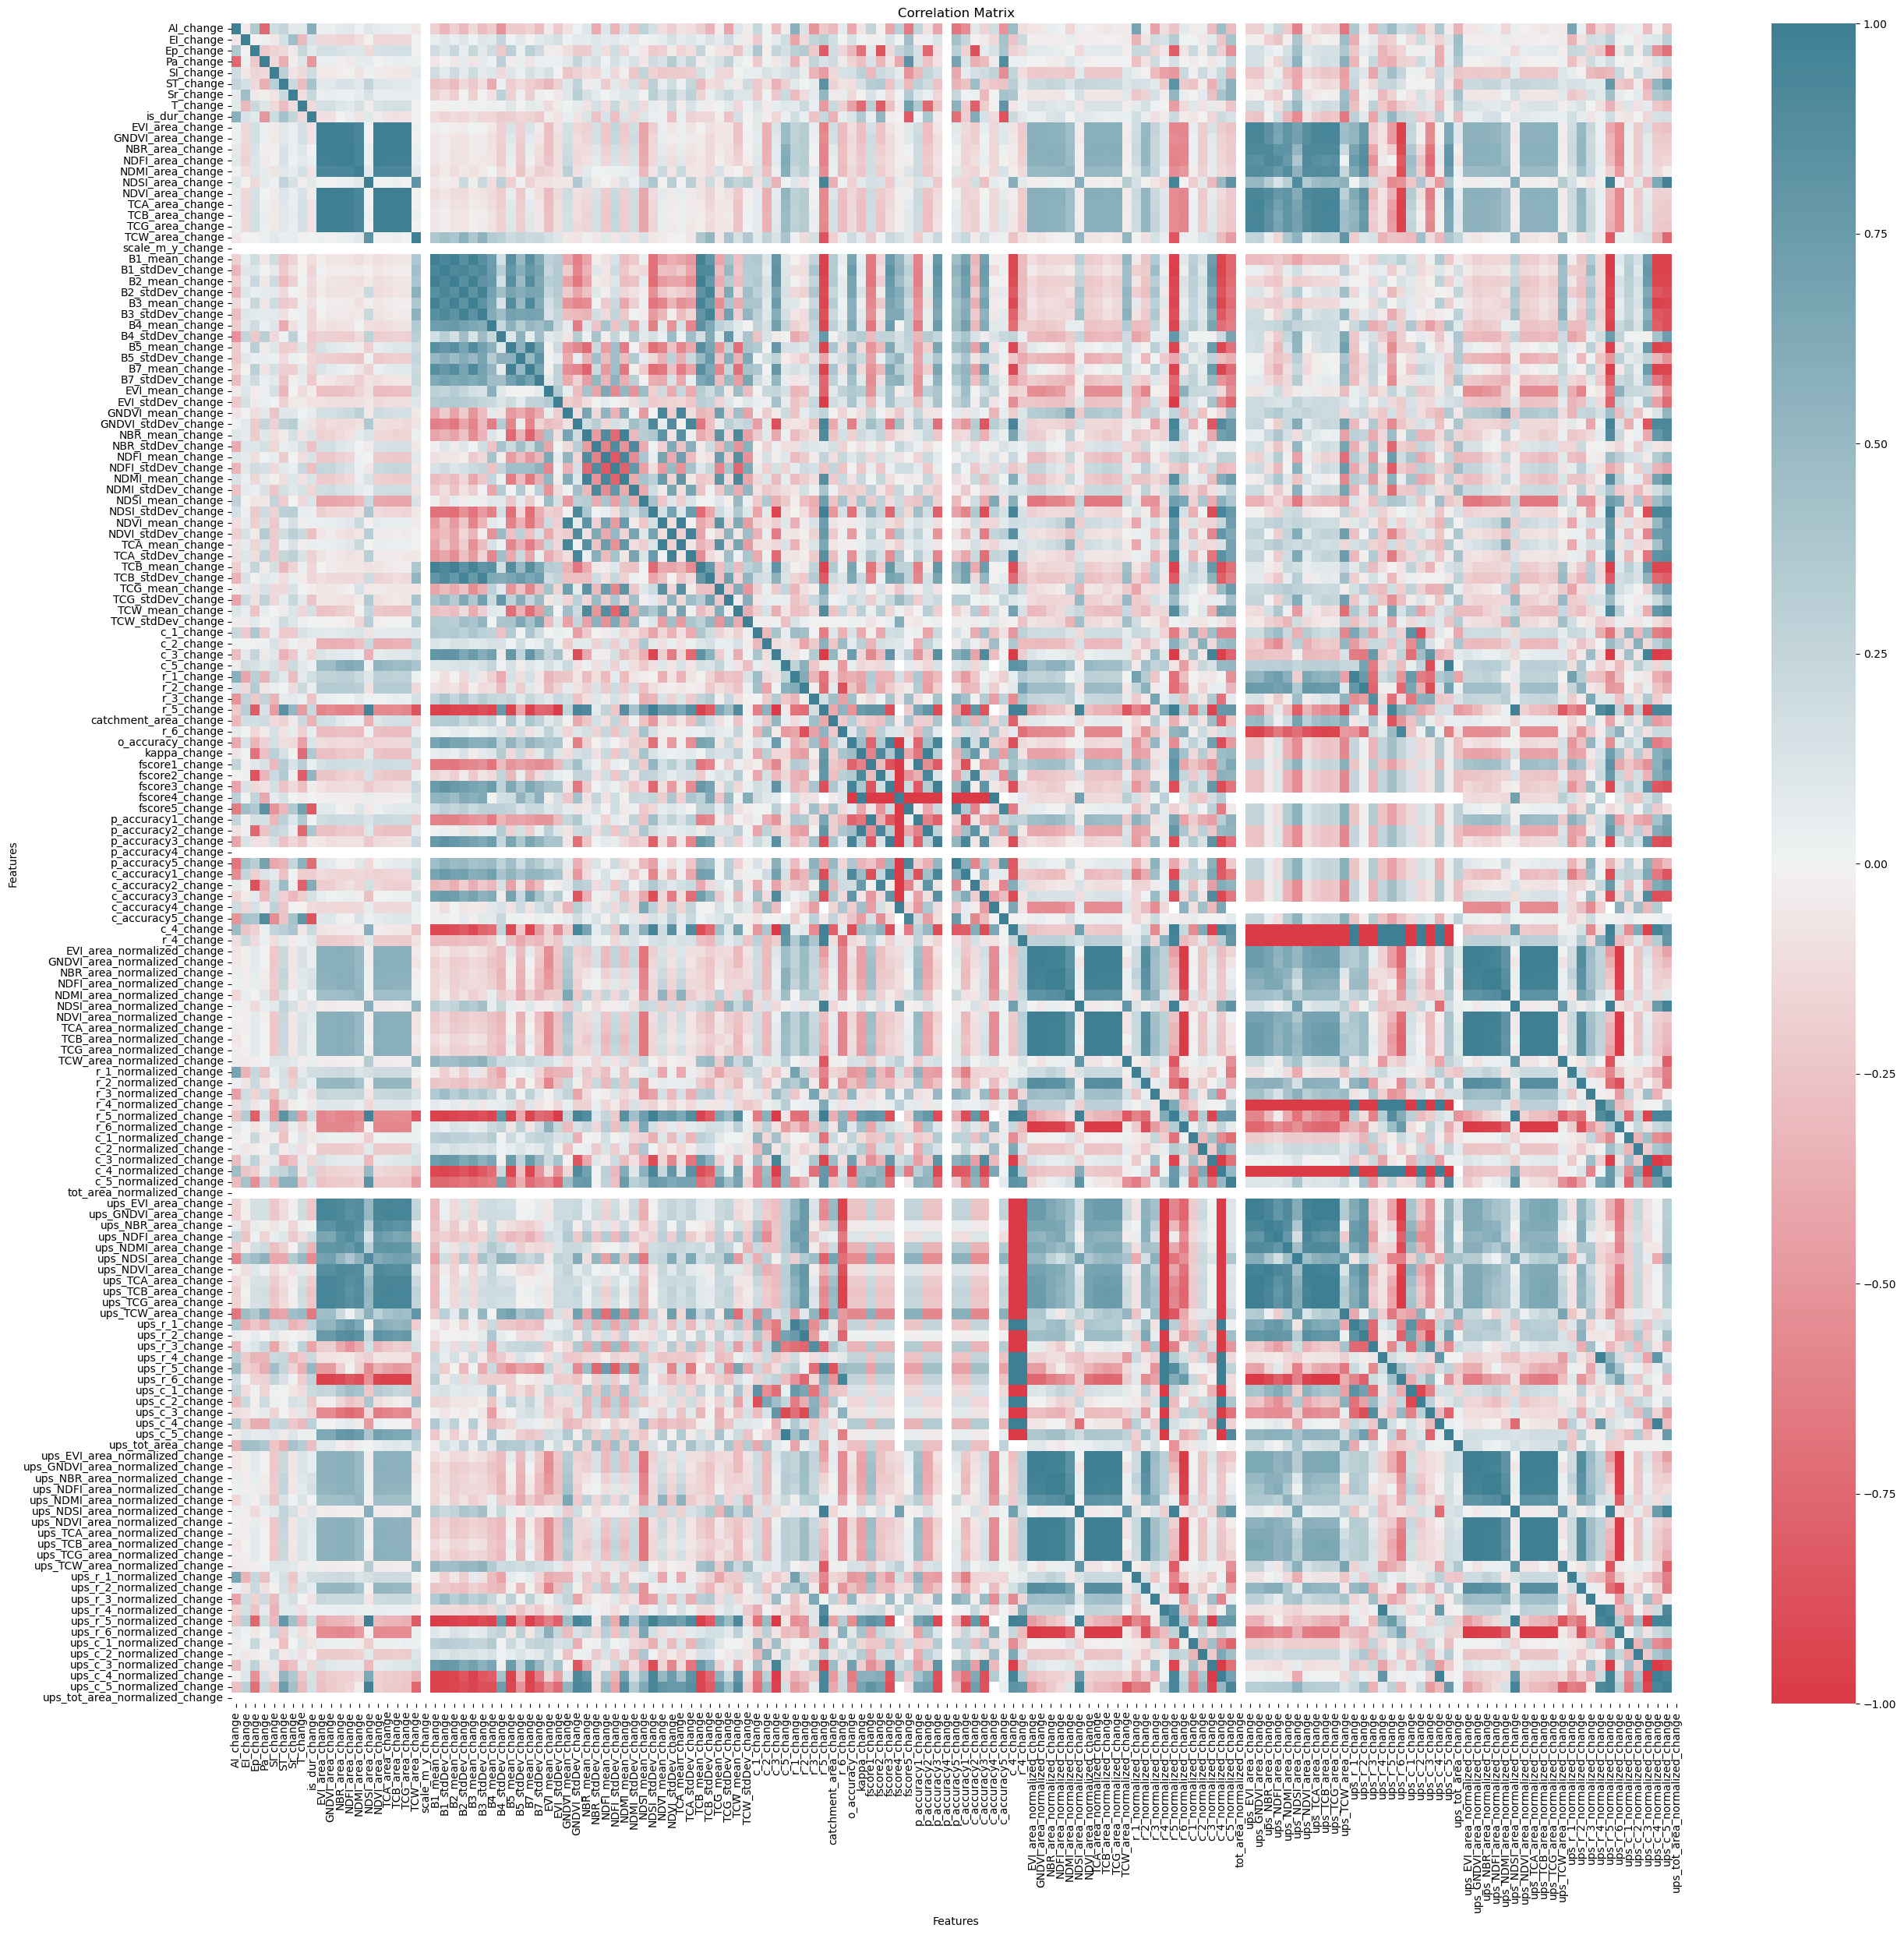

In [1092]:
# Select only columns ending with '_change'
filtered_df = big_merge.filter(regex='_change$')

# Drop columns containing 'p10' or 'p90'
filtered_df = filtered_df.drop(columns=list(filtered_df.filter(regex='p10|p90').columns.values) +['tot_area_change'])


corr = filtered_df.corr('pearson')

# create the plot with a larger size
fig, ax = plt.subplots(figsize=(30, 28))

# create a custom color palette
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# drop columns containing p90
corr = corr.loc[:, ~corr.columns.str.contains('p90')]

# create the heatmap with the custom color palette and X labels on top
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, ax=ax, 
            xticklabels=True, yticklabels=True)

# set the plot title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Features')
ax.set_ylabel('Features')

# rotate the tick labels
plt.xticks(rotation=90)

# show the plot
plt.show()

C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


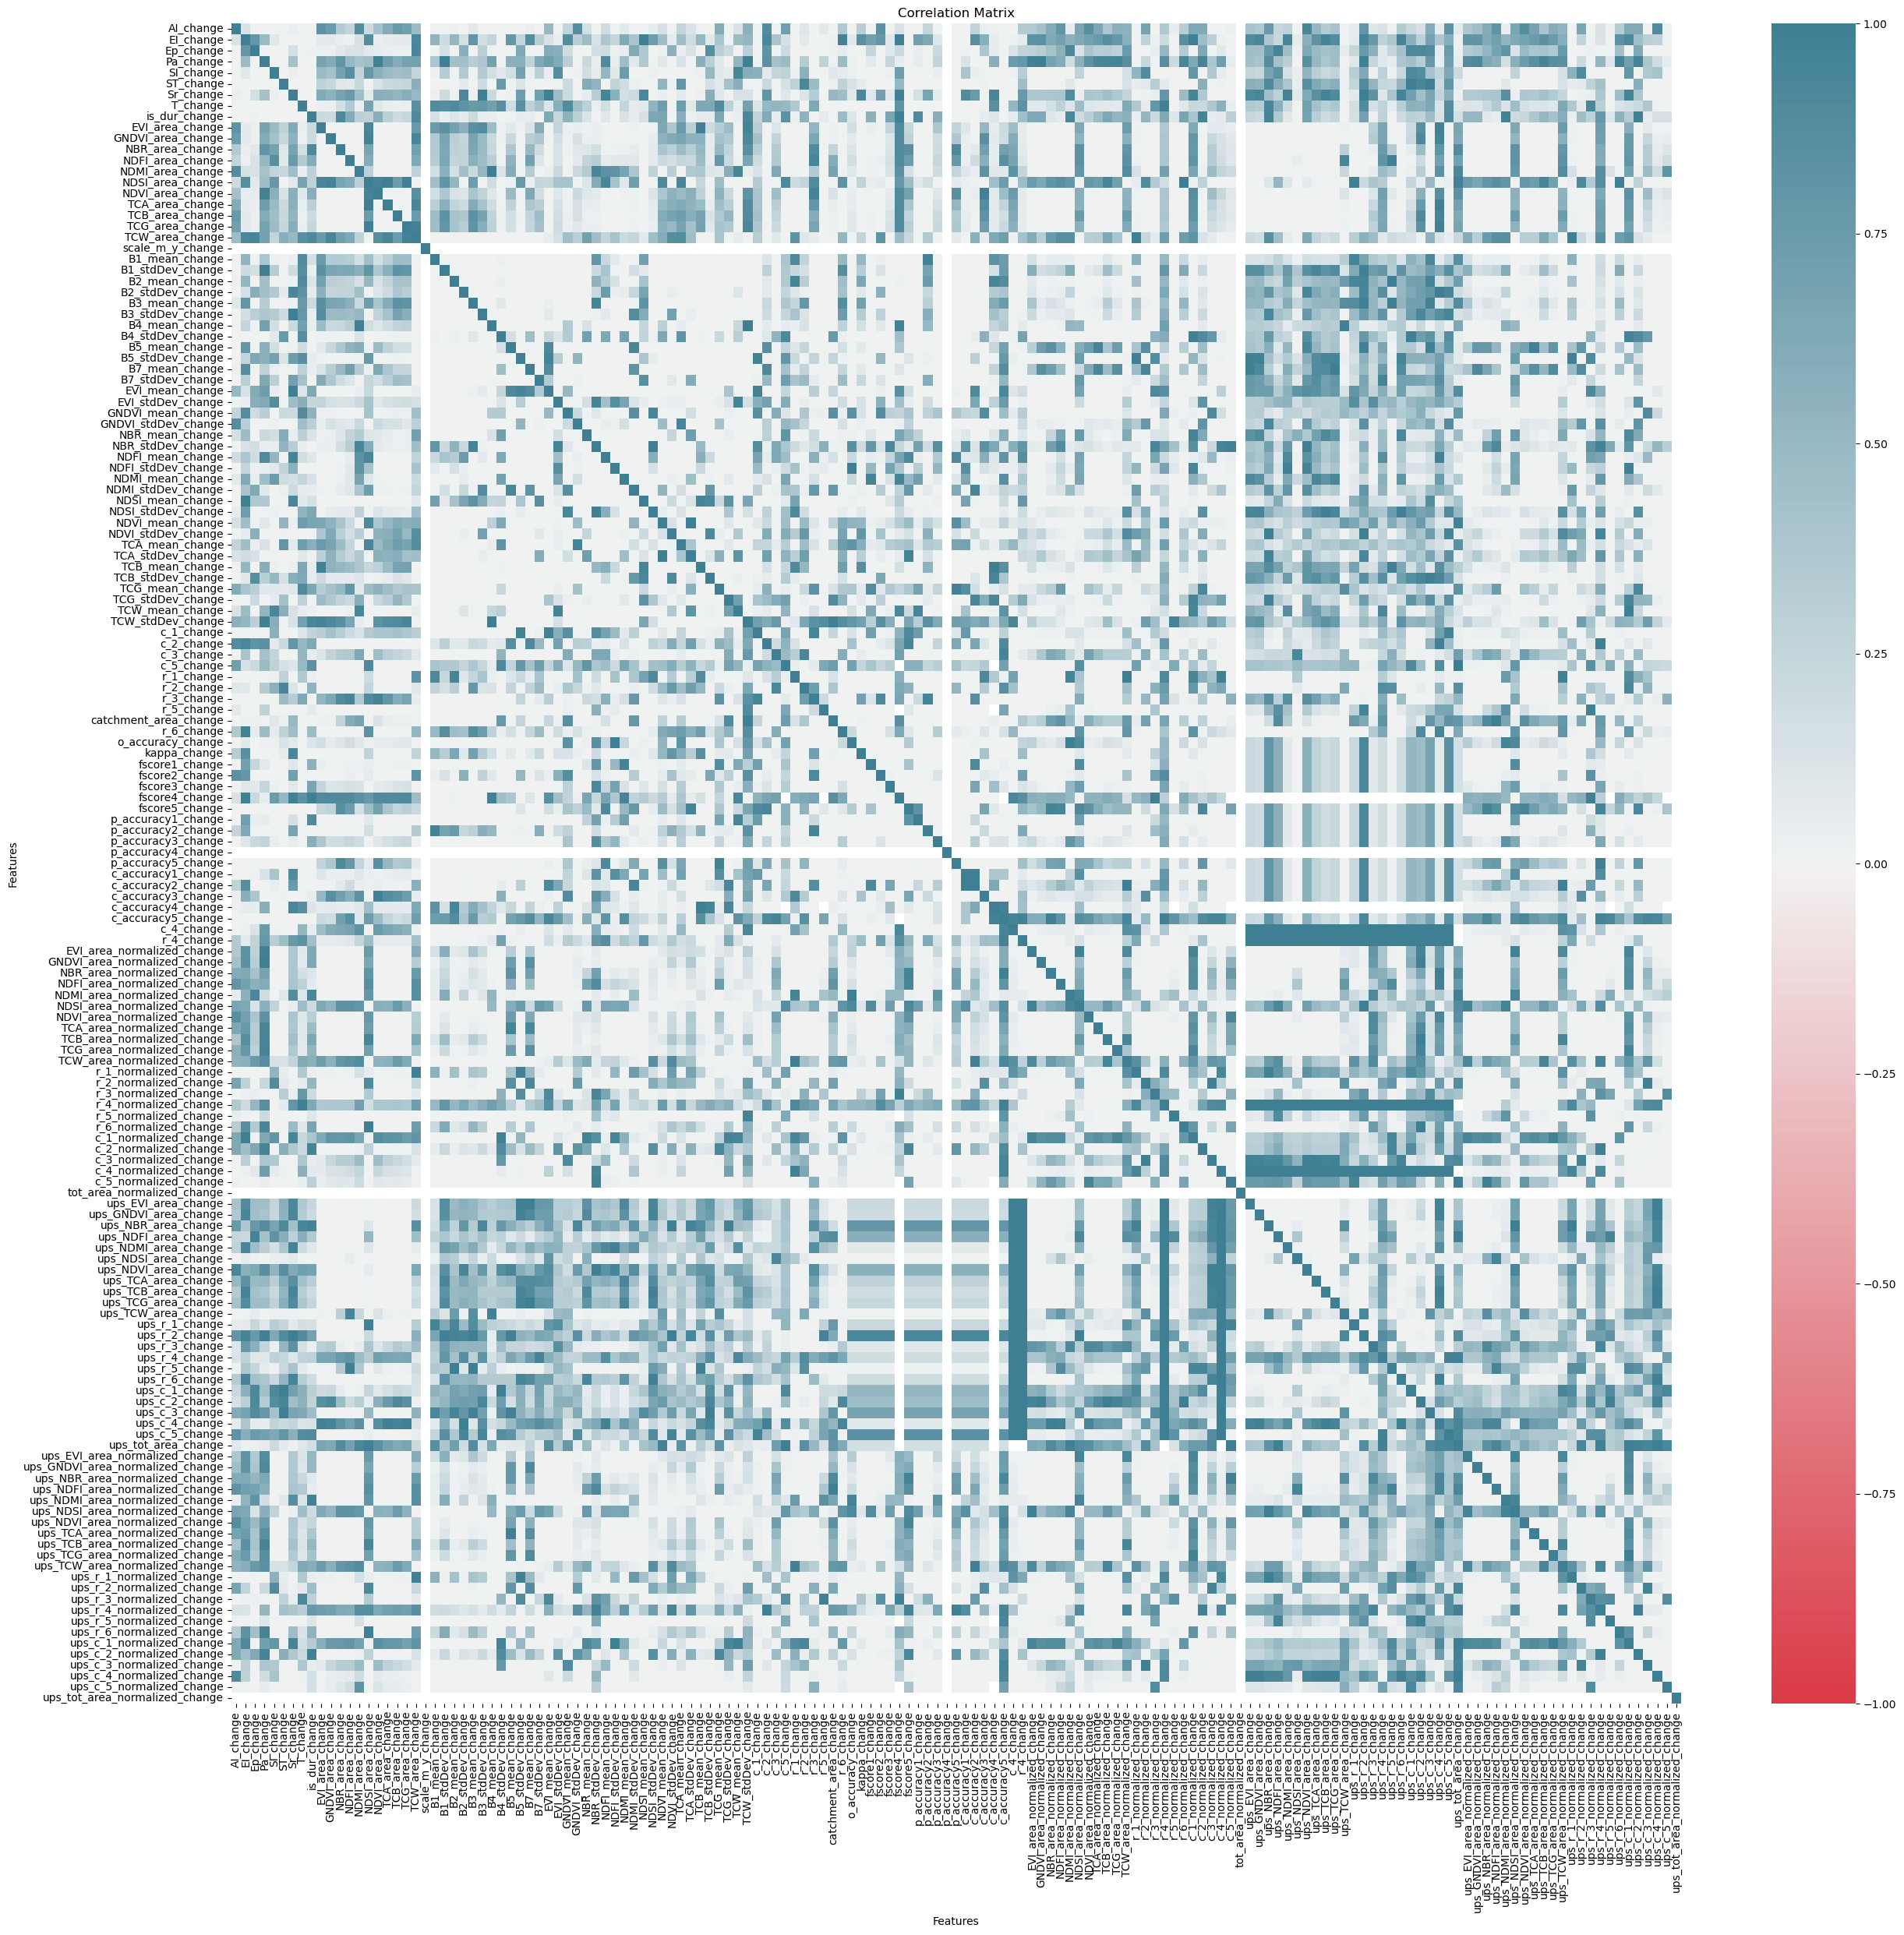

In [1093]:
corr_p = filtered_df.corr(method=pearsonr_pval)

# create the plot with a larger size
fig, ax = plt.subplots(figsize=(30, 28))

# create a custom color palette
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# drop columns containing p90
corr_p = corr_p.loc[:, ~corr.columns.str.contains('p90')]

# create the heatmap with the custom color palette and X labels on top
sns.heatmap(corr_p, cmap=cmap, vmin=-1, vmax=1, ax=ax, 
            xticklabels=True, yticklabels=True)

# set the plot title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Features')
ax.set_ylabel('Features')

# rotate the tick labels
plt.xticks(rotation=90)

# show the plot
plt.show()

In [1094]:
import pandas as pd
from scipy.stats import pearsonr


keys_to_drop = ['fscore1','fscore2','fscore3','fscore4','fscore5','c_accuracy1','c_accuracy2','c_accuracy3','c_accuracy4','c_accuracy5', 'accuracy']
df = filtered_df.loc[:, ~filtered_df.columns.str.contains('score')]
df = df.loc[:, ~df.columns.str.contains('accuracy')]
df = df.loc[:, ~df.columns.str.contains('kappa')]
df = df.loc[:, ~df.columns.str.contains('tot')]


dep_vars = ['AI_change','EI_change','Ep_change','Pa_change','SI_change','ST_change','Sr_change','T_change','is_dur_change',]

# calculate the correlation matrix
corr_matrix = df.corr()


# create an empty dataframe to store the top 5 correlations for each dependent variable
top_corrs = pd.DataFrame(columns=['Dependent Variable', 'Independent Variable', 'Correlation Coefficient', 'P-value'])

# loop through each dependent variable
for dep_var in dep_vars:
    # get the correlations for this dependent variable
    dep_var_corrs = corr_matrix.loc[dep_var]
    
    # sort the correlations in descending order
    sorted_corrs = np.abs(dep_var_corrs).sort_values(ascending=False)
    
    sorted_corrs = sorted_corrs[~sorted_corrs.index.isin(dep_vars)]
    
    
    # loop through the sorted correlations and add the top 5 significant ones to the dataframe
    for i, (ind_var, corr_val) in enumerate(sorted_corrs.iteritems()):
        if i >= 5:
            break
        
        if ind_var == dep_var:
            continue
        try:
            xy = df[[ind_var, dep_var]].dropna()
            
        except:
            continue
        if len(xy) > 17:
        
            slope, intercept, r_value, p_value, std_err = linregress(xy[ind_var], xy[dep_var])
            r_squared = r_value ** 2

            if p_value < 0.05:
                top_corrs = pd.concat([top_corrs, pd.DataFrame({'Dependent Variable': dep_var,
                                                                 'Independent Variable': ind_var,
                                                                 'Correlation Coefficient': corr_val,
                                                                 'R-squared': r_squared,
                                                                 'P-value': p_value}, index=[0])],
                                      ignore_index=True)
        else:
            continue

# sort the dataframe by the correlation coefficient in descending order
top_corrs = top_corrs.sort_values(by='Correlation Coefficient', ascending=False)

display(top_corrs)

# display the top 5 correlations for each dependent variable
for dep_var in dep_vars:
    print(f"Top correlations for {dep_var}:")
    display(top_corrs[top_corrs['Dependent Variable'] == dep_var])
    print("\n")

Dependent Variable       Independent Variable  Correlation Coefficient  \
21          ST_change                 r_5_change                 0.842648   
22          ST_change      r_5_normalized_change                 0.834152   
8           Ep_change                 r_5_change                 0.807834   
9           Ep_change      r_5_normalized_change                 0.799420   
23          ST_change  ups_r_5_normalized_change                 0.776118   
10          Ep_change  ups_r_5_normalized_change                 0.752146   
24          ST_change  ups_c_5_normalized_change                 0.732628   
11          Ep_change  ups_c_5_normalized_change                 0.697587   
0           AI_change      r_1_normalized_change                 0.673151   
1           AI_change  ups_r_1_normalized_change                 0.671665   
2           AI_change        ups_TCW_area_change                 0.668703   
35      is_dur_change        ups_TCW_area_change                 0.650152   
3           AI_change       ups_NDSI_area_change                 0.597565   
13          Pa_change        ups_TCW_area_change                 0.575539   
4           AI_change                 r_1_change                 0.573608   
26          Sr_change      c_5_normalized_change                 0.569651   
25          ST_change      c_5_normalized_change                 0.558835   
36      is_dur_change       ups_NDSI_area_change                 0.558791   
14          Pa_change       ups_NDSI_area_change                 0.548972   
12          Ep_change      c_5_normalized_change                 0.527191   
27          Sr_change      r_5_normalized_change                 0.526625   
28          Sr_change                 r_5_change                 0.517230   
37      is_dur_change             ups_r_5_change                 0.513599   
31           T_change       ups_NDSI_area_change                 0.506380   
32           T_change        ups_TCW_area_change                 0.496996   
16          SI_change      r_5_normalized_change                 0.489019   
33           T_change                 r_5_change                 0.474638   
5           EI_change        ups_TCW_area_change                 0.473079   
17          SI_change                 r_5_change                 0.464626   
34           T_change      r_5_normalized_change                 0.453549   
18          SI_change        ups_TCW_area_change                 0.451844   
29          Sr_change        ups_TCW_area_change                 0.450138   
19          SI_change             ups_r_5_change                 0.442862   
20          SI_change      r_4_normalized_change                 0.441665   
30          Sr_change  ups_r_5_normalized_change                 0.435894   
38      is_dur_change             ups_r_3_change                 0.423908   
6           EI_change                 r_1_change                 0.418214   
7           EI_change      c_5_normalized_change                 0.414434   
39      is_dur_change      catchment_area_change                 0.346061   
15          Pa_change         NDVI_stdDev_change                 0.341878   

         P-value  R-squared  
21  8.953895e-18   0.710056  
22  3.812299e-17   0.695809  
8   2.114239e-15   0.652595  
9   6.714785e-15   0.639072  
23  4.407895e-17   0.602358  
10  1.351560e-15   0.565724  
24  1.666810e-14   0.536744  
11  9.114580e-13   0.486627  
0   7.125366e-21   0.453133  
1   9.320678e-21   0.451133  
2   1.373171e-04   0.447164  
35  2.417142e-04   0.422698  
3   9.970632e-04   0.357084  
13  1.683573e-03   0.331245  
4   2.070404e-14   0.329026  
26  1.350838e-06   0.324503  
25  2.352487e-06   0.312296  
36  2.448452e-03   0.312247  
14  3.022724e-03   0.301370  
12  1.071063e-05   0.277930  
27  1.098973e-05   0.277334  
28  1.673609e-05   0.267527  
37  6.142091e-03   0.263784  
31  7.034959e-03   0.256421  
32  8.356811e-03   0.247005  
16  5.506195e-05   0.239139  
33  9.716956e-05   0.225281  
5   1

Top correlations for AI_change:


Dependent Variable       Independent Variable  Correlation Coefficient  \
0          AI_change      r_1_normalized_change                 0.673151   
1          AI_change  ups_r_1_normalized_change                 0.671665   
2          AI_change        ups_TCW_area_change                 0.668703   
3          AI_change       ups_NDSI_area_change                 0.597565   
4          AI_change                 r_1_change                 0.573608   

        P-value  R-squared  
0  7.125366e-21   0.453133  
1  9.320678e-21   0.451133  
2  1.373171e-04   0.447164  
3  9.970632e-04   0.357084  
4  2.070404e-14   0.329026



Top correlations for EI_change:


Dependent Variable   Independent Variable  Correlation Coefficient  \
5          EI_change    ups_TCW_area_change                 0.473079   
6          EI_change             r_1_change                 0.418214   
7          EI_change  c_5_normalized_change                 0.414434   

        P-value  R-squared  
5  1.269555e-02   0.223804  
6  1.112847e-07   0.174903  
7  8.116207e-04   0.171756



Top correlations for Ep_change:


Dependent Variable       Independent Variable  Correlation Coefficient  \
8           Ep_change                 r_5_change                 0.807834   
9           Ep_change      r_5_normalized_change                 0.799420   
10          Ep_change  ups_r_5_normalized_change                 0.752146   
11          Ep_change  ups_c_5_normalized_change                 0.697587   
12          Ep_change      c_5_normalized_change                 0.527191   

         P-value  R-squared  
8   2.114239e-15   0.652595  
9   6.714785e-15   0.639072  
10  1.351560e-15   0.565724  
11  9.114580e-13   0.486627  
12  1.071063e-05   0.277930



Top correlations for Pa_change:


Dependent Variable  Independent Variable  Correlation Coefficient  \
13          Pa_change   ups_TCW_area_change                 0.575539   
14          Pa_change  ups_NDSI_area_change                 0.548972   
15          Pa_change    NDVI_stdDev_change                 0.341878   

     P-value  R-squared  
13  0.001684   0.331245  
14  0.003023   0.301370  
15  0.000005   0.116880



Top correlations for SI_change:


Dependent Variable   Independent Variable  Correlation Coefficient  \
16          SI_change  r_5_normalized_change                 0.489019   
17          SI_change             r_5_change                 0.464626   
18          SI_change    ups_TCW_area_change                 0.451844   
19          SI_change         ups_r_5_change                 0.442862   
20          SI_change  r_4_normalized_change                 0.441665   

     P-value  R-squared  
16  0.000055   0.239139  
17  0.000142   0.215877  
18  0.017979   0.204163  
19  0.020701   0.196127  
20  0.000041   0.195068



Top correlations for ST_change:


Dependent Variable       Independent Variable  Correlation Coefficient  \
21          ST_change                 r_5_change                 0.842648   
22          ST_change      r_5_normalized_change                 0.834152   
23          ST_change  ups_r_5_normalized_change                 0.776118   
24          ST_change  ups_c_5_normalized_change                 0.732628   
25          ST_change      c_5_normalized_change                 0.558835   

         P-value  R-squared  
21  8.953895e-18   0.710056  
22  3.812299e-17   0.695809  
23  4.407895e-17   0.602358  
24  1.666810e-14   0.536744  
25  2.352487e-06   0.312296



Top correlations for Sr_change:


Dependent Variable       Independent Variable  Correlation Coefficient  \
26          Sr_change      c_5_normalized_change                 0.569651   
27          Sr_change      r_5_normalized_change                 0.526625   
28          Sr_change                 r_5_change                 0.517230   
29          Sr_change        ups_TCW_area_change                 0.450138   
30          Sr_change  ups_r_5_normalized_change                 0.435894   

     P-value  R-squared  
26  0.000001   0.324503  
27  0.000011   0.277334  
28  0.000017   0.267527  
29  0.018472   0.202624  
30  0.000059   0.190004



Top correlations for T_change:


Dependent Variable   Independent Variable  Correlation Coefficient  \
31           T_change   ups_NDSI_area_change                 0.506380   
32           T_change    ups_TCW_area_change                 0.496996   
33           T_change             r_5_change                 0.474638   
34           T_change  r_5_normalized_change                 0.453549   

     P-value  R-squared  
31  0.007035   0.256421  
32  0.008357   0.247005  
33  0.000097   0.225281  
34  0.000214   0.205707



Top correlations for is_dur_change:


Dependent Variable   Independent Variable  Correlation Coefficient  \
35      is_dur_change    ups_TCW_area_change                 0.650152   
36      is_dur_change   ups_NDSI_area_change                 0.558791   
37      is_dur_change         ups_r_5_change                 0.513599   
38      is_dur_change         ups_r_3_change                 0.423908   
39      is_dur_change  catchment_area_change                 0.346061   

     P-value  R-squared  
35  0.000242   0.422698  
36  0.002448   0.312247  
37  0.006142   0.263784  
38  0.027555   0.179698  
39  0.000003   0.119758

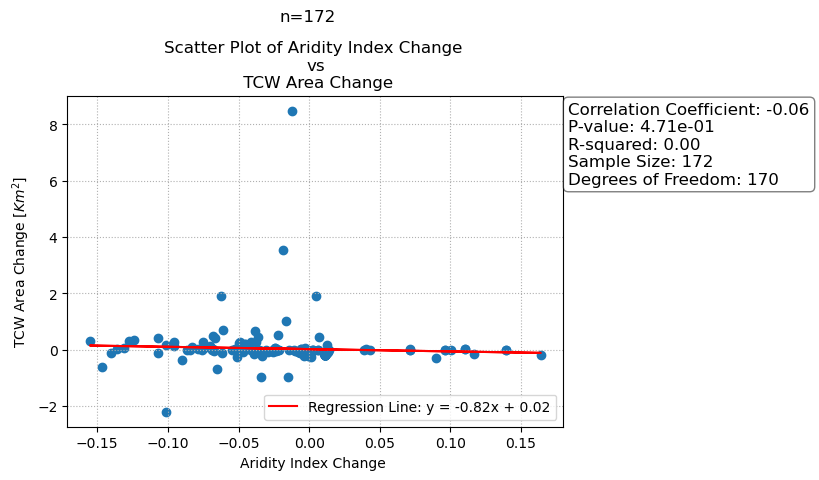

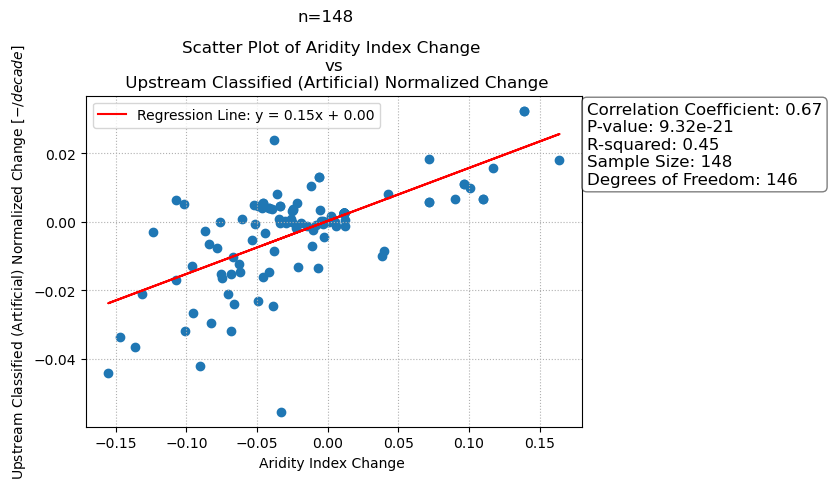

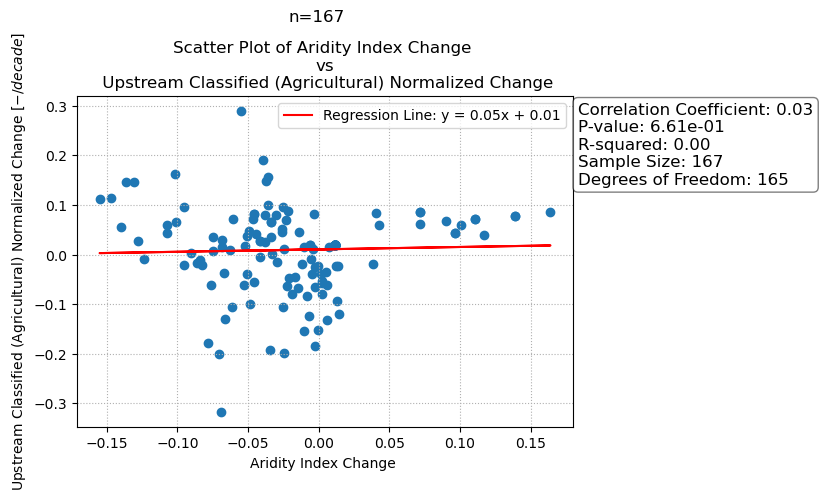

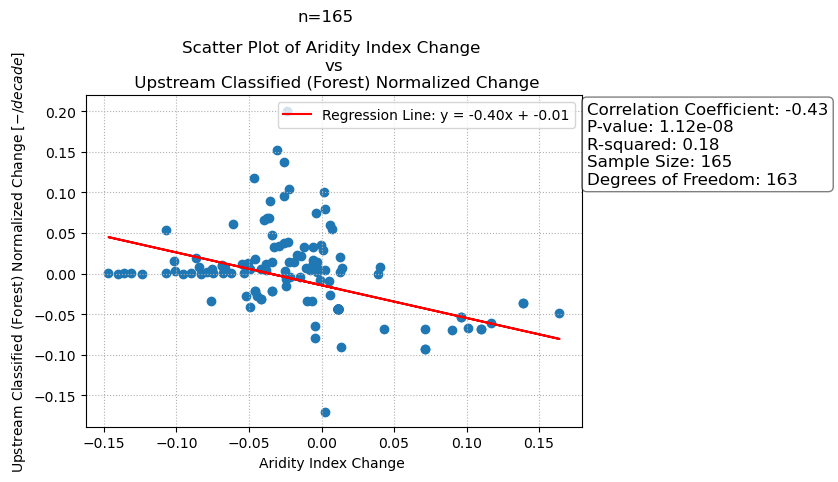

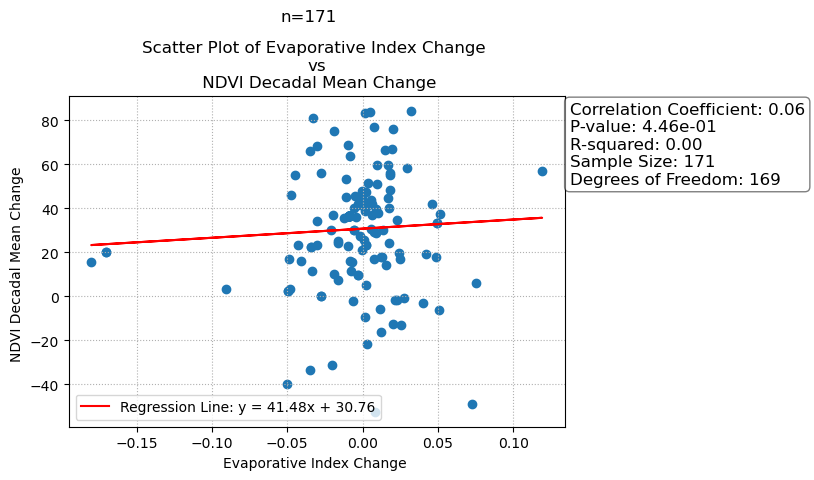

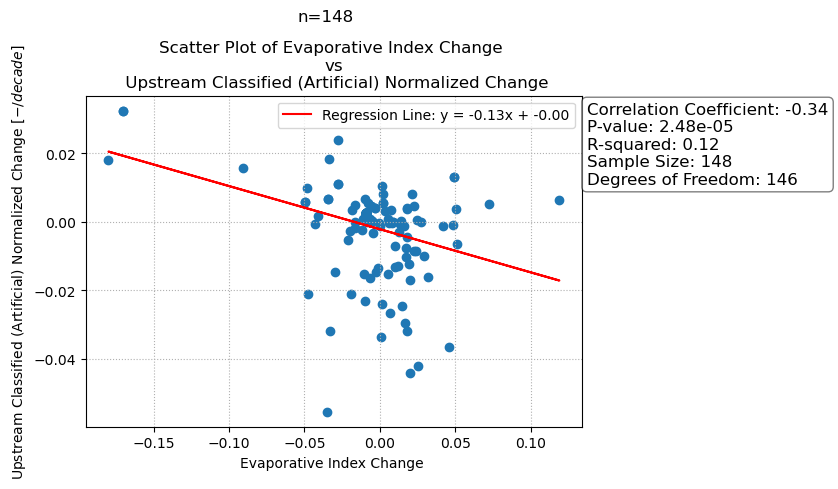

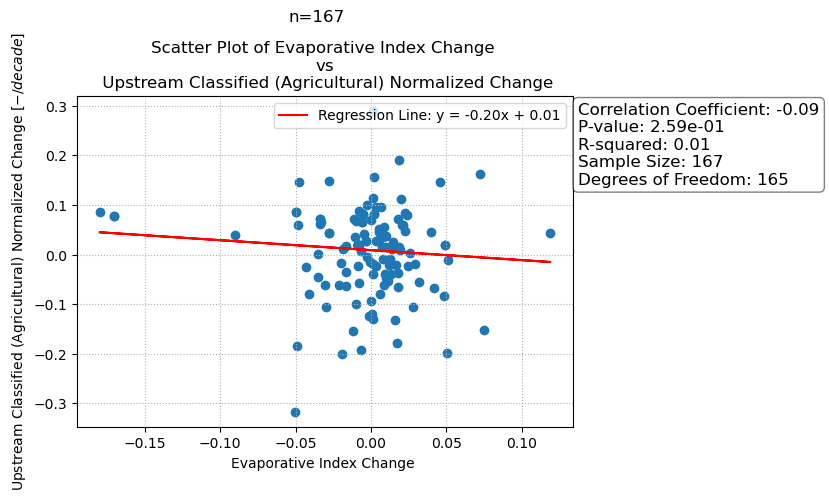

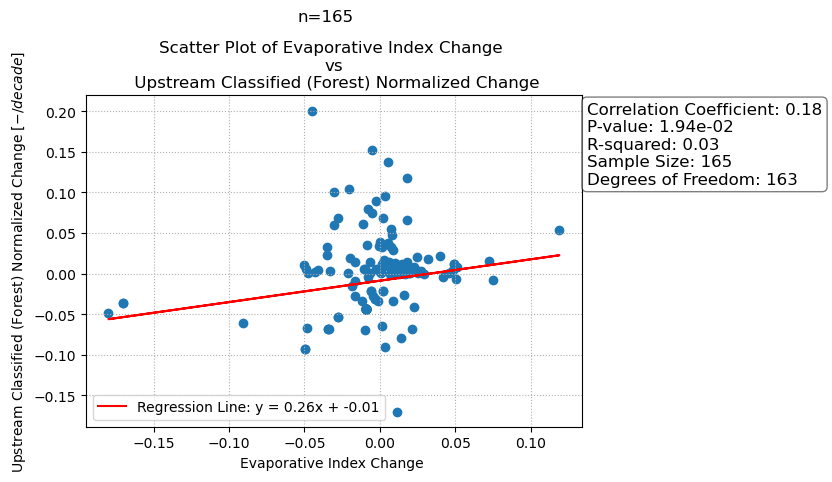

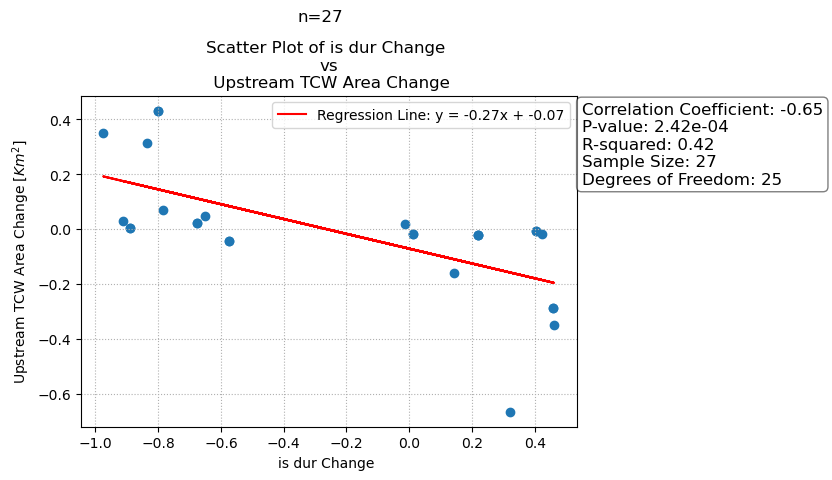

In [1099]:

def translate_col_name(col_name: str):
    # Define a dictionary mapping column names to their plain English translations
    col_name_dict = {
        'AI': 'Aridity Index',
        'EI': 'Evaporative Index',
        'Ep': 'Potential Evaporation',
        'Pa': 'Precipitation',
        'ST': 'Seasonality Timing',
        'SI': 'Seasonality Index',
        'Sr': 'Root-zone Storage Capacity',
        'T': 'Temperature',
        'is_dur': 'Interstorm duration',
        'omega': 'Budyko curve (Fu) parameter',
        'change': 'Change',
        'normalized': 'Normalized',
        'p10': '10th percentile',
        'p90': '90th percentile',
        'catchment': 'Catchment',
        'mean': 'Decadal Mean', 
        'ups':'Upstream',
        'area': 'Area',
        'r':'Classified',
        'c':'CORINE',
        '1':'(Artificial)',
        '2':'(Agricultural)',
        '3':'(Forest)',
        '4':'(Wetlands)',
        '5':'(Waterbodies)',
        
        
    }
    
    # Split the column name into words
    words = col_name.split('_')
    
    # Translate each word in the column name
    translated_words = [col_name_dict.get(word, word) for word in words]

    # Join the translated words and return the result
    return ' '.join(translated_words)

def get_unit_of_measurement(s):
    if 'area' in s:
        return '[$Km^2$]'
    elif 'Evaporative' in s:
        return '[$-/decade$]'
    elif 'normalized' in s:
        return '[$-/decade$]'
    elif 'Potential Evaporation' in s:
        return '[$mm/decade$]'
    elif 'Precipitation' in s:
        return '[$mm$]'
    elif 'T' in s:
        return '[$^o^C$]'
    elif 'Root-zone' in s:
        return '[$mm$]'
    else:
        return ''

def scatter_vars(df, x, y):
    plt.xlabel(f'{translate_col_name(x)} {get_unit_of_measurement(x)}')
    plt.ylabel(f'{translate_col_name(y)} {get_unit_of_measurement(y)}')
    plt.title(f'Scatter Plot of {translate_col_name(x)} \nvs\n {translate_col_name(y)}')
    
    mask = (~df[x].isnull()) & (~df[y].isnull())
    x = df.loc[mask, x]
    y = df.loc[mask, y]
    plt.scatter(x, y)
    plt.suptitle(f'n={len(x)}')
    
    # Calculate and display the correlation coefficient and its significance level
    r, pval = pearsonr(x, y)
    
    # Fit and display the regression line and its equation
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
    reg_line = f'Regression Line: y = {slope:.2f}x + {intercept:.2f}'
    plt.plot(x, slope * x + intercept, color='r', label=reg_line)
    plt.legend()
    plt.subplots_adjust(top=0.8)
    
    # Calculate and display the coefficient of determination (R-squared) and adjusted R-squared
    rsq = r**2
    n = len(x)
    df = n - 2
    #adj_rsquared = 1 - ((1 - rsq) * (n - 1)) / (n - 1 - 1)
    textstr = f'Correlation Coefficient: {r:.2f}\nP-value: {pval:.2e}\nR-squared: {rsq:.2f}\nSample Size: {n}\nDegrees of Freedom: {df}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.01, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
    # plt.tight_layout()
    
    plt.grid(linestyle=':')
    #plt.savefig('scatter_plot.png', bbox_inches='tight')
    plt.show()

scatter_vars(big_merge, 'AI_change', 'TCW_area_change',)
scatter_vars(big_merge, 'AI_change', 'ups_r_1_normalized_change',)
scatter_vars(big_merge, 'AI_change', 'ups_r_2_normalized_change',)
scatter_vars(big_merge, 'AI_change', 'ups_r_3_normalized_change',)
# scatter_vars(big_merge, 'EI_change','ups_TCW_area_normalized_change',)

scatter_vars(big_merge, 'EI_change', 'NDVI_mean_change',)
scatter_vars(big_merge, 'EI_change', 'ups_r_1_normalized_change',)
scatter_vars(big_merge, 'EI_change', 'ups_r_2_normalized_change',)
scatter_vars(big_merge, 'EI_change', 'ups_r_3_normalized_change',)
# scatter_vars(big_merge, 'SI_change',	'ups_r_3_normalized_change')
# scatter_vars(big_merge, 'is_dur_change',	'GNDVI_stdDev_change',)
# # scatter_vars(big_merge, 'EI_change','ups_NDMI_area_normalized_change')
# scatter_vars(big_merge, 'ups_r_2_normalized_change','ups_c_2_normalized_change')
scatter_vars(big_merge, 'is_dur_change',	'ups_TCW_area_change')

In [820]:
display(big_merge[['catchment','dataset','ups_r_1_normalized_change']].loc[big_merge['dataset']=='CAMELS_GB'])

catchment    dataset  ups_r_1_normalized_change
66       8009  CAMELS_GB                        NaN
68       8009  CAMELS_GB                        NaN
70      17005  CAMELS_GB                        NaN
72      17005  CAMELS_GB                        NaN
74      18001  CAMELS_GB                        NaN
..        ...        ...                        ...
436     79004  CAMELS_GB                        NaN
438     93001  CAMELS_GB                        NaN
440     93001  CAMELS_GB                        NaN
442     94001  CAMELS_GB                        NaN
444     94001  CAMELS_GB                        NaN

[189 rows x 3 columns]

In [506]:
ex_df = pd.read_excel(path + '00000000000000000005' +'_decadal.xlsx', index_col=0, parse_dates=True)

NameError: name 'path' is not defined

## Plotting All Bands and Indices

expensive plotting loop

In [55]:
EE_list = indexes.system_index.to_list()  #Read and list the catchment IDs used

index_list = [i for i in zip(EE_list, catchment_list)]

## Three decadal periods for which parameters are calculated from Water Balance

This is individual for the Meuse basin dataset. Camels GB for example is longer. 

--> 1986-1995 -- 1996 - 2005 -- 2006 - 2015

we take the following slices:

--> [ 11 ] -- [ 21 ] -- [ 31 ]

In [56]:
#The Keys used here are the bands and indices from the decadal average table i.e. B1 --> WETNESS

keys_list = pd.read_excel(path + index_list[0][0] +'_decadal.xlsx').keys().to_list()  

#fignum+=1

#plt.figure(fignum, figsize=(20, 10))
bracket1, bracket2, bracket3 = '1986 - 1995', '1996 - 2005', '2006 - 2015'
slice1, slice2, slice3 = 11, 21, 31


mk_list = []   # accepts the modified mann-kendall list with id and name

br_means = []  # the values conforming with the slices defined by the LT water balance effort

for keys in keys_list[1:]:
    
    fignum+=1
       
    '''
    Looping through the keys (bands and indices generated from the landsat surface reflectances)
    
    --> inner loop says: for this key, loop through each file and chart the timeseries
    
    charting is slow and commented out, but will overlay all timeseries available if run
    
    '''
#    plt.figure(fignum, figsize=(20,10))
#    plt.title(keys)
    
    for ind in index_list:
        df = pd.read_excel(path + ind[0] +'_decadal.xlsx', index_col=0, parse_dates=True)
        
        loc = df.loc[:, keys]
        
        br_means.append([ind[0], keys, ind[1], loc[slice1], loc[slice2], loc[slice3], ])
        
#        x = df.loc[:, keys_list[0]]
#        plt.plot(loc, label=ind[1])
#        plt.legend(bbox_to_anchor=(1,1),ncol=2, loc="upper left")
        
        '''
        Performing the Mann Kendall test on each timeseries is and interesting overview of the 
        trends in each band so we can see the distribution of trends and uncertainty
        '''
        
        temp_mk_list = list(mann_kendall.original_test(loc))
        temp_mk_list.append(keys)
                    
        temp_mk_list.append(ind[0])
                    
        temp_mk_list.append(ind[1])
                    
        mk_list.append(temp_mk_list)

# What to do with these averages? 


* Are there any correlations between the catchment spectral indices and their underlying LT waterbalance data


In [57]:
'''
Creating the spectral average table with matching brakets of dates
'''

headers = [f'system_index', f'band', f'catchment', f'{bracket1}', f'{bracket2}', f'{bracket3}']

datatype = {f'system_index': str,
            f'band':str, 
            f'catchment':str, 
            f'{bracket1}':float, 
            f'{bracket2}':float, 
            f'{bracket3}':float,}

decadal_df = pd.DataFrame(br_means, columns=headers).astype(datatype)

d_groups = decadal_df.groupby(['band']).groups

'''
import the id name tuple as a check against mismatched system indices.

manually pasted as joining over the catchment name string was inconsistent.
'''

headers = [f'system_index', 
           f'catchment']

datatype = {f'system_index': str,
            f'catchment':str,}

id_name = pd.DataFrame(id_name_tup, columns=headers).astype(datatype)

FR = pd.read_csv('FR.csv', skipinitialspace=True)
BE = pd.read_csv('BE.csv', skipinitialspace=True)

FR_key_set = set(FR.keys())
BE_key_set = set(BE.keys())

key_intersection = FR_key_set.intersection(BE_key_set)

'''
make a scatter of omega vs NDVI
'''

catchments_LS = decadal_df.iloc[d_groups['ndvi']].system_index

catchments_FR = FR.system_index

catchments_BE = BE.system_index

intersection1, intersection2 = set(catchments_BE).intersection(set(catchments_LS)), set(catchments_FR).intersection(set(catchments_LS))

catchment_union = intersection1.union(intersection2)  #current analysis of LTWB yields 17 catchments overall



In [58]:
WB_indices = ['AI',
# 'AI_change',
 'EI',
# 'EI deviation',
# 'EI deviation past decades',
# 'EI expected',
# 'EI expected past decades',
 'Epa',
# 'Epa_change',
 'P',
 'Pa',
# 'Pa_change',
 'SI',
# 'SI_change',
 'ST',
# 'ST_change',
# 'Sr',
# 'Sr deviation',
# 'Sr expected',
# 'Sr relative',
 'T',
# 'T_change',
 'is_dur',
# 'is_dur_change',
 'omega',]
# 'omega past decades',]

In [59]:
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

keys_list

['Unnamed: 0',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B7',
 'ndvi',
 'evi',
 'nbr',
 'ndmi',
 'gndvi',
 'ndbi',
 'BRIGHTNESS',
 'GREENNESS',
 'WETNESS']

In [61]:
df_all, prs_r, p = combine_decadal_tables(WB_indices[0:], keys_list[1:])# for i in keys_list[7:]][0]
df_all.to_excel(f'meuse/{dataset}_all_decadal_indices_combined_{output_version}.xlsx')
prs_r.to_excel(f'meuse/{dataset}_all_decadal_indices_r_values_{output_version}.xlsx')
prs_r.to_excel(f'meuse/{dataset}_all_decadal_indices_p_values_sorted_{output_version}.xlsx')

df_all

SID 42
country_code 42
catchment_name 42
decade_ending 42
AI 42
EI 42
SR 42


system_index country_code  \
0   00000000000000000027           FR   
1   0000000000000000001c           FR   
2   00000000000000000023           FR   
3   00000000000000000026           FR   
4   00000000000000000028           FR   
5   0000000000000000002b           FR   
6   0000000000000000002a           FR   
7   00000000000000000029           FR   
8   00000000000000000027           FR   
9   0000000000000000001c           FR   
10  00000000000000000023           FR   
11  00000000000000000026           FR   
12  00000000000000000028           FR   
13  0000000000000000002b           FR   
14  0000000000000000002a           FR   
15  00000000000000000029           FR   
16  00000000000000000027           FR   
17  0000000000000000001c           FR   
18  00000000000000000023           FR   
19  00000000000000000026           FR   
20  00000000000000000028           FR   
21  0000000000000000002b           FR   
22  0000000000000000002a           FR   
23  00000000000000000029           FR   
24  00000000000000000015           BE   
25  00000000000000000002           BE   
26  00000000000000000019           BE   
27  00000000000000000020           BE   
28  00000000000000000009           BE   
29  0000000000000000000d           BE   
30  0000000000000000000c           BE   
31  00000000000000000013           BE   
32  00000000000000000014           BE   
33  00000000000000000015           BE   
34  00000000000000000002           BE   
35  00000000000000000019           BE   
36  00000000000000000020           BE   
37  00000000000000000009           BE   
38  0000000000000000000d           BE   
39  0000000000000000000c           BE   
40  00000000000000000013           BE   
41  00000000000000000014           BE   

                              catchment_name  decade_ending     LT_AI  \
0                           La Meuse Stenay            1995  0.740743   
1                  La Vence la Francheville            1995  0.557612   
2                          La Bar Cheveuges            1995  0.622561   
3                Le Loison Han-lÃ©s-Juvigny            1995  0.671355   
4                     La Meuse Saint-Mihiel            1995  0.756448   
5                          La Meuse Goncourt           1995  0.752223   
6   Le Mouzon Circourt-sur-Mouzon [Villars]            1995  0.737932   
7       Le Vair Soulosse-sous-Saint-Ã‰lophe            1995  0.739985   
8                           La Meuse Stenay            2005  0.740743   
9                  La Vence la Francheville            2005  0.557612   
10                         La Bar Cheveuges            2005  0.622561   
11               Le Loison Han-lÃ©s-Juvigny            2005  0.671355   
12                    La Meuse Saint-Mihiel            2005  0.756448   
13                         La Meuse Goncourt           2005  0.752223   
14  Le Mouzon Circourt-sur-Mouzon [Villars]            2005  0.737932   
15      Le Vair Soulosse-sous-Saint-Ã‰lophe            2005  0.739985   
16                          La Meuse Stenay            2015  0.740743   
17                 La Vence la Francheville            2015  0.557612   
18                         La Bar Cheveuges            2015  0.622561   
19               Le Loison Han-lÃ©s-Juvigny            2015  0.671355   
20                    La Meuse Saint-Mihiel            2015  0.756448   
21                         La Meuse Goncourt           2015  0.752223   
22  Le Mouzon Circourt-sur-Mouzon [Villars]            2015  0.737932   
23      Le Vair Soulosse-sous-Saint-Ã‰lophe            2015  0.739985   
24                                 Treignes            2005  0.647399   
25                                Huccorgne            2005  0.813393   
26                              Membre Pont            2005  0.532849   
27                                    Chooz            2005  0.679134   
28                                  Warnant            2005  0.746523   
29                                  Hastiere           200

In [62]:
p.replace(1, np.nan)
sorted_p = pd.DataFrame()

for i in p.keys()[7:]:
    sort = pd.DataFrame(p.loc[:, i].sort_values(ascending=False))
    sorted_p[f'{i}_vs'] = sort.index
    sorted_p[f'{i}_p'] = sort.values
sorted_p

B4_vs          B4_p          B5_vs          B5_p          B7_vs  \
0              B4  1.000000e+00             B5  1.000000e+00             B7   
1              SI  7.547882e-01             ST  2.403412e-01      GREENNESS   
2              ST  6.784914e-01             SI  2.395630e-01          omega   
3             Epa  3.833548e-01      GREENNESS  2.289506e-01  decade_ending   
4           omega  3.420641e-01          omega  1.761837e-01             SI   
5   decade_ending  1.855452e-01  decade_ending  1.610575e-01          LT_SR   
6           LT_SR  8.138405e-02          LT_SR  6.165009e-02             ST   
7              EI  3.767383e-02             EI  6.570480e-03            Epa   
8           LT_AI  3.577620e-02          LT_EI  4.302680e-03         is_dur   
9             evi  2.648911e-02            Epa  1.645095e-03             EI   
10           ndvi  2.533471e-02          LT_AI  3.543545e-04          LT_EI   
11          gndvi  1.670667e-02             Pa  1.741914e-04          LT_AI   
12             AI  1.489178e-02              P  1.740468e-04             B4   
13              T  1.100844e-02         is_dur  3.327607e-05             Pa   
14              P  7.760511e-03             AI  1.650907e-05              P   
15             Pa  7.728536e-03             B1  1.478677e-05             AI   
16            nbr  7.191466e-03              T  1.356228e-06              T   
17          LT_EI  4.892682e-03          gndvi  9.422279e-07            evi   
18           ndmi  1.725281e-03           ndvi  4.558375e-07             B1   
19           ndbi  1.725281e-03             B3  9.160759e-09          gndvi   
20             B1  9.106590e-04            evi  2.975016e-09           ndvi   
21             B3  6.118050e-04             B4  1.139558e-09             B2   
22             B2  6.884521e-06             B2  1.045969e-09             B3   
23         is_dur  6.529277e-06            nbr  5.326968e-12           ndbi   
24             B7  5.078832e-06           ndbi  1.351961e-17           ndmi   
25      GREENNESS  2.300399e-06           ndmi  1.351961e-17        WETNESS   
26        WETNESS  2.053078e-06             B7  4.951586e-19             B5   
27             B5  1.139558e-09     BRIGHTNESS  2.026477e-19     BRIGHTNESS   
28     BRIGHTNESS  1.245033e-12        WETNESS  4.595585e-29            nbr   

            B7_p        ndvi_vs        ndvi_p         evi_vs         evi_p  \
0   1.000000e+00           ndvi  1.000000e+00            evi  1.000000e+00   
1   5.306507e-01             ST  5.383742e-01          LT_SR  8.086566e-01   
2   5.255599e-01            Epa  5.011205e-01  decade_ending  7.272549e-01   
3   5.110243e-01          omega  4.487069e-01      GREENNESS  5.043990e-01   
4   1.795096e-01          LT_SR  3.490045e-01          LT_EI  3.341619e-01   
5   1.646990e-01  decade_ending  1.529191e-01             EI  2.772416e-01   
6   1.326258e-01             SI  9.820521e-02             ST  2.261953e-01   
7   2.149948e-02             B4  2.533471e-02             SI  2.064754e-01   
8   2.485882e-03         is_dur  1.115443e-02             B1  3.368357e-02   
9   3.528246e-04      GREENNESS  1.352877e-03         is_dur  2.797846e-02   
10  2.101487e-04              T  5.059351e-04             B4  2.648911e-02   
11  5.964634e-06          LT_EI  4.365910e-04          omega  5.438258e-03   
12  5.078832e-06             AI  4.219147e-04             Pa  2.588006e-03   
13  3.370454e-06             EI  3.209826e-04              P  2.585000e-03   
14  3.357675e-06            evi  1.021735e-04          LT_AI  1.395095e-03   
15  1.790339e-06             Pa  5.088629e-05             B2  1.143648e-03   
16  3.423745e-07              P  5.056368e-05          gndvi  4.473989e-04   
17  1.601595e-08          LT_AI  1.697970e-05             B3  2.625438e-04   
18  3.396497e-09        WETNESS  7.528790e-07           ndvi  1.021735e-04   
19  8.519495e-13             B5  4.558375e-07     BRIGHTNESS  3.509139e-05   
20 

In [63]:
def combine_change_tables(indices:[], keys_list):
    
    '''
    Input sheets like FR are hard to manage with current layout of indices and values in bracketed columns
        
    generate dataframe with columns: 
    [ "system_index", "catchment_name", "decade_ending", "country_code", "index_name"]

    for each index passed, can add new index to the table ["index + n"]
    '''
    key = keys_list[0]
    
    SR_ndvi = decadal_df.iloc[d_groups[key]]
 
    df = pd.merge(SR_ndvi, FR, on='system_index')

    df2 = pd.merge(SR_ndvi, BE, on='system_index')


    x1 = df.loc[:, f'{bracket1}']   #first period NDVI decadal mean for all : catchments

    x2 = df.loc[:, f'{bracket2}']
    AI_2 = df.loc[:, 'AI']
    EI_2 = df.loc[:, 'EI']
    SR_2 = df.loc[:, 'Sr']
    Catchment_x2 = df.loc[:, 'catchment_x']
    decade_x2 = [2005 for i in range(len(x2))]
    SID_x2 = df.loc[:, 'system_index']
    country_x2 = ['FR' for i in range(len(x2))]

    x3 = df.loc[:, f'{bracket3}']
    AI_3 = df.loc[:, 'AI']
    EI_3 = df.loc[:, 'EI']
    SR_3 = df.loc[:, 'Sr']
    SID_x3 = df.loc[:, 'system_index']
    Catchment_x3 = df.loc[:, 'catchment_x']
    decade_x3 = [2015 for i in range(len(x3))]
    country_x3 = ['FR' for i in range(len(x3))]

    x4 = df2.loc[:, f'{bracket2}']

    x5 = df2.loc[:, f'{bracket3}']
    SID_x5 = df2.loc[:, 'system_index']
    Catchment_x5 = df2.loc[:, 'catchment_x']
    AI_5 = df2.loc[:, 'AI']
    EI_5 = df2.loc[:, 'EI']
    SR_5 = df2.loc[:, 'Sr']
    decade_x5 = [2015 for i in range(len(x5))]
    country_x5 = ['BE' for i in range(len(x5))]
    
    delta_1 = x2 - x1
    delta_2 = x3 - x2
    delta_3 = x5 - x4

    SR_delta_values = list(itertools.chain(*(delta_1.to_list(),
                                             delta_2.to_list(),
                                             delta_3.to_list(),))) 

    SID = list(itertools.chain(*(SID_x2.to_list(),
                                 SID_x3.to_list(),
                                 SID_x5.to_list())))

    country_code = list(itertools.chain(*(country_x2, 
                                          country_x3,
                                          country_x5)))

    catchment_name = list(itertools.chain(*(Catchment_x2.to_list(),
                                            Catchment_x3.to_list(),
                                            Catchment_x5.to_list())))

    decade_ending = list(itertools.chain(*(decade_x2, 
                                          decade_x3,
                                           decade_x5)))
    
    AI = list(itertools.chain(*(AI_2.to_list(),
                                 AI_3.to_list(),
                               AI_5.to_list())))
    
    EI = list(itertools.chain(*(EI_2.to_list(),
                                 EI_3.to_list(),
                                EI_5.to_list())))
    
    SR = list(itertools.chain(*(SR_2.to_list(),
                                 SR_3.to_list(),
                                SR_5.to_list())))
    print('SID', len(SID))


    dict_ = { "system_index":SID, 
             "country_code":country_code,
             "catchment_name":catchment_name, 
             "decade_ending":decade_ending,  
             "LT_AI":AI, 
             "LT_EI":EI, 
             "LT_SR":SR, 
             f'd_{key}':SR_delta_values}
    
    dict_dtype = { "system_index":str, 
             "country_code":str,
             "catchment_name":str, 
             "decade_ending":int,
            "LT_AI":float, 
             "LT_EI":float, 
             "LT_SR":float, 
             f'd_{key}':float}
    
    df_all = pd.DataFrame(dict_).astype(dict_dtype)
    
    for key in keys_list[1:]:
        SR_ndvi = decadal_df.iloc[d_groups[key]]
 
        df = pd.merge(SR_ndvi, FR, on='system_index')

        df2 = pd.merge(SR_ndvi, BE, on='system_index')
        
        x1 = df.loc[:, f'{bracket1}']
        
        x2 = df.loc[:, f'{bracket2}']
        
        x3 = df.loc[:, f'{bracket3}']

        x4 = df2.loc[:, f'{bracket2}']
        
        x5 = df2.loc[:, f'{bracket3}']
        
        delta_1 = x2 - x1
        delta_2 = x3 - x2
        delta_3 = x5 - x4

        SR_delta_values = list(itertools.chain(*(delta_1.to_list(),
                                             delta_2.to_list(),
                                             delta_3.to_list(),))) 
        df_all[f'd_{key}'] = SR_delta_values

    for i in indices:
       
        
        '''
        now we add each decade-relevant (i.e. ending in "year from" - "year to") WB-derived index to the table 
        
        '''

        y1 = df.loc[:, f'{i} {bracket1}'] #The LT waterbalance index result

        y2 = df.loc[:, f'{i} {bracket2}']

        y3 = df.loc[:, f'{i} {bracket3}']

        y4 = df2.loc[:, f'{i} {bracket2}']

        y5 = df2.loc[:, f'{i} {bracket3}']

        delta_1 = y2 - y1
        delta_2 = y3 - y2
        delta_3 = y5 - y4

        WB_delta_values = list(itertools.chain(*(delta_1.to_list(),
                                             delta_2.to_list(),
                                             delta_3.to_list(),)))

        df_all[f'd_{i}'] = WB_delta_values
        
    
    '''
    create two tables with r and p values, currently with pearson (default) methodology
    '''
    
    prs_r = df_all.corr()
    p = df_all.corr(method=pearsonr_pval)
    

    return [df_all, prs_r, p]

In [64]:
df_delta_all, prs_delta_r, delta_p = combine_change_tables(WB_indices[0:], keys_list[1:])

df_delta_all.to_excel(f'meuse/{dataset}_all_decadal_delta_{output_version}.xlsx')
prs_delta_r.to_excel(f'meuse/{dataset}_all_decadal_delta_r_values_{output_version}.xlsx')
delta_p.to_excel(f'meuse/{dataset}_all_decadal_delta_p_values_sorted_{output_version}.xlsx')

df_delta_all

SID 25


system_index country_code  \
0   00000000000000000027           FR   
1   0000000000000000001c           FR   
2   00000000000000000023           FR   
3   00000000000000000026           FR   
4   00000000000000000028           FR   
5   0000000000000000002b           FR   
6   0000000000000000002a           FR   
7   00000000000000000029           FR   
8   00000000000000000027           FR   
9   0000000000000000001c           FR   
10  00000000000000000023           FR   
11  00000000000000000026           FR   
12  00000000000000000028           FR   
13  0000000000000000002b           FR   
14  0000000000000000002a           FR   
15  00000000000000000029           FR   
16  00000000000000000015           BE   
17  00000000000000000002           BE   
18  00000000000000000019           BE   
19  00000000000000000020           BE   
20  00000000000000000009           BE   
21  0000000000000000000d           BE   
22  0000000000000000000c           BE   
23  00000000000000000013           BE   
24  00000000000000000014           BE   

                              catchment_name  decade_ending     LT_AI  \
0                           La Meuse Stenay            2005  0.740743   
1                  La Vence la Francheville            2005  0.557612   
2                          La Bar Cheveuges            2005  0.622561   
3                Le Loison Han-lÃ©s-Juvigny            2005  0.671355   
4                     La Meuse Saint-Mihiel            2005  0.756448   
5                          La Meuse Goncourt           2005  0.752223   
6   Le Mouzon Circourt-sur-Mouzon [Villars]            2005  0.737932   
7       Le Vair Soulosse-sous-Saint-Ã‰lophe            2005  0.739985   
8                           La Meuse Stenay            2015  0.740743   
9                  La Vence la Francheville            2015  0.557612   
10                         La Bar Cheveuges            2015  0.622561   
11               Le Loison Han-lÃ©s-Juvigny            2015  0.671355   
12                    La Meuse Saint-Mihiel            2015  0.756448   
13                         La Meuse Goncourt           2015  0.752223   
14  Le Mouzon Circourt-sur-Mouzon [Villars]            2015  0.737932   
15      Le Vair Soulosse-sous-Saint-Ã‰lophe            2015  0.739985   
16                                 Treignes            2015  0.647399   
17                                Huccorgne            2015  0.813393   
18                              Membre Pont            2015  0.532849   
19                                    Chooz            2015  0.679134   
20                                  Warnant            2015  0.746523   
21                                  Hastiere           2015  0.745116   
22                                 Wiheries            2015  0.738507   
23                                  Jemelle            2015  0.625560   
24                                     Amay            2015  0.675709   

       LT_EI       LT_SR       d_B1       d_B2       d_B3  ...      d_AI  \
0   0.491502  136.127009 -38.894711 -47.875186 -15.492290  ...  0.027686   
1   0.454026  185.448285 -67.121833 -72.891214 -52.846803  ...  0.010515   
2   0.584906  267.844657 -83.028519 -95.067480 -73.212006  ...  0.020515   
3   0.606348  259.431829 -26.565885 -37.920872 -20.574604  ...  0.040639   
4   0.537656  161.677726 -12.730370 -22.011183  25.292691  ...  0.023273   
5   0.595866  212.865608 -30.385799 -52.692776 -15.035366  ...  0.049531   
6   0.589832  206.153524 -30.713291 -53.672525 -27.025593  ...  0.033333   
7   0.591373  204.842276 -35.052135 -53.502319 -23.537957  ...  0.018899   
8   0.491502  136.127009 -36.508300 -26.000246 -39.685080  ...  0.061109   
9   0.454026  185.448285 -10.220331 -10.177533 -21.840459  ...  0.039790   
10  0.584906  267.844657  -3.313875   4.561674   5.504088  ...  0.040631   
11  0.606348  259.431829 -28.232828 -16.114566 -13.488678  ...  0.073676   
12  0.537656  161.677726 -45.201053 -34.741403 -51.330809 

In [65]:
delta_p.replace(1, np.nan)
sorted_delta_p = pd.DataFrame()

for i in delta_p.keys()[7:]:
    sort = pd.DataFrame(delta_p.loc[:, i].sort_values(ascending=False))
    sorted_delta_p[f'{i}_vs'] = sort.index
    sorted_delta_p[f'{i}_p'] = sort.values
    
sorted_delta_p

d_B4_vs        d_B4_p        d_B5_vs        d_B5_p        d_B7_vs  \
0            d_B4  1.000000e+00           d_B5  1.000000e+00           d_B7   
1            d_B1  8.781693e-01        d_omega  8.966517e-01           d_B2   
2           LT_SR  7.606007e-01           d_B1  7.424286e-01        d_omega   
3           LT_AI  7.198689e-01           d_B2  6.043721e-01          LT_AI   
4           LT_EI  6.501405e-01   d_BRIGHTNESS  5.621245e-01           d_EI   
5             d_T  5.277835e-01          LT_SR  4.089223e-01          LT_SR   
6            d_SI  4.997134e-01            d_P  3.788104e-01           d_B1   
7         d_omega  2.194160e-01           d_Pa  3.724556e-01           d_SI   
8            d_B3  1.987258e-01           d_ST  3.473732e-01            d_P   
9            d_EI  6.152999e-02           d_EI  3.370880e-01           d_Pa   
10           d_ST  5.099694e-02          LT_AI  2.330760e-01          LT_EI   
11           d_B2  5.011741e-02          d_evi  1.557860e-01   d_BRIGHTNESS   
12           d_AI  1.801176e-02           d_AI  1.128912e-01           d_ST   
13            d_P  1.579913e-02        d_gndvi  9.566292e-02           d_AI   
14           d_Pa  1.524263e-02           d_SI  8.971103e-02            d_T   
15           d_B5  7.789244e-03          LT_EI  7.683773e-02          d_evi   
16          d_Epa  6.401583e-03            d_T  4.566762e-02          d_Epa   
17        d_gndvi  2.818310e-03           d_B3  1.828014e-02  decade_ending   
18          d_evi  3.031943e-04           d_B4  7.789244e-03        d_gndvi   
19       d_is_dur  1.293154e-04  decade_ending  3.426904e-03           d_B3   
20           d_B7  5.249105e-05         d_ndvi  2.662448e-03       d_is_dur   
21  decade_ending  4.485729e-05          d_Epa  2.436949e-03           d_B4   
22         d_ndvi  3.053781e-06    d_GREENNESS  2.119057e-03    d_GREENNESS   
23      d_WETNESS  1.236982e-06       d_is_dur  2.238417e-04         d_ndvi   
24   d_BRIGHTNESS  2.350123e-07          d_nbr  1.927441e-06         d_ndbi   
25          d_nbr  2.869953e-10         d_ndmi  9.656938e-07         d_ndmi   
26         d_ndbi  8.175689e-11         d_ndbi  9.656938e-07           d_B5   
27         d_ndmi  8.175689e-11      d_WETNESS  2.188871e-10          d_nbr   
28    d_GREENNESS  5.202678e-16           d_B7  3.727369e-11      d_WETNESS   

          d_B7_p      d_ndvi_vs      d_ndvi_p       d_evi_vs   d_evi_p  ...  \
0   1.000000e+00         d_ndvi  1.000000e+00          d_evi  1.000000  ...   
1   8.483228e-01           d_SI  8.289932e-01           d_EI  0.969716  ...   
2   7.538430e-01        d_omega  7.782522e-01          d_Epa  0.868728  ...   
3   5.226871e-01          LT_SR  7.694703e-01          LT_SR  0.862906  ...   
4   4.100023e-01          LT_EI  7.249036e-01          LT_AI  0.767503  ...   
5   3.845225e-01          LT_AI  4.490622e-01            d_P  0.735654  ...   
6   3.277283e-01            d_P  4.474711e-01           d_Pa  0.730784  ...   
7   2.780420e-01           d_Pa  4.425580e-01           d_B1  0.698097  ...   
8   2.682196e-01           d_AI  3.809750e-01          LT_EI  0.674804  ...   
9   2.637702e-01           d_EI  3.174064e-01        d_omega  0.569554  ...   
10  2.408871e-01           d_B2  2.803516e-01           d_SI  0.546356  ...   
11  1.733193e-01          d_Epa  2.407841e-01           d_AI  0.484754  ...   
12  9.596925e-02            d_T  2.031662e-01            d_T  0.367178  ...   
13  7.386216e-02           d_ST  1.184510e-01           d_B2  0.345202  ...   
14  2.186097e-02   d_BRIGHTNESS  8.938013e-02           d_B3  0.258077  ...   
15  1.241802e-02  decade_ending  3.804140e-02       d_is_dur  0.181246  ...   
16  9.162693e-03       d_is_dur  2.678804e-02  decade_ending  0.158846  ...   
17  4.581337e-03           d_B1  8.218685e-03           d_B5  0.155786  ...   
18  1.540011e-03           d_B5  2.662448e-03        d_gndvi  0.016698  ...   
19  1.249361e-03          d_evi  1.347462e-03           d_B

In [66]:
def plot_descending_P(SR_index:[], df_all, sorted_p, prs_r, delta=False):
    '''
    The function loops through the list of Surface Reflectance indices passed. The plotting returns scatters in descending
    order from   to:  1 > p-value > 0.01 
    '''
    
    
    for i in SR_index:
        
        if delta==True:
            i = f'd_{i}'

        high_to_low_id = sorted_p.loc[:, f'{i}_vs']
        high_to_low_p = sorted_p.loc[:, f'{i}_p']
        
        for j in zip(high_to_low_id, high_to_low_p):
            if j[1] < 1:
                plt.figure()
                
                r = prs_r.loc[i, j[0]]
                
                plt.title(f'{j[0]} vs {i}, p: {j[1]:.3f}, r= {r:.3f}')
                
                x = df_all.loc[:, i] 
                
                y = df_all.loc[:, j[0]]
                
                plt.xlabel(i)
                
                plt.ylabel(j[0])
                
                if delta==True:

                    plt.scatter(x, y, alpha=0.6)

                else:    
                    levels = [1989, 1999, 2009]

                    plt.scatter(x, y, c=df_all.loc[:,  'decade_ending'], alpha=0.6)
                    plt.colorbar(ticks=levels)
                
                if j[1] <= 0.1:
                    break
                
            else:
                None

C:\Users\creeb\AppData\Local\Temp\ipykernel_35096\3850362972.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


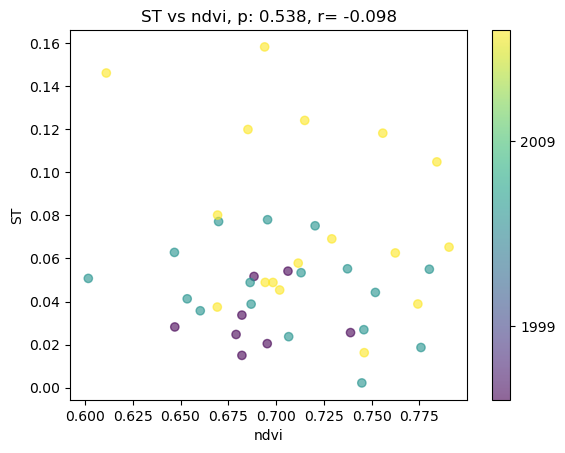

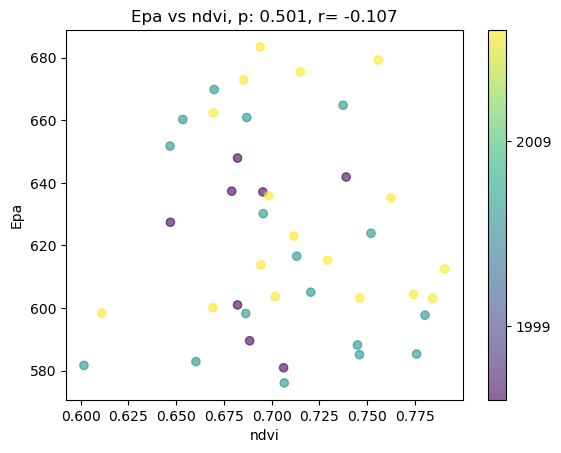

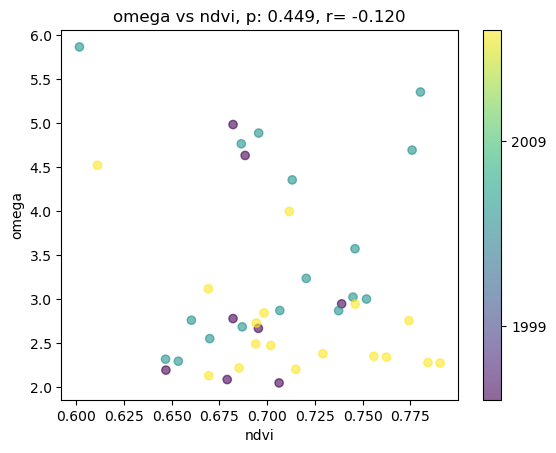

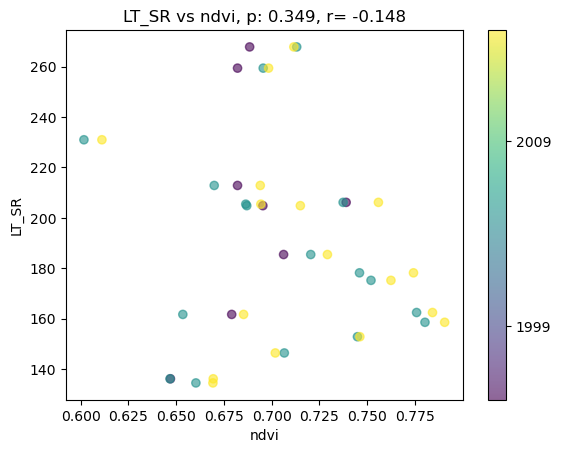

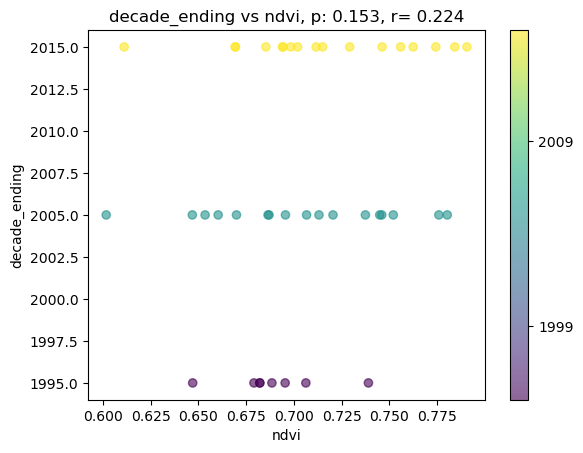

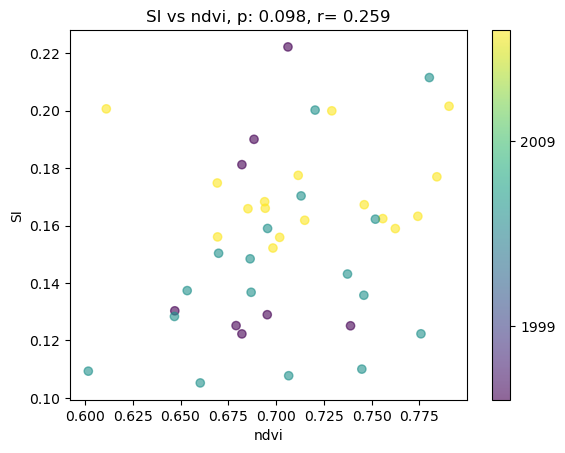

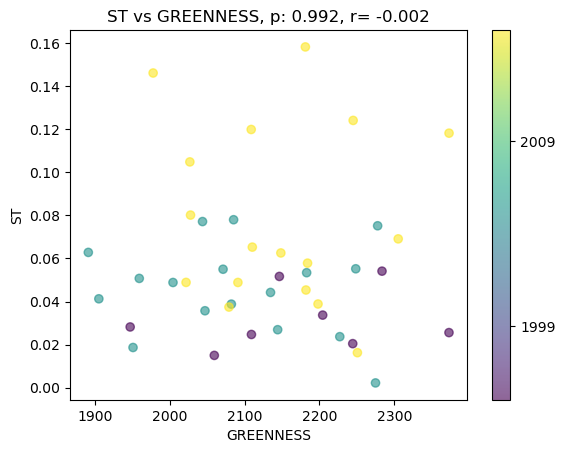

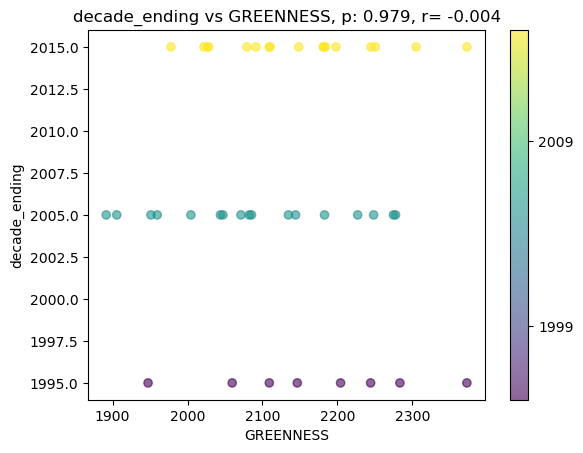

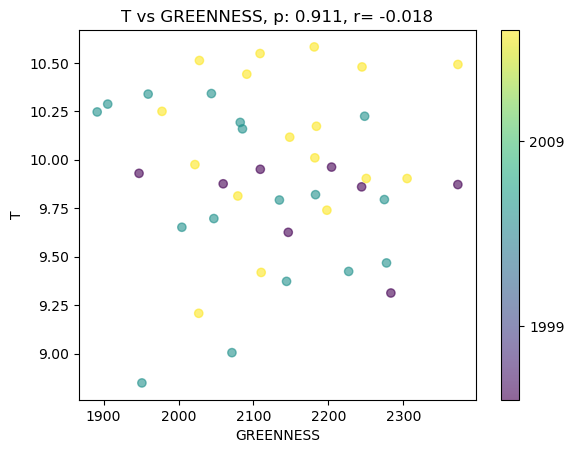

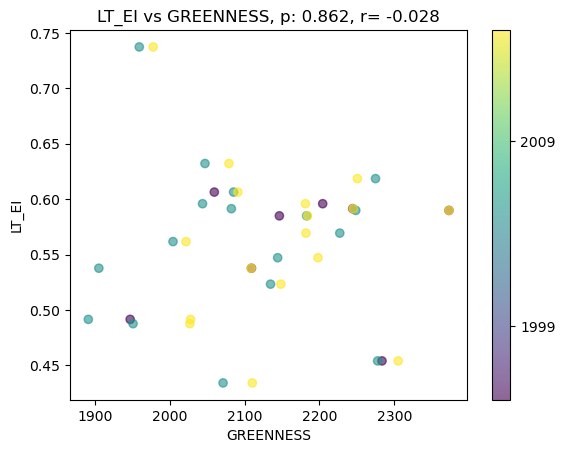

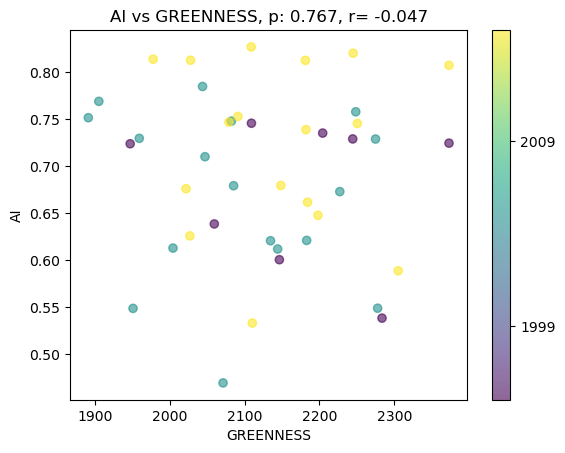

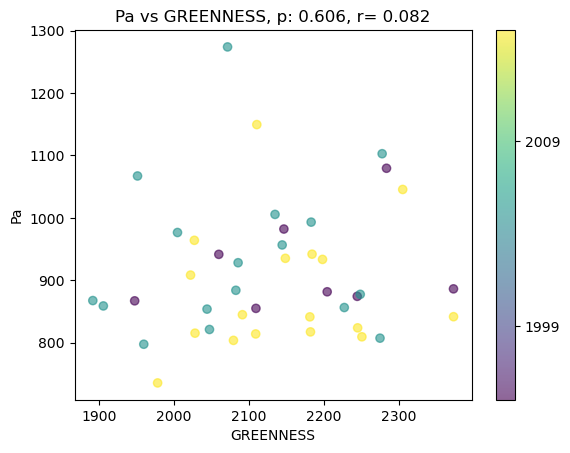

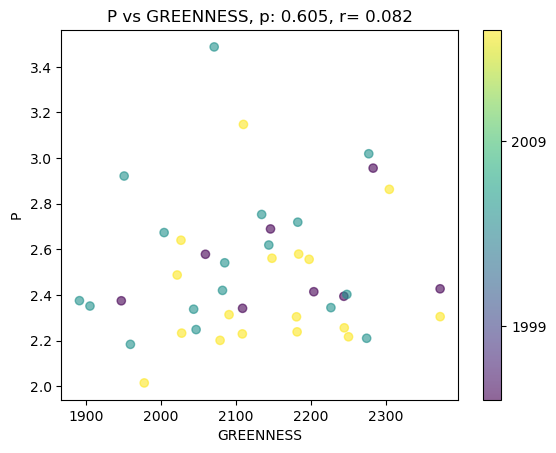

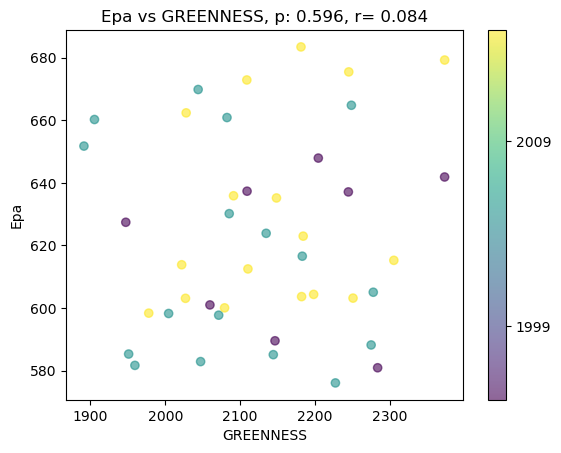

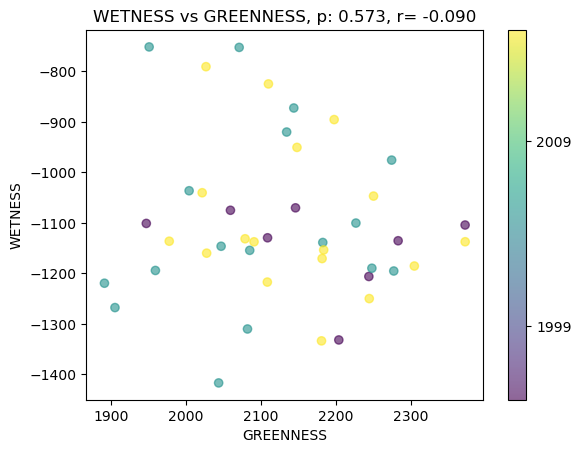

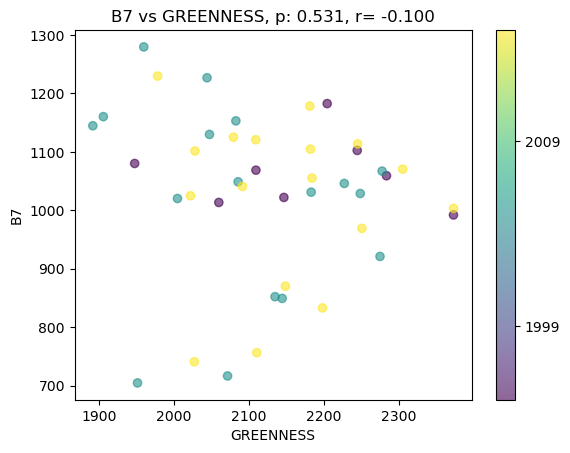

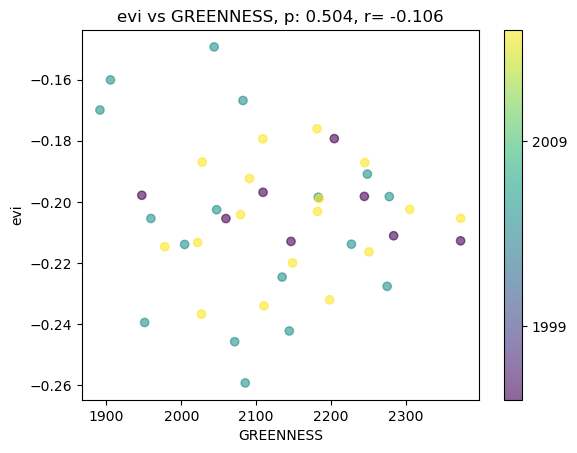

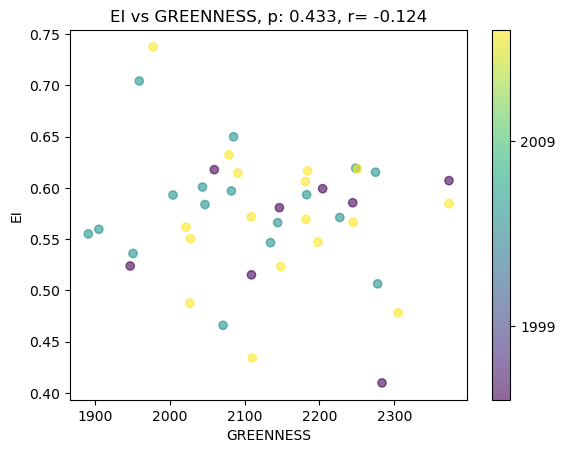

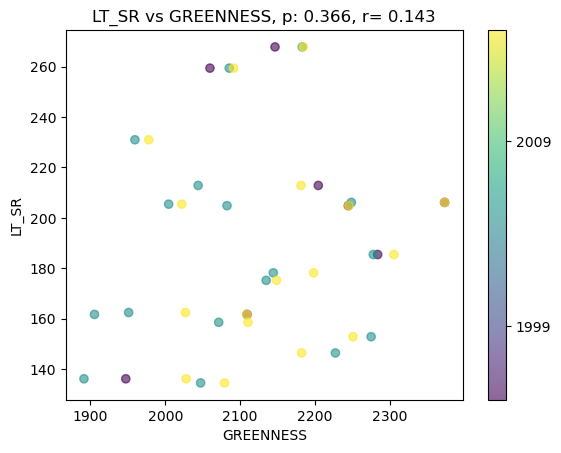

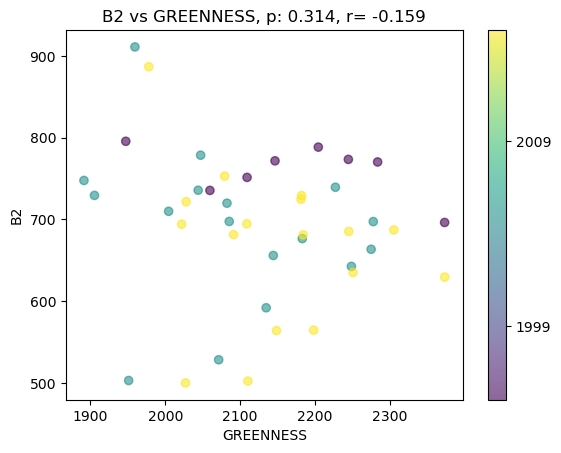

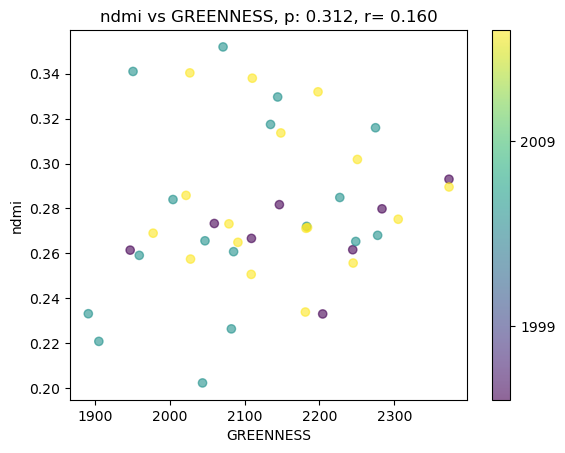

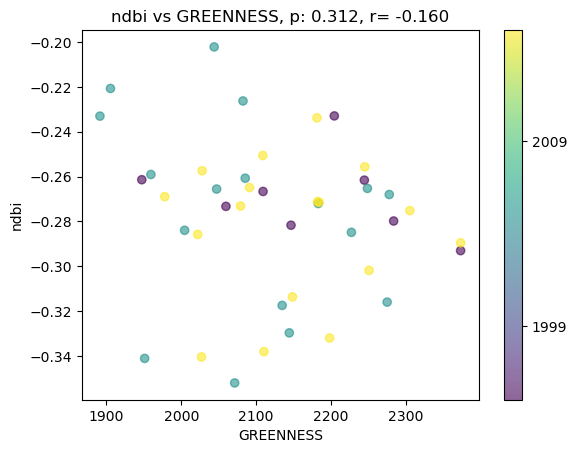

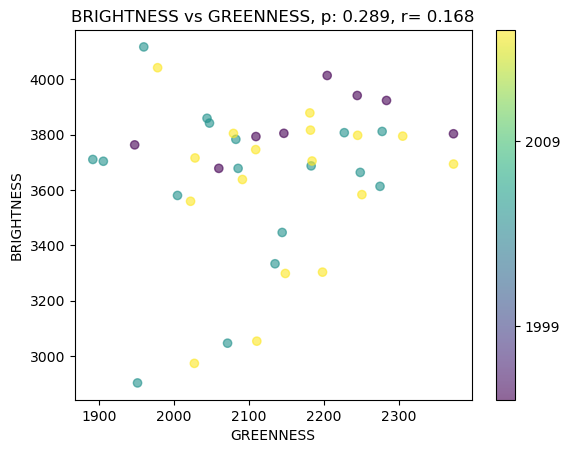

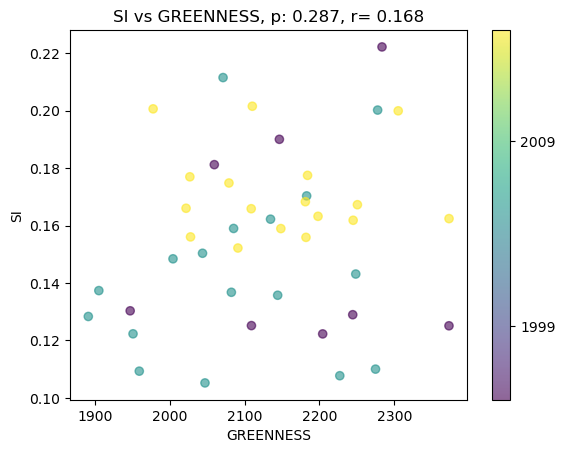

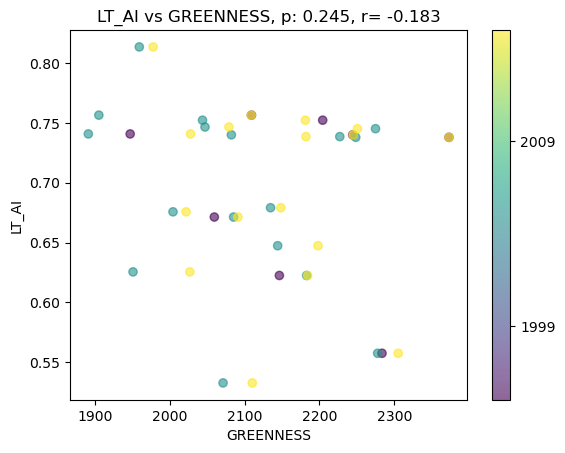

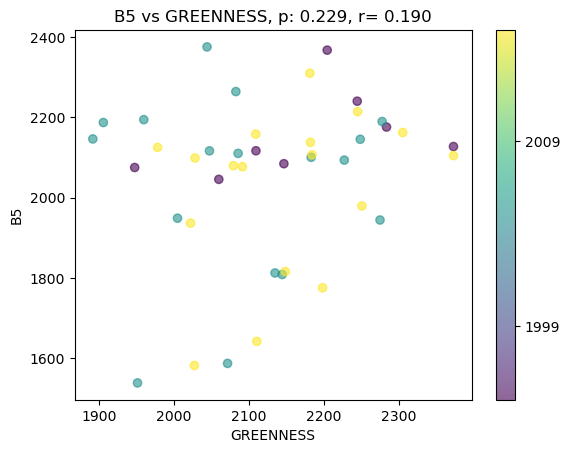

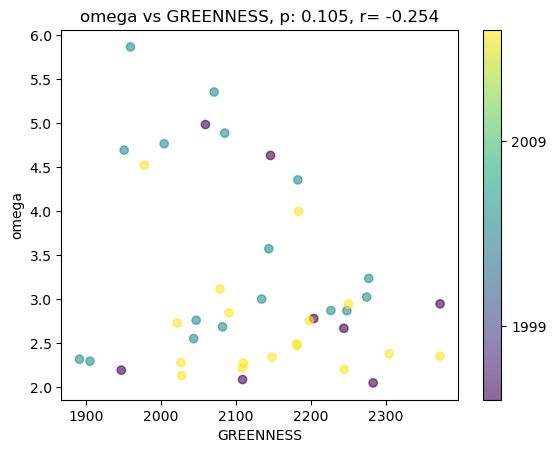

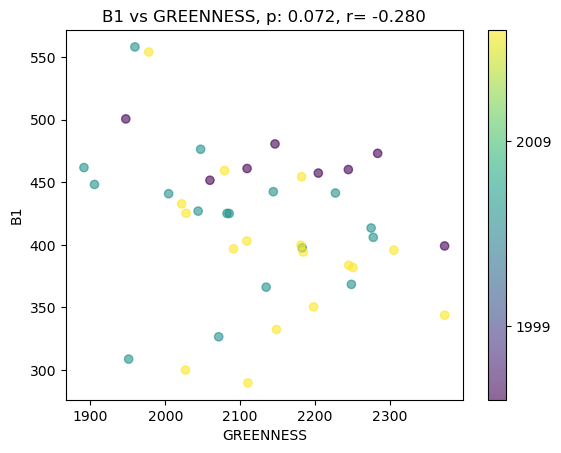

In [67]:
plot_descending_P(['ndvi', 'GREENNESS'], df_all, sorted_p, prs_r)

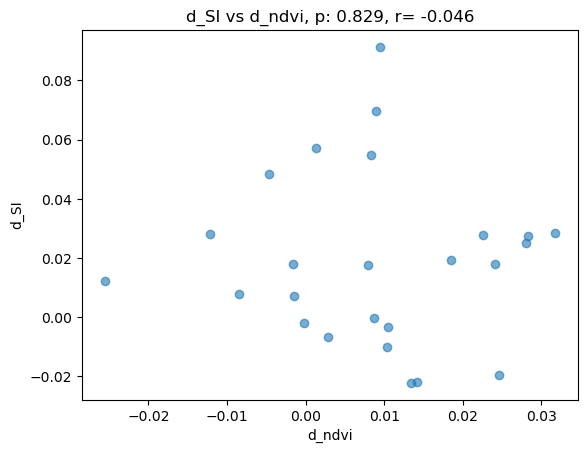

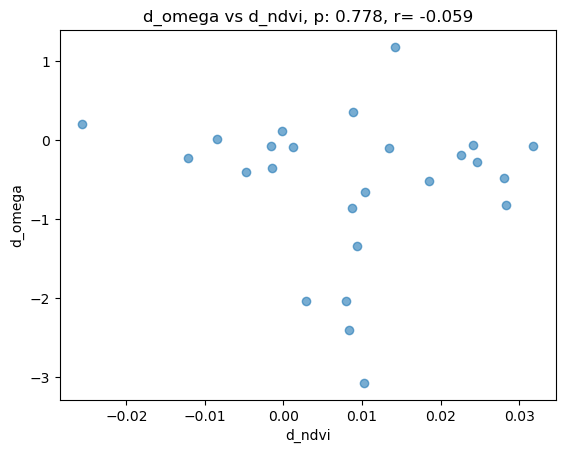

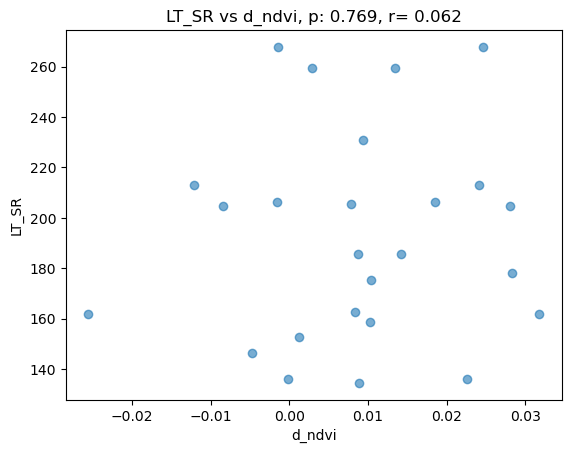

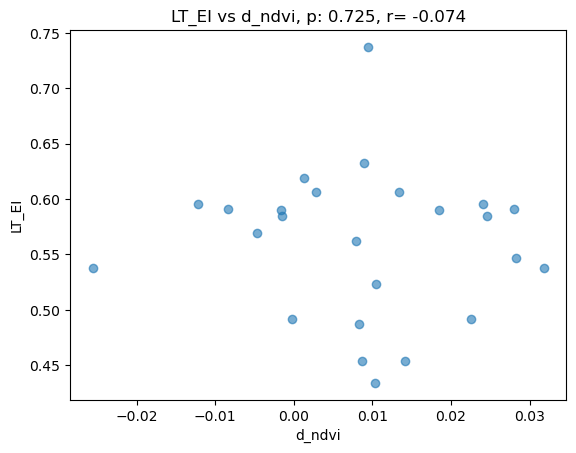

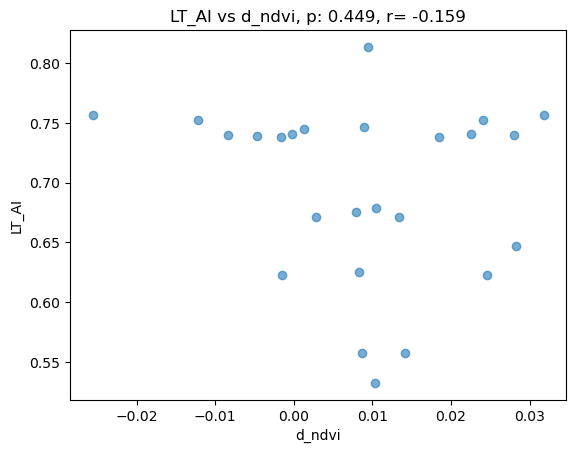

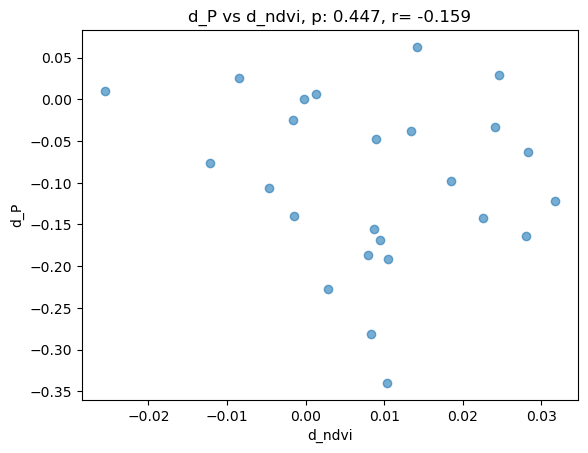

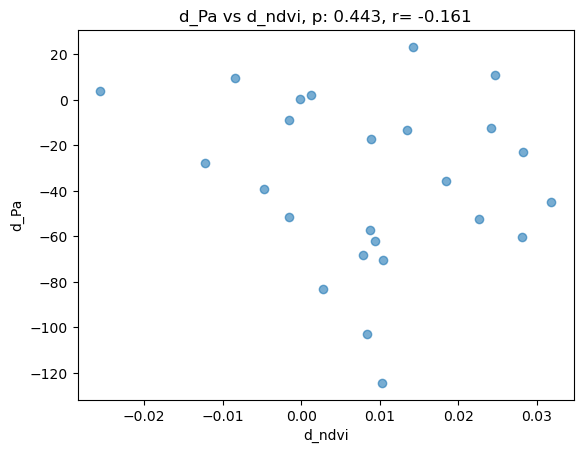

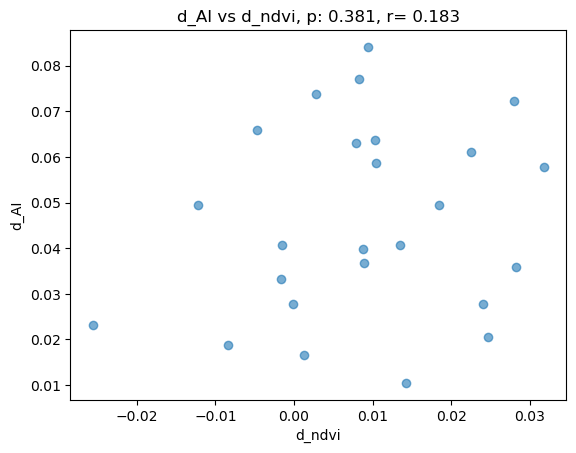

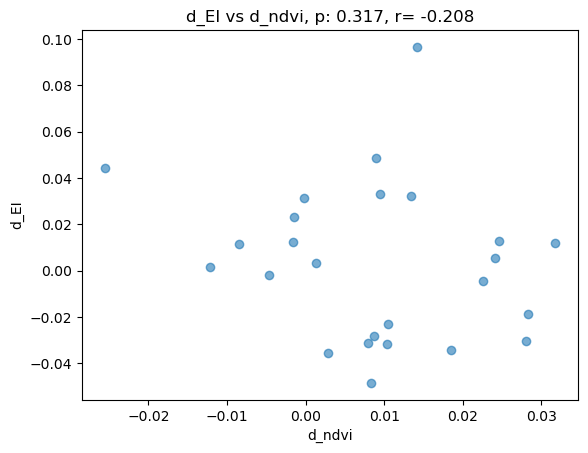

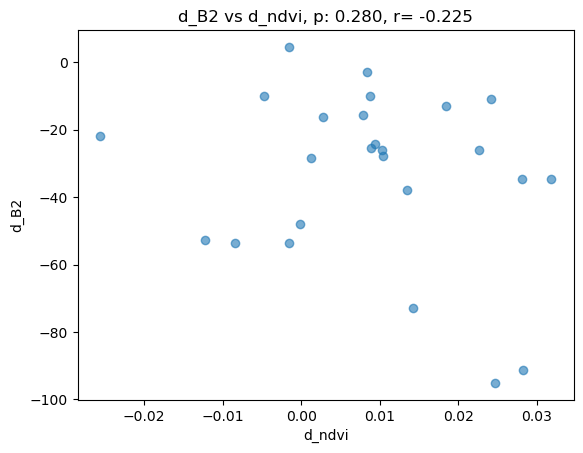

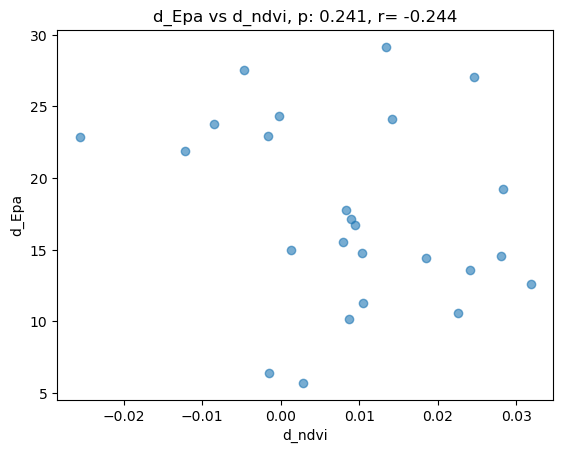

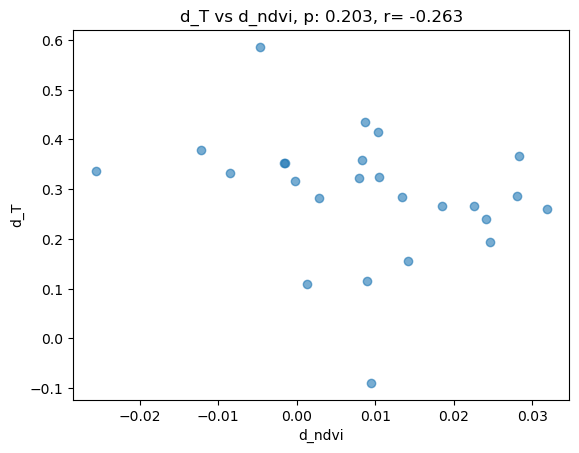

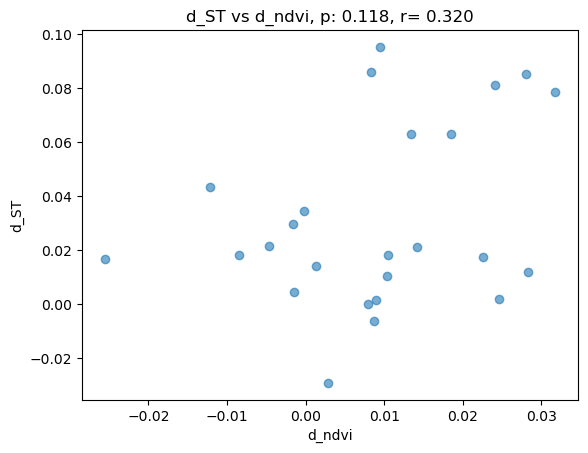

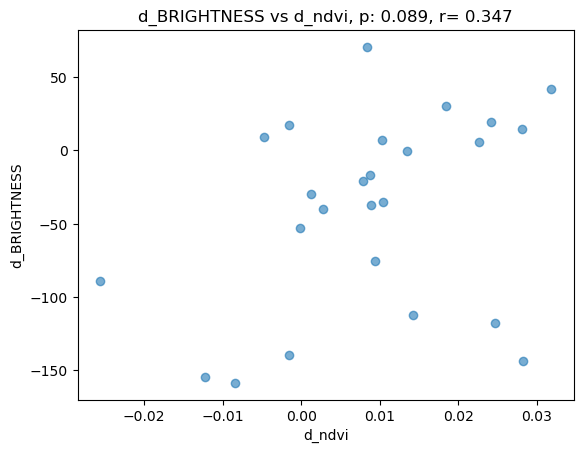

In [68]:
plot_descending_P(['ndvi'], df_delta_all, sorted_delta_p, prs_delta_r, delta=True)

In [69]:
mk = np.array(mk_list)

data_types_dict = {'trend': str, 
                   'h':bool, 
                   'p':float, 
                   'z':float, 
                   'Tau':float, 
                   's':float, 
                   'var_s':float, 
                   'slope': float, 
                   'intercept':float, 
                   'band':str, 
                   'system_index':str, 
                   'Catchment_Name':str}

mk_dict = {'trend':mk[:, 0], 
           'h':mk[:, 1], 
           'p':mk[:, 2], 
           'z':mk[:, 3], 
           'Tau':mk[:, 4], 
           's':mk[:, 5], 
           'var_s':mk[:, 6], 
           'slope':mk[:, 7], 
           'intercept':mk[:, 8], 
           'band':mk[:, 9], 
           'system_index':mk[:, 10], 
           'Catchment_Name':mk[:, 11]}

mk_df = pd.DataFrame(mk_dict).astype(data_types_dict)

In [70]:
groups = mk_df.groupby(['band']).groups
keys = groups.keys()

In [71]:
def export_key_MK_tables(key, groups):
    frm_ind = groups[key][0]
    to_ind = groups[key][-1]
    key_df = mk_df[groups[key][0]:groups[key][-1]]
#    plt.figure()
#    plt.title(f'{key}')
#    key_df.trend.hist()
    key_df.to_excel(f'{path}mk_trends/mk_{str(key)}.xlsx')

[export_key_MK_tables(key, groups) for key in keys]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

B1: min:-18.925272842760933, max:-1.8761747056342983
B2: min:-20.249462159006953, max:-1.479276336196514
B3: min:-16.29351156006601, max:-0.5022493493564915
B4: min:-14.470733827639362, max:6.157205627548819
B5: min:-11.561306219310987, max:3.783186820251682
B7: min:-7.307872677079956, max:3.727559654039832
BRIGHTNESS: min:-40.28195927533761, max:2.234712950147241
GREENNESS: min:-3.7277428034184936, max:12.434876519283275
WETNESS: min:-6.992927524053243, max:1.177035493863491
evi: min:-0.0008429749304451478, max:0.0025854590727174224
gndvi: min:0.00013755655001213007, max:0.004164621753969042
nbr: min:-0.0017798868324160671, max:0.0009385784606054548
ndbi: min:-0.0007056335476696521, max:0.001299258500247432
ndmi: min:-0.001299258500247432, max:0.0007056335476696521
ndvi: min:-0.0003255308078879644, max:0.003750043421803889


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

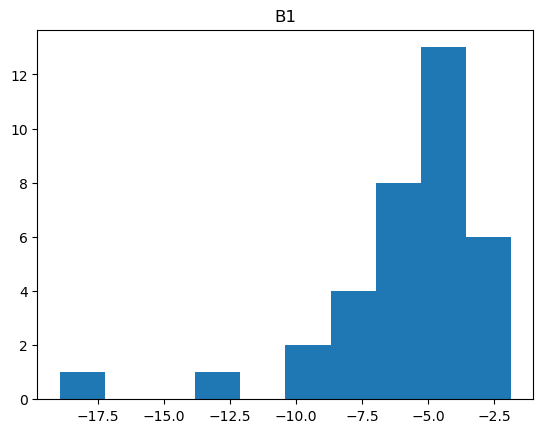

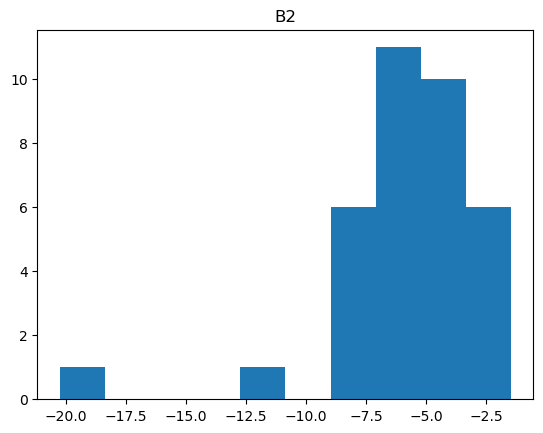

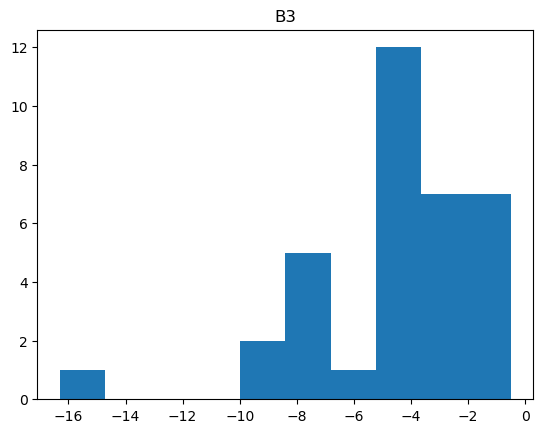

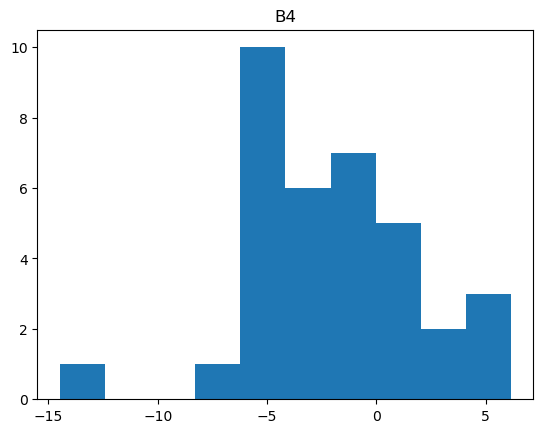

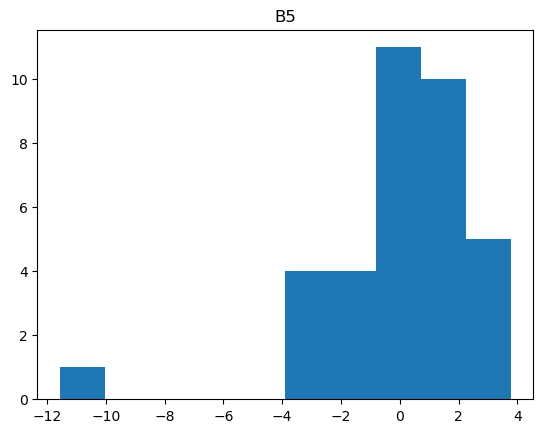

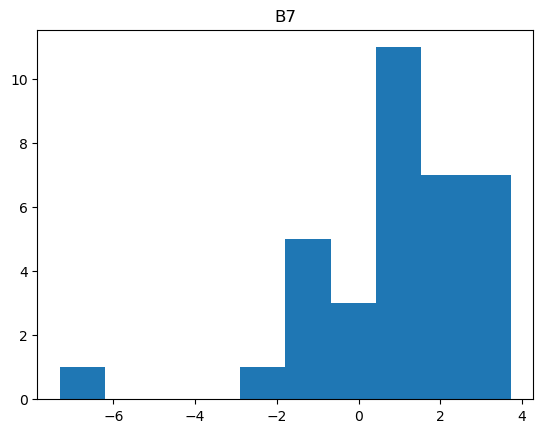

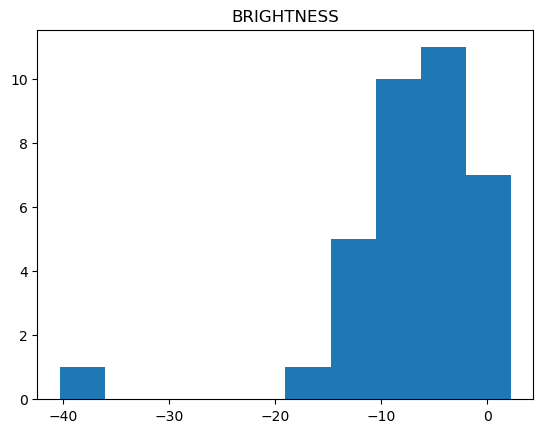

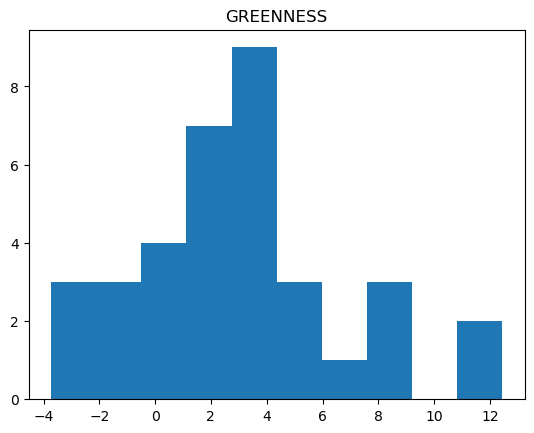

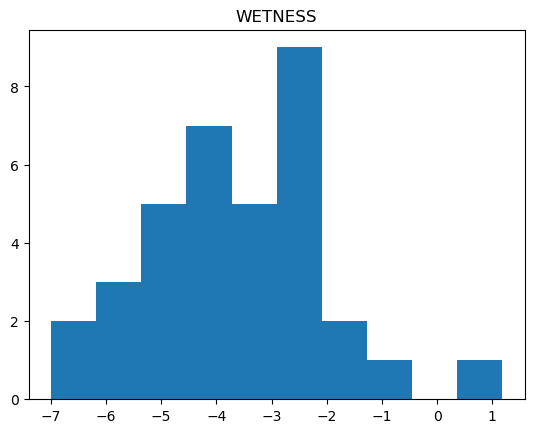

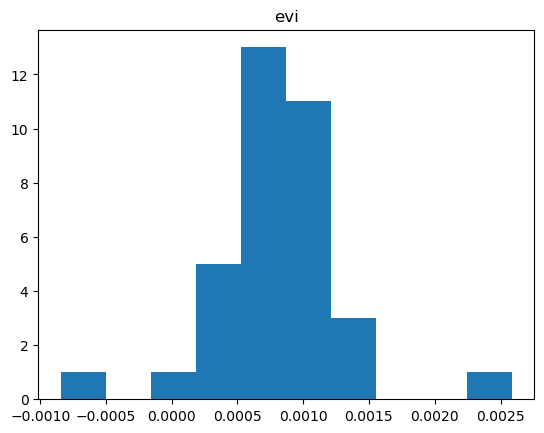

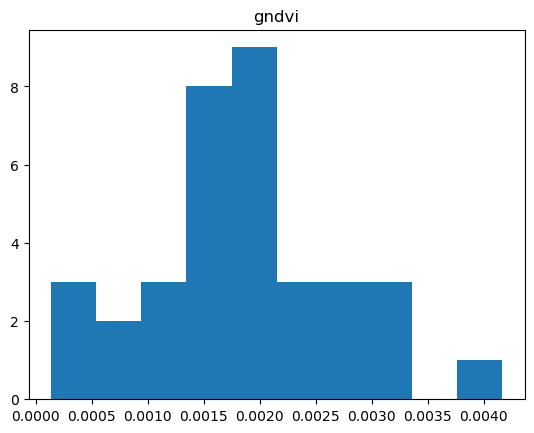

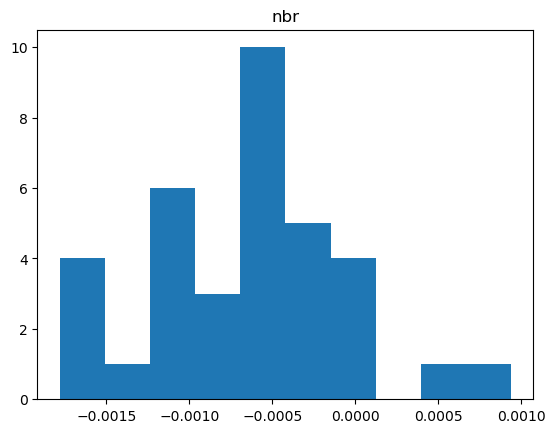

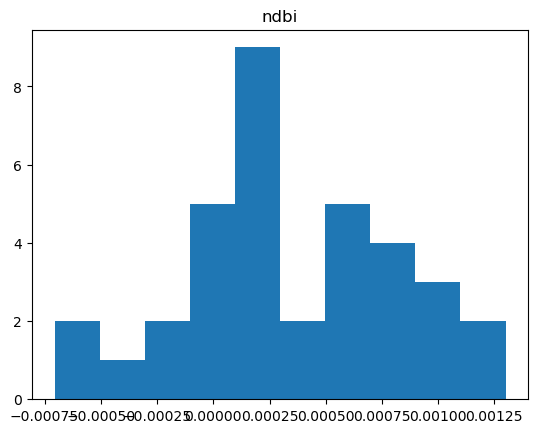

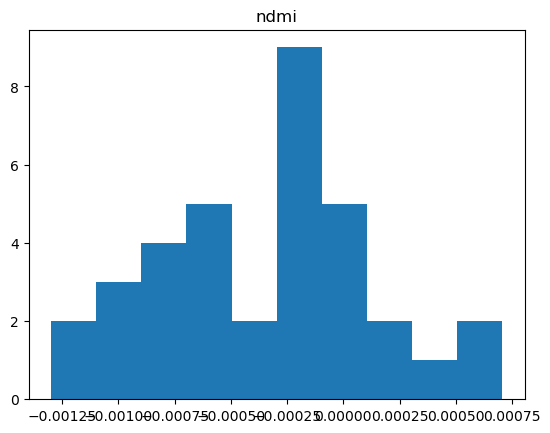

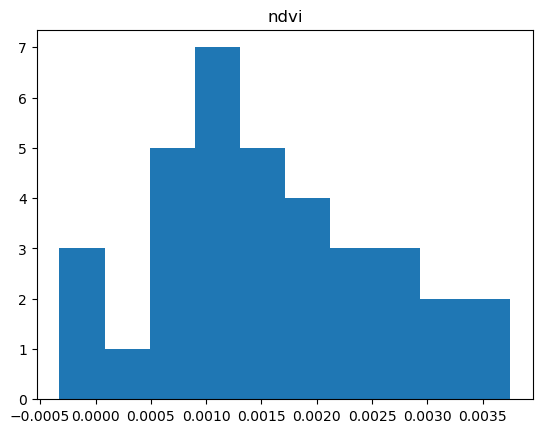

In [72]:
fignum=0

def hist(band):
    frm_ind = groups[band][0]
    to_ind = groups[band][-1]
    key_df = mk_df[frm_ind:to_ind]
    plt.figure()
    x = np.array(key_df.slope)
    print(f'{band}: min:{np.min(x)}, max:{np.max(x)}')
    plt.hist(x)
    plt.title(f'{band}')
    
    
[hist(key) for key in keys]